In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from collections import defaultdict
import statistics as stats
from collections import Counter
from scipy.stats import fisher_exact, yeojohnson, wilcoxon
import numpy as np
import seaborn as sns
from scipy.stats import f_oneway, ttest_ind, pearsonr
from sklearn.preprocessing import normalize
from sklearn.linear_model import LinearRegression
import pickle
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [2]:
from matplotlib import rc

In [3]:
rc('font',**{'family':'sans-serif','sans-serif':['DejaVu Sans'],'size':10})
rc('mathtext',**{'default':'regular'})

In [4]:
sns.set_style('white')
sns.set_context("paper", font_scale = 2)

# Importing data from Michael Raddatz - now using more complete dataset of ~75k

In [5]:
# ! gsutil cp gs://fc-e44e4e80-489e-4c0f-a2a7-a96718d54f46/data/topmed/marginal_trinucleotide_substitution_counts_equiv_vaf_2020_09_01.csv .

In [6]:
# mut_df = pd.read_csv("marginal_trinucleotide_substitution_counts_equiv_vaf_2020_09_01.csv")

In [7]:
# len(mut_df['NWD_ID'].unique())

## Only selecting for C>T or T>C mutations as was done in PACER paper

"C>T and T>C mutations used because they were age-associated (worried about different base substitutions varying in association with age at blood draw)"

In [8]:
# mut_ct_df = mut_df[((mut_df.REF == "C") & (mut_df.ALT == "T")) | ((mut_df.REF == "T") & (mut_df.ALT == "C"))]

In [9]:
# mut_ct_df

## Getting the passenger mutation rate by summing the # of passenger mutations for each sample id

In [10]:
# passenger_df = mut_ct_df.groupby("NWD_ID").agg({'n': ['sum']})['n']
# passenger_df = passenger_df.reset_index(level=0)

# Importing updated topmed data

## Importing demographic data

In [11]:
cov_df = pd.read_csv("topmed_tcell_cov.txt", sep = '\t')

In [12]:
sex_dict = pd.Series(cov_df.sex.values,index=cov_df['sample']).to_dict()
age_dict = pd.Series(cov_df.AgeAtBloodDraw.values,index=cov_df['sample']).to_dict()

## Importing mutation data

In [13]:
!gsutil cp gs://fc-b7cd8c47-767b-4eda-b456-736a92f723ac/data/singletons_spark_2021_05_25.parquet .

Copying gs://fc-b7cd8c47-767b-4eda-b456-736a92f723ac/data/singletons_spark_2021_05_25.parquet...
\ [1 files][615.1 MiB/615.1 MiB]   27.9 MiB/s                                   
Operation completed over 1 objects/615.1 MiB.                                    


In [14]:
#Read in data, subset to C>T and T>C mutations, and obtain passenger mutation count
topmed_df = pd.read_parquet('singletons_spark_2021_05_25.parquet')
topmed_ct_df = topmed_df[((topmed_df.REF == "C") & (topmed_df.ALT == "T")) | ((topmed_df.REF == "T") & (topmed_df.ALT == "C"))]
topmed_ct_passenger_df = pd.DataFrame(topmed_ct_df['NWD_ID'].value_counts())
topmed_ct_passenger_df = topmed_ct_passenger_df.reset_index(level=0)
topmed_ct_passenger_df.columns = ['NWD_ID', 'sum']
chip_dict = pd.Series(topmed_ct_df.chip_case.values,index=topmed_ct_df['NWD_ID']).to_dict()

## Constructing final data frame with id, total passenger mutations, and chip status

### Save CHIP status, sex, and age

In [15]:
no_dup = topmed_ct_passenger_df.drop_duplicates(subset = ['NWD_ID'])
topmed_ct_passenger_df['chip_case'] = topmed_ct_passenger_df['NWD_ID'].map(chip_dict)
topmed_ct_passenger_df['age'] = topmed_ct_passenger_df['NWD_ID'].map(age_dict)
topmed_ct_passenger_df['sex'] = topmed_ct_passenger_df['NWD_ID'].map(sex_dict)
topmed_ct_passenger_df = topmed_ct_passenger_df.rename(columns={"sum": "total_pass_mut", "NWD_ID": "sample.id"})

In [16]:
topmed_ct_passenger_df_filt = topmed_ct_passenger_df[~(topmed_ct_passenger_df['age'].isna() | topmed_ct_passenger_df['sex'].isna())]
print(str(len(topmed_ct_passenger_df_filt)) + " pts with age and sex")

64403 pts with age and sex


In [17]:
#M is 1, F is 0
topmed_ct_passenger_df_filt['sex_dummy'] = 0
topmed_ct_passenger_df_filt.loc[topmed_ct_passenger_df_filt['sex'] == 'M', 'sex_dummy'] = 1

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [18]:
passenger_df = topmed_ct_passenger_df_filt

# Importing mocha for mosaic chromosomal abnormalities 

In [19]:
! gsutil cp gs://fc-secure-827e3d9c-02b8-499f-91af-c2142b7d2074/mCA_pacer/long.mocha.filtered.csv .

Copying gs://fc-secure-827e3d9c-02b8-499f-91af-c2142b7d2074/mCA_pacer/long.mocha.filtered.csv...
/ [1 files][  1.2 MiB/  1.2 MiB]                                                
Operation completed over 1 objects/1.2 MiB.                                      


In [20]:
mocha_df = pd.read_csv("long.mocha.filtered.csv", sep = '\t')

## Standardize the p and q arm notation

In [21]:
mocha_df['q_arm_bool'] = False
mocha_df.loc[(mocha_df['q_arm'] == 'T'),'q_arm_bool'] = True
mocha_df.loc[(mocha_df['q_arm'] == 'Y'),'q_arm_bool'] = True
mocha_df.loc[(mocha_df['q_arm'] == 'TRUE'),'q_arm_bool'] = True
mocha_df['p_arm_bool'] = False
mocha_df.loc[(mocha_df['p_arm'] == 'T'),'p_arm_bool'] = True
mocha_df.loc[(mocha_df['p_arm'] == 'Y'),'p_arm_bool'] = True
mocha_df.loc[(mocha_df['p_arm'] == 'TRUE'),'p_arm_bool'] = True
mocha_df['botharms_bool'] = False
mocha_df.loc[(mocha_df['p_arm_bool']==True) & (mocha_df['q_arm_bool']==True), 'botharms_bool'] = True
mocha_df['arm_short'] = ''
mocha_df.loc[((mocha_df['p_arm_bool']) == True & (mocha_df['q_arm_bool']==False)),'arm_short'] = 'p'
mocha_df.loc[((mocha_df['p_arm_bool']) == False & (mocha_df['q_arm_bool']==True)),'arm_short'] = 'q'
mocha_df.loc[(mocha_df['botharms_bool'] == True),'arm_short'] = ''

## Standardize the mCA type notation 

In [22]:
mocha_df['type_short'] = "U"
mocha_df.loc[mocha_df['type'] == 'Gain', 'type_short'] = "+"
mocha_df.loc[mocha_df['type'] == 'Loss', 'type_short'] = "-"
mocha_df.loc[mocha_df['type'] == 'CN-LOH', 'type_short'] = "="

### Combine mCA information for a row 

In [23]:
mocha_df['mca'] = mocha_df['type'] + " in " + mocha_df['chrom']
mocha_df['chrom_short'] = mocha_df['chrom'].str.replace("chr","")
mocha_df['mca_short'] = mocha_df['chrom_short'] + mocha_df['type_short']
mocha_df['mca_short_arm'] = mocha_df['chrom_short'] + mocha_df['arm_short'] + mocha_df['type_short']

In [24]:
mocha_df_nochrx = mocha_df[mocha_df['chrom'] != 'chrX']
mocha_df_nochrx['chrom_short'] = pd.to_numeric(mocha_df_nochrx['chrom_short'])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


# Summary statistics of the data

## Passenger

In [25]:
print("Unique sample ids: " + str(len(set(passenger_df['sample.id']))))

Unique sample ids: 64403


### Descriptive stats on total passenger mutations by covariates

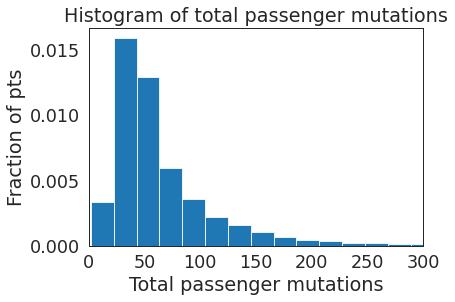

Min: 2
Max: 3072
Median: 49


In [26]:
total_pass_mut = list(passenger_df['total_pass_mut'])
plt.hist(passenger_df['total_pass_mut'], density = True, bins = 150)
plt.ylabel('Fraction of pts')
plt.xlabel('Total passenger mutations')
plt.title("Histogram of total passenger mutations")
plt.xlim(0,300)
plt.show()
print("Min: " + str(min(passenger_df['total_pass_mut'])))
print("Max: " + str(max(passenger_df['total_pass_mut'])))
print("Median: " + str(stats.median(passenger_df['total_pass_mut'])))

Look above for the histogram of the age- and sex-adjusted clonal expansion rates after inverse normal transformation 

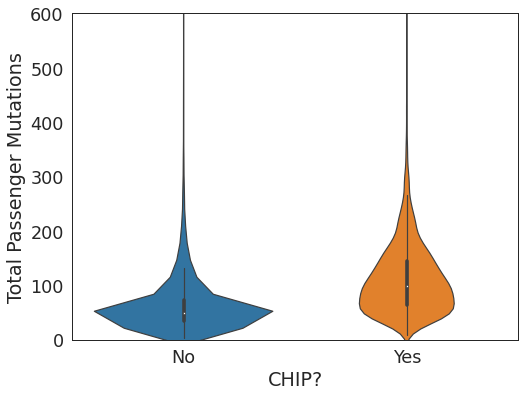

p-value for t-test: 0.0


In [27]:
plt.figure(figsize=(8,6))
ax = sns.violinplot(y="total_pass_mut", 
                x="chip_case", 
                data=passenger_df)
plt.ylim(0,600)
ax.set(xlabel='CHIP?', ylabel='Total Passenger Mutations', xticklabels=['No', 'Yes'])
plt.show()
print("p-value for t-test: " + str(ttest_ind(passenger_df[passenger_df['chip_case'] == True]['total_pass_mut'], 
                passenger_df[passenger_df['chip_case'] == False]['total_pass_mut'])[1]))

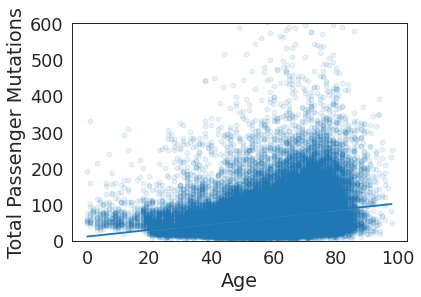

In [28]:
ax = sns.regplot(x="age", y="total_pass_mut", data=passenger_df, scatter_kws={'alpha':0.1})
plt.ylim(0,600)
ax.set(xlabel='Age', ylabel='Total Passenger Mutations')
plt.show()

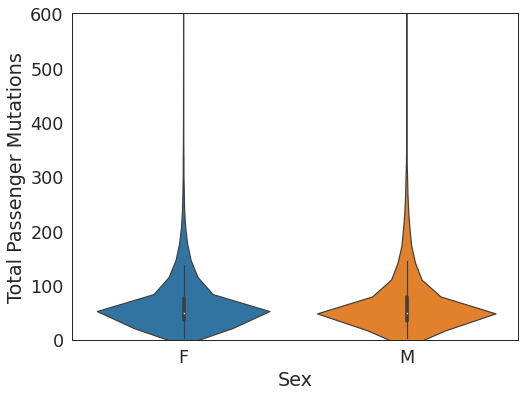

p-value for t-test: Ttest_indResult(statistic=nan, pvalue=nan)


In [29]:
plt.figure(figsize=(8,6))
ax = sns.violinplot(y="total_pass_mut", 
                x="sex", 
                data=passenger_df)
plt.ylim(0,600)
ax.set(xlabel='Sex', ylabel='Total Passenger Mutations')
ax.set_xticklabels(['F', 'M'])
plt.show()
print("p-value for t-test: " + str(ttest_ind(passenger_df[passenger_df['sex'] == 0]['total_pass_mut'], 
                passenger_df[passenger_df['sex'] == 1]['total_pass_mut'])))

## Mocha

In [30]:
def plotmCAsummary(df):
    df['chrom'].value_counts().plot(kind='bar')
    plt.xlabel('Counts')
    plt.ylabel('Chromosome of mCA')
#     plt.xscale("log")
    plt.title("Counts of mCAs")
    plt.show()
    df['type'].value_counts().plot(kind='bar')
    plt.xlabel('Counts')
    plt.ylabel('Type of mCA')
    plt.title('Frequency of mCAs by type')
    plt.show()

In [31]:
def getmCAtypesbychromosome(df):
    mca_counts = defaultdict(dict)
    chromosomes = list(set(df['chrom']))
    mca_types = list(set(df['type']))
    for chrom in chromosomes:
        for mcatype, count in df[df['chrom'] == chrom]['type'].value_counts().iteritems():
            mca_counts[chrom][mcatype] = count

    cnloh = []
    gain = []
    loss = []
    for chrom in sorted([i for i in mca_counts if mca_counts[i]!=mca_counts.default_factory()]):
        cnloh.append(mca_counts[chrom]['CN-LOH'])
        gain.append(mca_counts[chrom]['Gain'])
        loss.append(mca_counts[chrom]['Loss'])

    mca_counts_df = pd.DataFrame(list(zip(sorted([i for i in mca_counts if mca_counts[i]!=mca_counts.default_factory()]), cnloh, gain, loss)), 
                                 columns = ['chr', 'CN-LOH', 'Gain', 'Loss'])
    mca_counts_df.plot(x='chr',
            kind='bar',
            stacked=True,
            title='Frequency of mCA types by chromosome', logy = True, fontsize = 14, figsize = (20, 20))
    
    plt.xlabel('Chr', fontsize=20)
    plt.ylabel('Counts', fontsize=25)
    plt.xticks(rotation='horizontal')
    plt.legend(fontsize = 20, frameon=True, title='Copy change',
                        title_fontsize=25)

    plt.show()

In [32]:
def getmCAtypesbychromosome_noX(df):
    mca_counts = defaultdict(dict)
    chromosomes = list(set(df['chrom']))
    mca_types = list(set(df['type']))
    for chrom in chromosomes:
        for mcatype, count in df[df['chrom'] == chrom]['type'].value_counts().iteritems():
            mca_counts[chrom][mcatype] = count

    cnloh = []
    gain = []
    loss = []
    for chrom in sorted([int(i.replace("chr", "")) for i in mca_counts if mca_counts[i]!=mca_counts.default_factory()]):
        cnloh.append(mca_counts["chr" + str(chrom)]['CN-LOH'])
        gain.append(mca_counts["chr" + str(chrom)]['Gain'])
        loss.append(mca_counts["chr" + str(chrom)]['Loss'])

    mca_counts_df = pd.DataFrame(list(zip(sorted([int(i.replace("chr", "")) for i in mca_counts if mca_counts[i]!=mca_counts.default_factory()]), cnloh, gain, loss)), 
                                 columns = ['chr', 'CN-LOH', 'Gain', 'Loss'])
    mca_counts_df.plot(x='chr',
            kind='bar',
            stacked=True,
            figsize = (20, 20), xlabel="")

    plt.xlabel('Chr', fontsize=20)
    plt.ylabel('Counts', fontsize=25)
    plt.xticks(rotation='horizontal', fontsize=20)
    plt.yticks(fontsize=20)

    plt.legend(fontsize = 20, frameon=True, title='Copy change',
                        title_fontsize=25)

    plt.show()

In [49]:
def getmCAtypesbychromosome_noX(df, filename):
    mca_counts = defaultdict(dict)
    chromosomes = list(set(df['chrom']))
    mca_types = list(set(df['type']))
    for chrom in chromosomes:
        for mcatype, count in df[df['chrom'] == chrom]['type'].value_counts().iteritems():
            mca_counts[chrom][mcatype] = count

    undet = []
    cnloh = []
    gain = []
    loss = []
    for chrom in sorted([int(i.replace("chr", "")) for i in mca_counts if mca_counts[i]!=mca_counts.default_factory()]):
        cnloh.append(mca_counts["chr" + str(chrom)]['CN-LOH'])
        gain.append(mca_counts["chr" + str(chrom)]['Gain'])
        loss.append(mca_counts["chr" + str(chrom)]['Loss'])

    mca_counts_df = pd.DataFrame(list(zip(sorted([int(i.replace("chr", "")) for i in mca_counts if mca_counts[i]!=mca_counts.default_factory()]), cnloh, gain, loss)), 
                                 columns = ['chr', 'CN-LOH', 'Gain', 'Loss'])
    
    plt.figure(dpi = 300)
    mca_counts_df.plot(x='chr',
            kind='bar',
            stacked=True,
            figsize = (20, 20), xlabel="", color=['y', 'r', 'b'])

    plt.xlabel('Chr', fontsize=40)
    plt.ylabel('Counts', fontsize=40)
    plt.xticks(rotation='horizontal', fontsize=30)
    plt.yticks(fontsize=30)

    plt.legend(fontsize = 30, frameon=True, title='Copy change',
                        title_fontsize=30)
#     plt.show(block=False)
    plt.savefig(filename, dpi=300)

In [34]:
def plot_clonal_fraction(df, withX=True):
    if not withX:
        df = df[~df['mca'].str.contains("X")]
    plt.hist(df['cf'], bins=100)
    plt.ylabel('Number of pts')
    plt.xlabel('Clonal fraction')
    plt.xlim(0,0.6)
    if withX:
        plt.title("Histogram of clonal fraction " + "including chrX")
    if not withX:
        plt.title("Histogram of clonal fraction " + "excluding chrX")
    plt.show()
    print("Min: " + str(min(df['cf'])))
    print("Max: " + str(max(df['cf'])))
    print("Median: " + str(stats.median(df['cf'])))

### With chr X

In [35]:
print("Unique sample ids: " + str(len(set(mocha_df['sample_id']))))
print("Total sample ids: " + str(len(mocha_df['sample_id'])))

Unique sample ids: 8517
Total sample ids: 10115


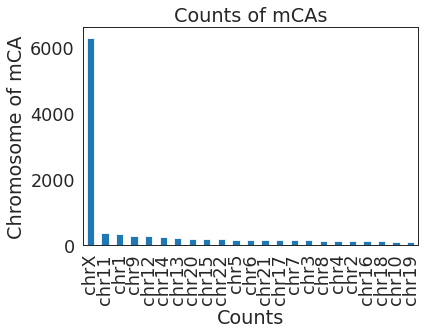

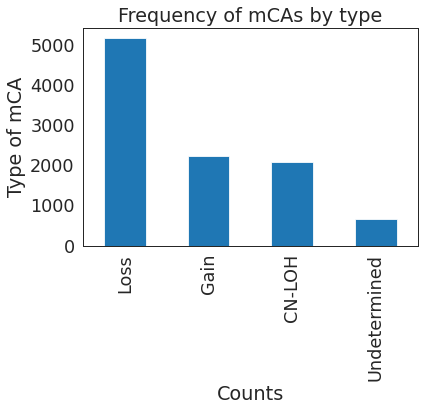

In [36]:
plotmCAsummary(mocha_df)

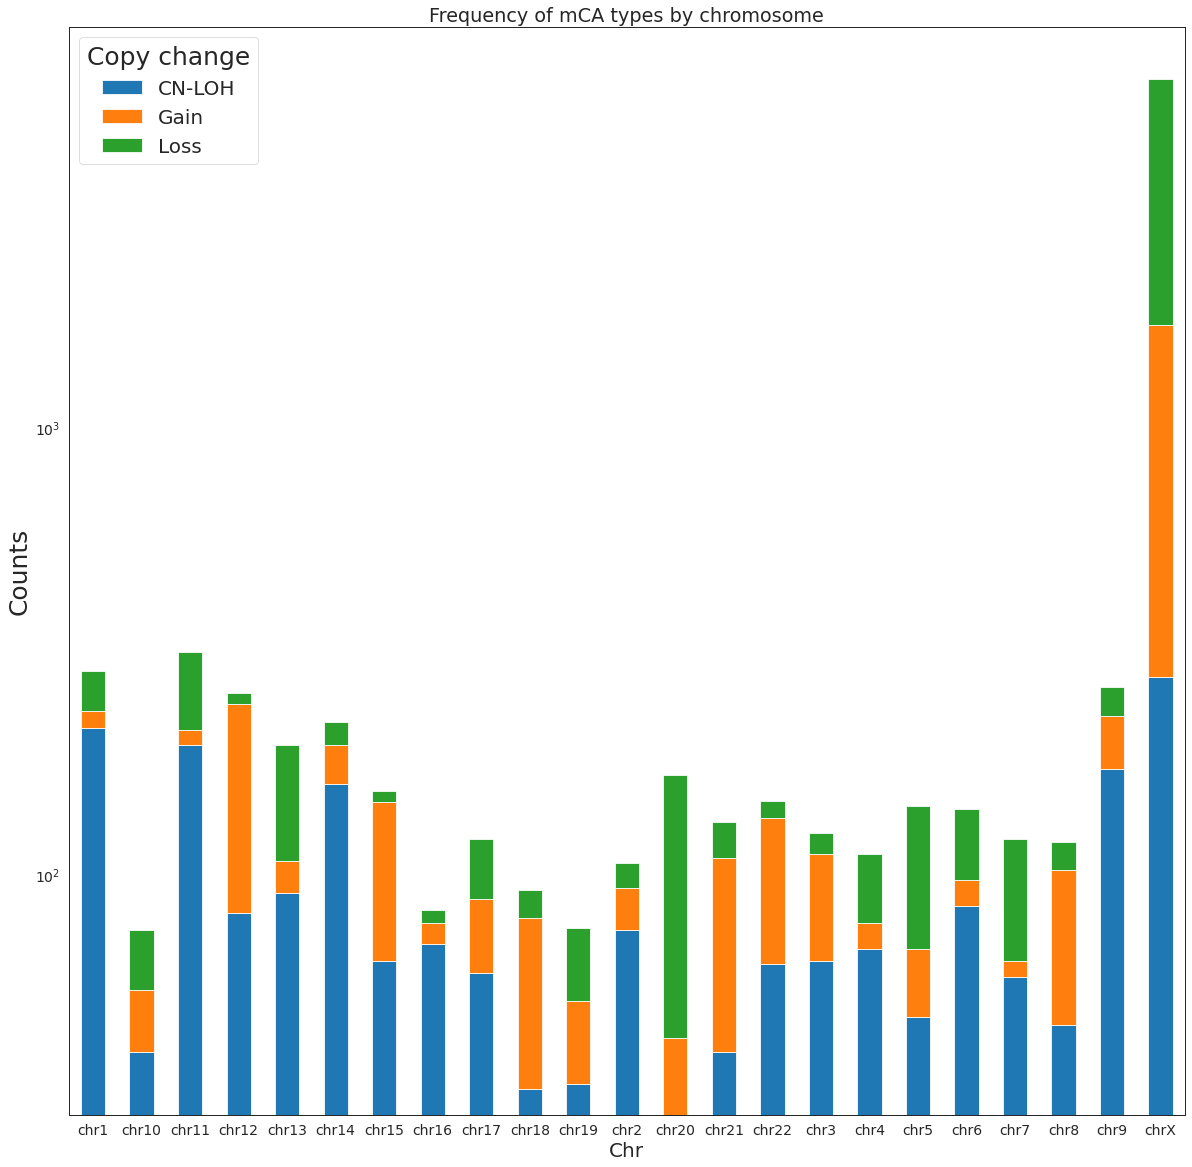

In [37]:
getmCAtypesbychromosome(mocha_df)

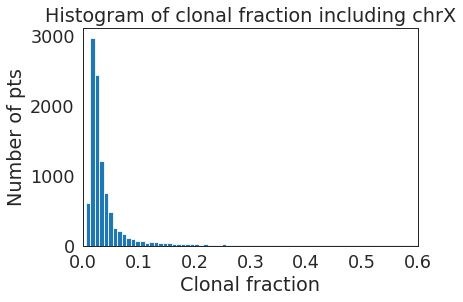

Min: 0.0046
Max: 0.8172
Median: 0.0252


In [38]:
plot_clonal_fraction(mocha_df)

### Without chr X

In [39]:
print("Unique sample ids: " + str(len(set(mocha_df_nochrx['sample_id']))))
print("Total sample ids: " + str(len(mocha_df_nochrx['sample_id'])))

Unique sample ids: 3068
Total sample ids: 3828


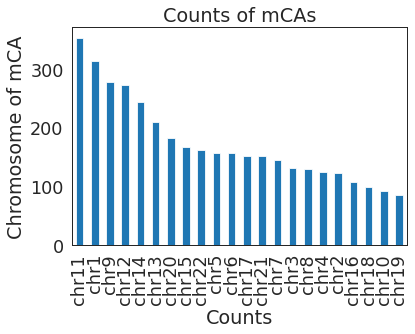

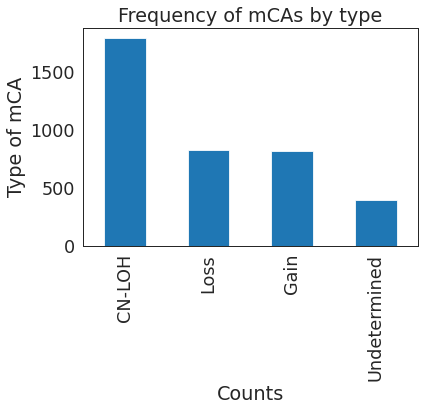

In [40]:
plotmCAsummary(mocha_df_nochrx)

<Figure size 1800x1200 with 0 Axes>

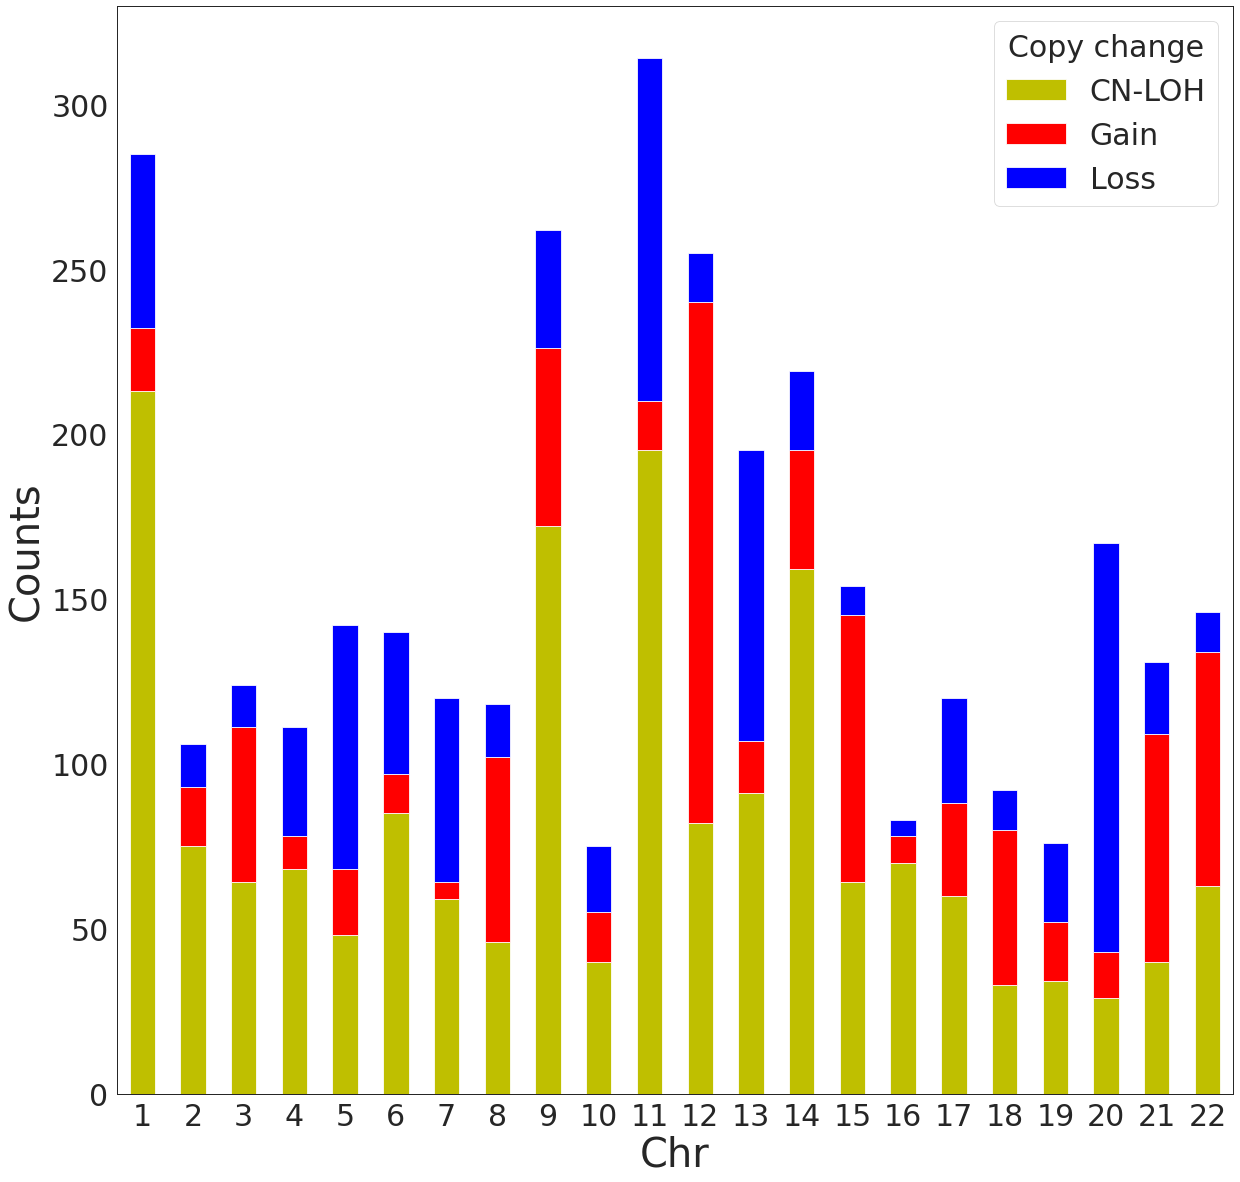

In [50]:
getmCAtypesbychromosome_noX(mocha_df_nochrx, 'fig1b_mcadistribution.tif')

In [51]:
!gsutil cp fig1b_mcadistribution.tif gs://fc-secure-827e3d9c-02b8-499f-91af-c2142b7d2074/mCA_pacer/figures/fig1b_mcadistribution.tif 

Copying file://fig1b_mcadistribution.tif [Content-Type=image/tiff]...
\ [1 files][137.3 MiB/137.3 MiB]                                                
Operation completed over 1 objects/137.3 MiB.                                    


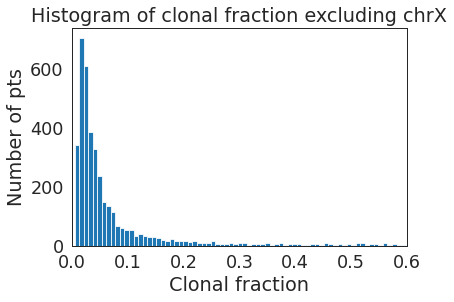

Min: 0.0046
Max: 0.8172
Median: 0.0294


In [43]:
plot_clonal_fraction(mocha_df, False)

### Expanded clone analysis (CF > 10%)

As done in Zekavat et al, 2021 - look at mCAs that have a clonal fraction of < and > 10%

https://www.nature.com/articles/s41591-021-01371-0#Sec20

In [44]:
mocha_df_nochrx['expanded_clone'] = False
mocha_df_nochrx.loc[mocha_df_nochrx['cf'] > 0.1,'expanded_clone']=True

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


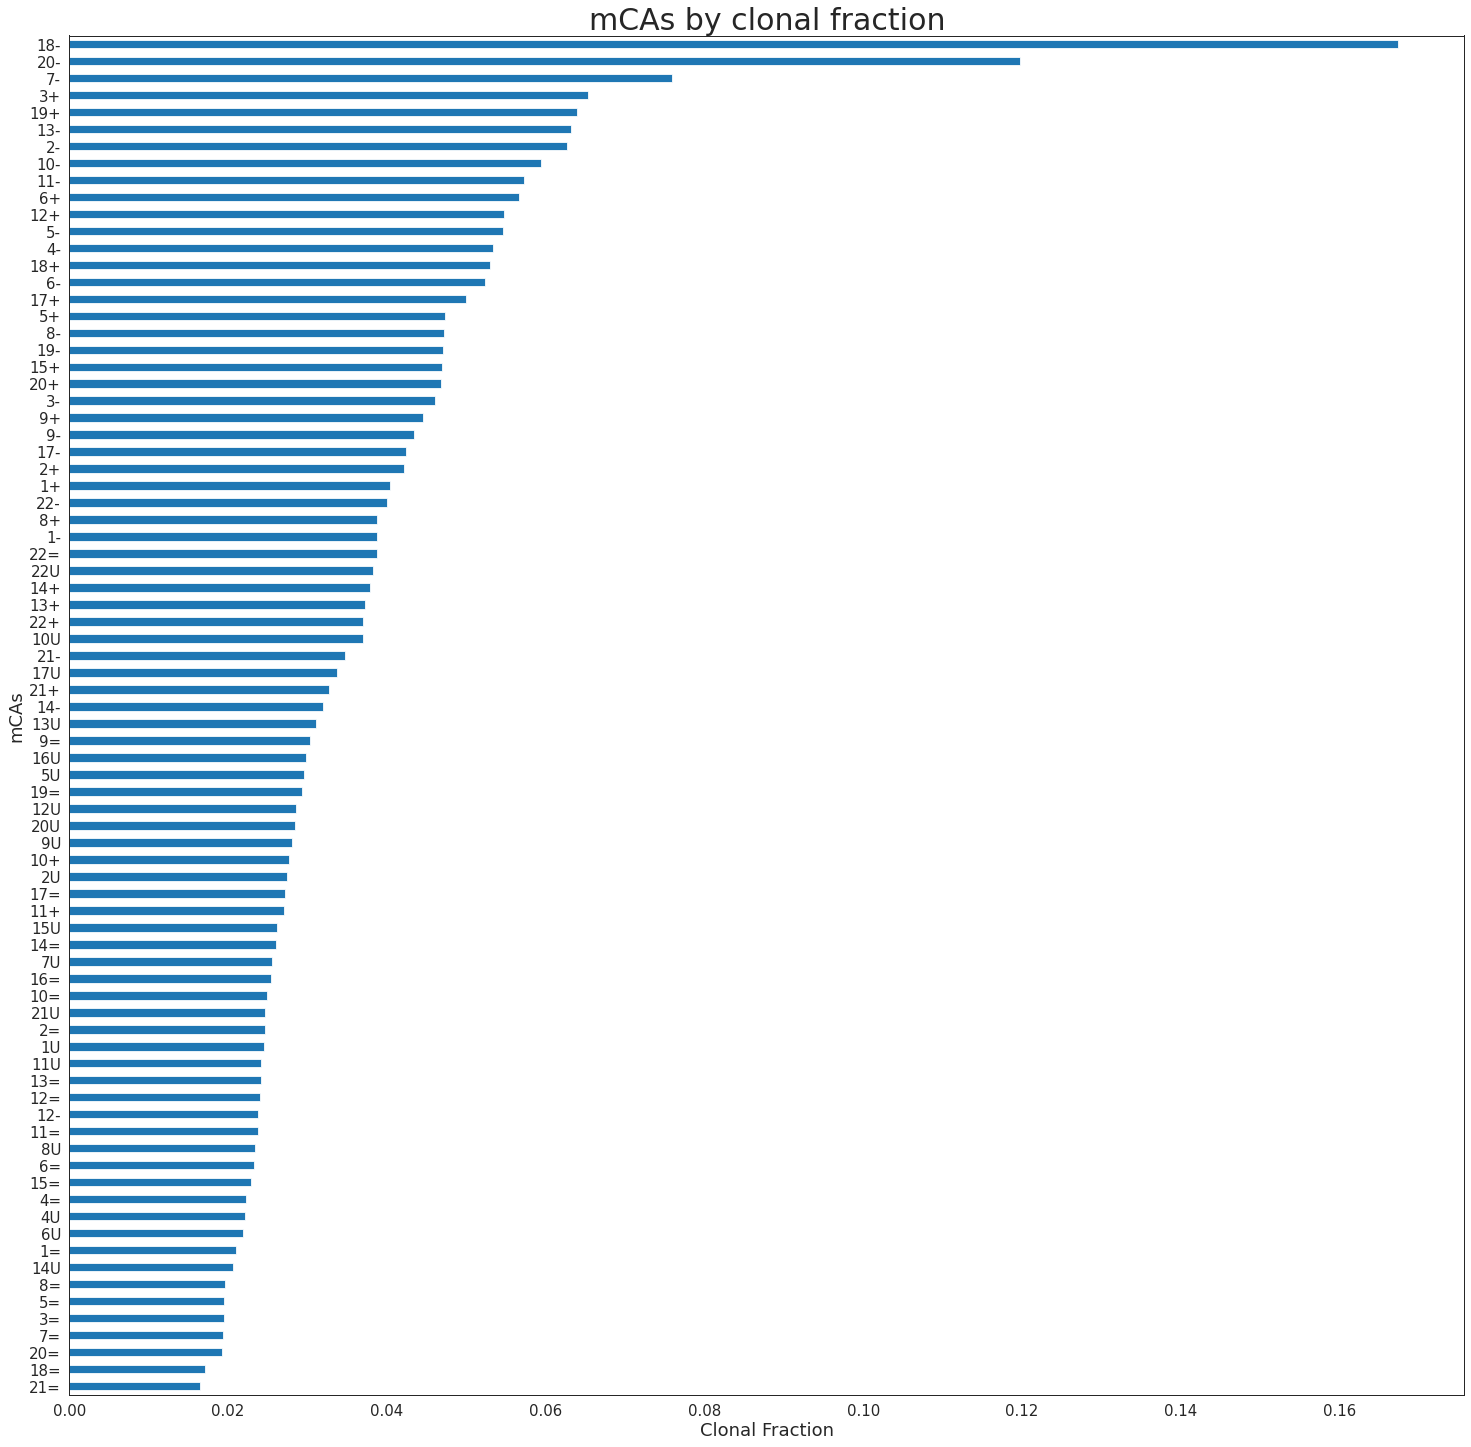

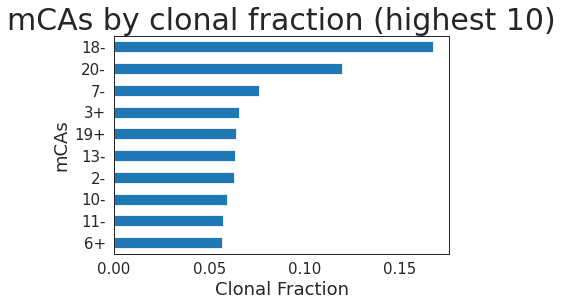

In [45]:
mca_cf_summary = mocha_df_nochrx.groupby('mca_short').describe()['cf']

mca_cf_summary = mca_cf_summary[mca_cf_summary['count']>10]
mca_cf_summary = mca_cf_summary.sort_values(by=['50%'], ascending = False)
mca_cf_summary = mca_cf_summary.reset_index(level=0)

mca_cf_summary.sort_values(by=['50%'], ascending = True).plot(kind='barh', y='50%', x='mca_short', figsize=(25,25), 
                                      fontsize=20, legend=False)
plt.title("mCAs by clonal fraction", fontsize=30)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel("Clonal Fraction", fontsize=18)
plt.ylabel("mCAs", fontsize=18)
plt.show()

mca_cf_summary.head(10).sort_values(by=['50%'], ascending = True).plot(kind='barh', y='50%', x='mca_short',
                                      legend=False)
plt.title("mCAs by clonal fraction (highest 10)", fontsize=30)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel("Clonal Fraction", fontsize=18)
plt.ylabel("mCAs", fontsize=18)
plt.show()

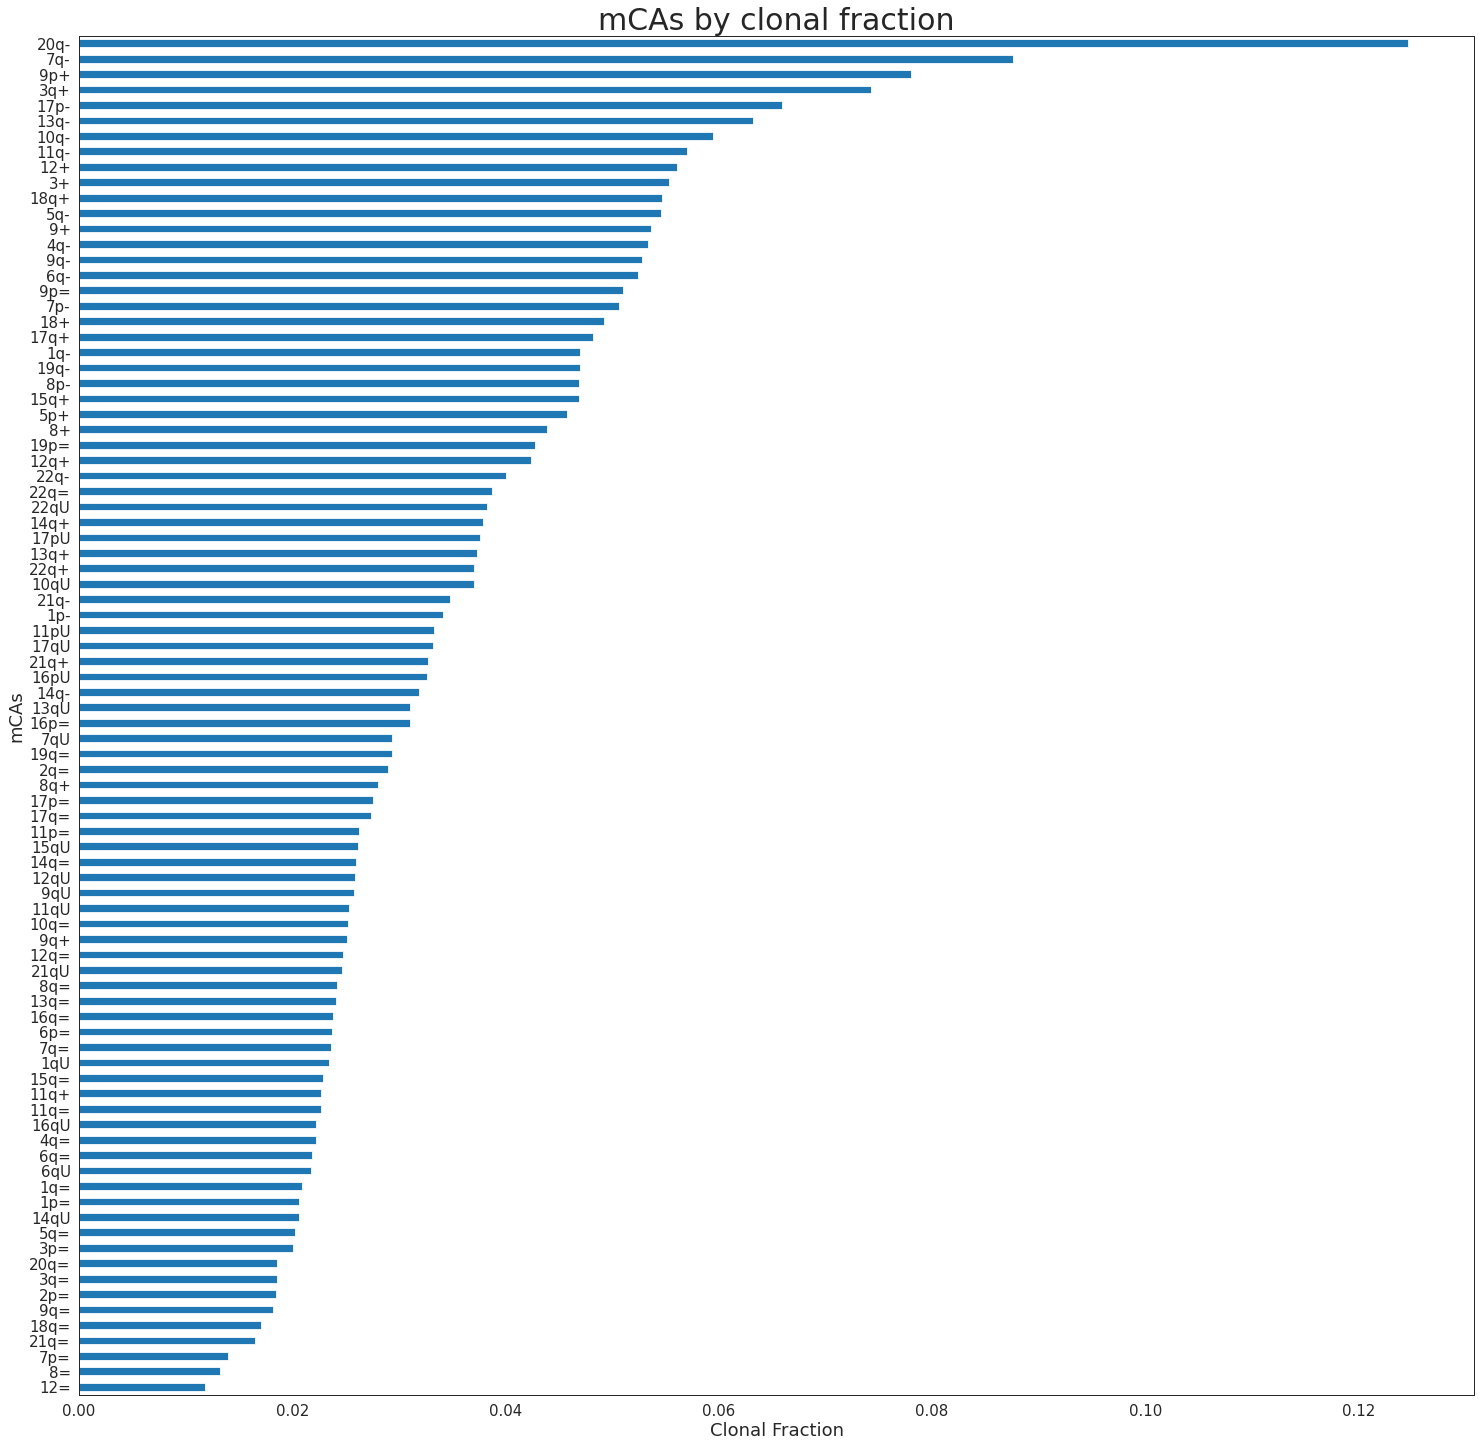

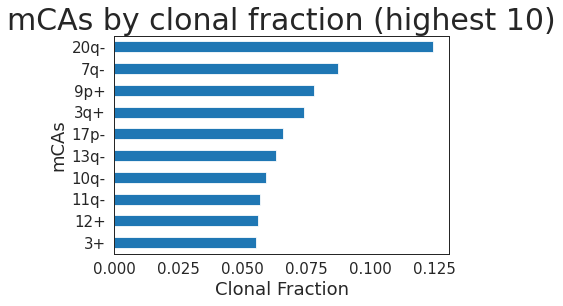

In [52]:
mca_cf_summary = mocha_df_nochrx.groupby('mca_short_arm').describe()['cf']

mca_cf_summary = mca_cf_summary[mca_cf_summary['count']>10]
mca_cf_summary = mca_cf_summary.sort_values(by=['50%'], ascending = False)
mca_cf_summary = mca_cf_summary.reset_index(level=0)

mca_cf_summary.sort_values(by=['50%'], ascending = True).plot(kind='barh', y='50%', x='mca_short_arm', figsize=(25,25), 
                                      fontsize=20, legend=False)
plt.title("mCAs by clonal fraction", fontsize=30)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel("Clonal Fraction", fontsize=18)
plt.ylabel("mCAs", fontsize=18)
plt.show()

mca_cf_summary.head(10).sort_values(by=['50%'], ascending = True).plot(kind='barh', y='50%', x='mca_short_arm',
                                      legend=False)
plt.title("mCAs by clonal fraction (highest 10)", fontsize=30)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel("Clonal Fraction", fontsize=18)
plt.ylabel("mCAs", fontsize=18)
plt.show()

## Assessing overlap by sample ids

In [53]:
overlap = len(set(passenger_df['sample.id']).intersection(set(mocha_df['sample_id'])))/len(set(mocha_df['sample_id']))
print(str(len(set(passenger_df['sample.id']).intersection(set(mocha_df['sample_id'])))) + 
      " out of " + str(len(set(mocha_df['sample_id']))) + " (" + str(round(overlap*100,2)) + "%) of the patients with a mCA had a passenger rate available")

7693 out of 8517 (90.33%) of the patients with a mCA had a passenger rate available


In [54]:
overlap = len(set(passenger_df['sample.id']).intersection(set(mocha_df_nochrx['sample_id'])))/len(set(mocha_df_nochrx['sample_id']))
print(str(len(set(passenger_df['sample.id']).intersection(set(mocha_df_nochrx['sample_id'])))) + 
      " out of " + str(len(set(mocha_df_nochrx['sample_id']))) + " (" + str(round(overlap*100,2)) + "%) of the patients with a mCA had a passenger rate available excluding chrX")

2766 out of 3068 (90.16%) of the patients with a mCA had a passenger rate available excluding chrX


# Merging the datasets (excluding pts with more than 1 mCA)

In [55]:
def merge_datasets(df):
    mocha_dict_by_id = defaultdict(set)
    mocha_dict_by_id_short = defaultdict(set)
    mocha_dict_by_id_arm_short = defaultdict(set)
    mocha_cf_dict = dict()

    for index, row in df.iterrows():
        mca = str(row['type'] + " in " + row['chrom'])
        mocha_dict_by_id[row['sample_id']].add(mca)
        mocha_dict_by_id_short[row['sample_id']].add(row['mca_short'])
        mocha_dict_by_id_arm_short[row['sample_id']].add(row['mca_short_arm'])
        mocha_cf_dict[row['sample_id']] = row['cf']
    
    more_than_one_mca = 0
    keys = []
    mcas = []
    mcas_short = []
    cfs = []
    mcas_short_arm = []
    single_mca_enrichment = []
    mult_mca_enrichment = []
    for key, value in mocha_dict_by_id.items():
        if len(value) < 2:
            single_mca_enrichment.append(list(value)[0])
            keys.append(key)
            mcas.append(', '.join(value))
            mcas_short.append(','.join(mocha_dict_by_id_short[key]))
            cfs.append(mocha_cf_dict[key])
            mcas_short_arm.append(', '. join(mocha_dict_by_id_arm_short[key]))
        else: 
            more_than_one_mca = more_than_one_mca+1
            mult_mca_enrichment.extend(value)


    mca_string_df = pd.DataFrame(zip(keys,mcas,mcas_short,cfs, mcas_short_arm), 
                                 columns = ['sample.id', 'mCAs','mCA', 'cf', 'mCA w arm'])
    
    mca_pacer_df = passenger_df.merge(mca_string_df, on="sample.id")
    
    mca_pacer_df['Autosomal'] = "Autosomal"
    mca_pacer_df.loc[mca_pacer_df['mCAs'].str.contains("chrX"),'Autosomal'] = "chrX"
    mca_pacer_df['Autosomal Type'] = ""
    mca_pacer_df.loc[mca_pacer_df['mCAs'].str.contains("Loss"),'Autosomal Type'] = "Loss"
    mca_pacer_df.loc[mca_pacer_df['mCAs'].str.contains("Undetermined"),'Autosomal Type'] = "Undetermined"
    mca_pacer_df.loc[mca_pacer_df['mCAs'].str.contains("Gain"),'Autosomal Type'] = "Gain"
    mca_pacer_df.loc[mca_pacer_df['mCAs'].str.contains("CN-LOH"),'Autosomal Type'] = "CN-LOH"
    mca_pacer_df.loc[mca_pacer_df['mCAs'].str.contains("chrX"),'Autosomal Type'] = "chrX"
    
    print(str(more_than_one_mca) + " pts had > 1 mCA and were thus excluded")
       
    return mca_pacer_df, single_mca_enrichment, mult_mca_enrichment

In [56]:
# mca_pacer_df, mca_pacer_df_nochip, mca_pacer_df_onlychip = merge_datasets(mocha_df)
mca_pacer_df, single_mca_enrichment, mult_mca_enrichment = merge_datasets(mocha_df)

763 pts had > 1 mCA and were thus excluded


In [57]:
# mca_pacer_nochrx_df, mca_pacer_nochrx_df_nochip, mca_pacer_nochrx_df_onlychip = merge_datasets(mocha_df_nochrx)
mca_pacer_nochrx_df, single_mca_enrichment_nochrX, mult_mca_enrichment_nochrX = merge_datasets(mocha_df_nochrx)

376 pts had > 1 mCA and were thus excluded


In [58]:
single_mca_enrichment_nochrX = [x for x in single_mca_enrichment_nochrX if "Undetermined" not in x]
mult_mca_enrichment_nochrX = [x for x in mult_mca_enrichment_nochrX if "Undetermined" not in x]

In [59]:
single_mca_enrichment_nochrX_df = pd.DataFrame.from_dict(Counter(single_mca_enrichment_nochrX).items())
mult_mca_enrichment_nochrX_df = pd.DataFrame.from_dict(Counter(mult_mca_enrichment_nochrX).items())

In [60]:
mult_mca_enrichment = []
single_tot = single_mca_enrichment_nochrX_df[1].sum()
mult_tot = mult_mca_enrichment_nochrX_df[1].sum()

for index, row in single_mca_enrichment_nochrX_df.iterrows():
    single_mca = row[1]
    mult_mca = mult_mca_enrichment_nochrX_df.iloc[index, 1]
    single_notmca = single_tot - single_mca
    mult_notmca = mult_tot - mult_mca
    table = np.array([[single_mca, single_notmca], [mult_mca, mult_notmca]])
    oddsr, p = fisher_exact(table, alternative='two-sided')
    mult_mca_enrichment.append([row[0], oddsr, p])
    
multmca_enrichment_df = pd.DataFrame(mult_mca_enrichment)
multmca_enrichment_df[multmca_enrichment_df[2]<0.05/len(multmca_enrichment_df)].sort_values(1)

0         1             2
36    Gain in chr19  0.060954  1.437943e-10
32     Gain in chr4  0.070278  8.616248e-13
45    Loss in chr18  0.101179  9.237423e-05
50     Loss in chr8  0.132159  3.214076e-05
43    Gain in chr13  0.156545  1.847416e-08
34    Loss in chr17  0.251076  4.303435e-05
42     Gain in chr3  0.281004  2.453942e-04
33     Loss in chr6  0.291352  8.462920e-05
1      Loss in chr5  0.340763  4.292936e-09
13  CN-LOH in chr10  0.355213  4.038051e-05
24   CN-LOH in chr9  2.830553  1.116446e-05
28  CN-LOH in chr12  4.043252  5.551577e-04
20   CN-LOH in chr1  5.038341  9.142733e-12
40  CN-LOH in chr17  5.585524  4.363876e-04
16    Loss in chr20  5.896217  1.036994e-08
3   CN-LOH in chr11  5.967814  4.852586e-13

In [61]:
mca_pacer_df.to_csv('pacer_covadj_forGWAS_yp_aug9.tsv', header = True, index = False, sep='\t')

In [62]:
! gsutil cp pacer_covadj_forGWAS_yp_aug9.tsv gs://fc-secure-5b07e482-3fba-4b8f-8644-2006ecf17036/Hannahs_Folder/pacer_covadj_forGWAS_yp_aug9.tsv

Copying file://pacer_covadj_forGWAS_yp_aug9.tsv [Content-Type=text/tab-separated-values]...
/ [1 files][469.0 KiB/469.0 KiB]                                                
Operation completed over 1 objects/469.0 KiB.                                    


In [63]:
! gsutil cp pacer_covadj_forGWAS_yp_aug9.tsv gs://fc-secure-827e3d9c-02b8-499f-91af-c2142b7d2074/mCA_pacer/pacer_covadj_forGWAS_yp_aug9.tsv

Copying file://pacer_covadj_forGWAS_yp_aug9.tsv [Content-Type=text/tab-separated-values]...
/ [1 files][469.0 KiB/469.0 KiB]                                                
Operation completed over 1 objects/469.0 KiB.                                    


## Adjusting for covariates by calculating the residuals of the regression of total passenger mutations with age and sex

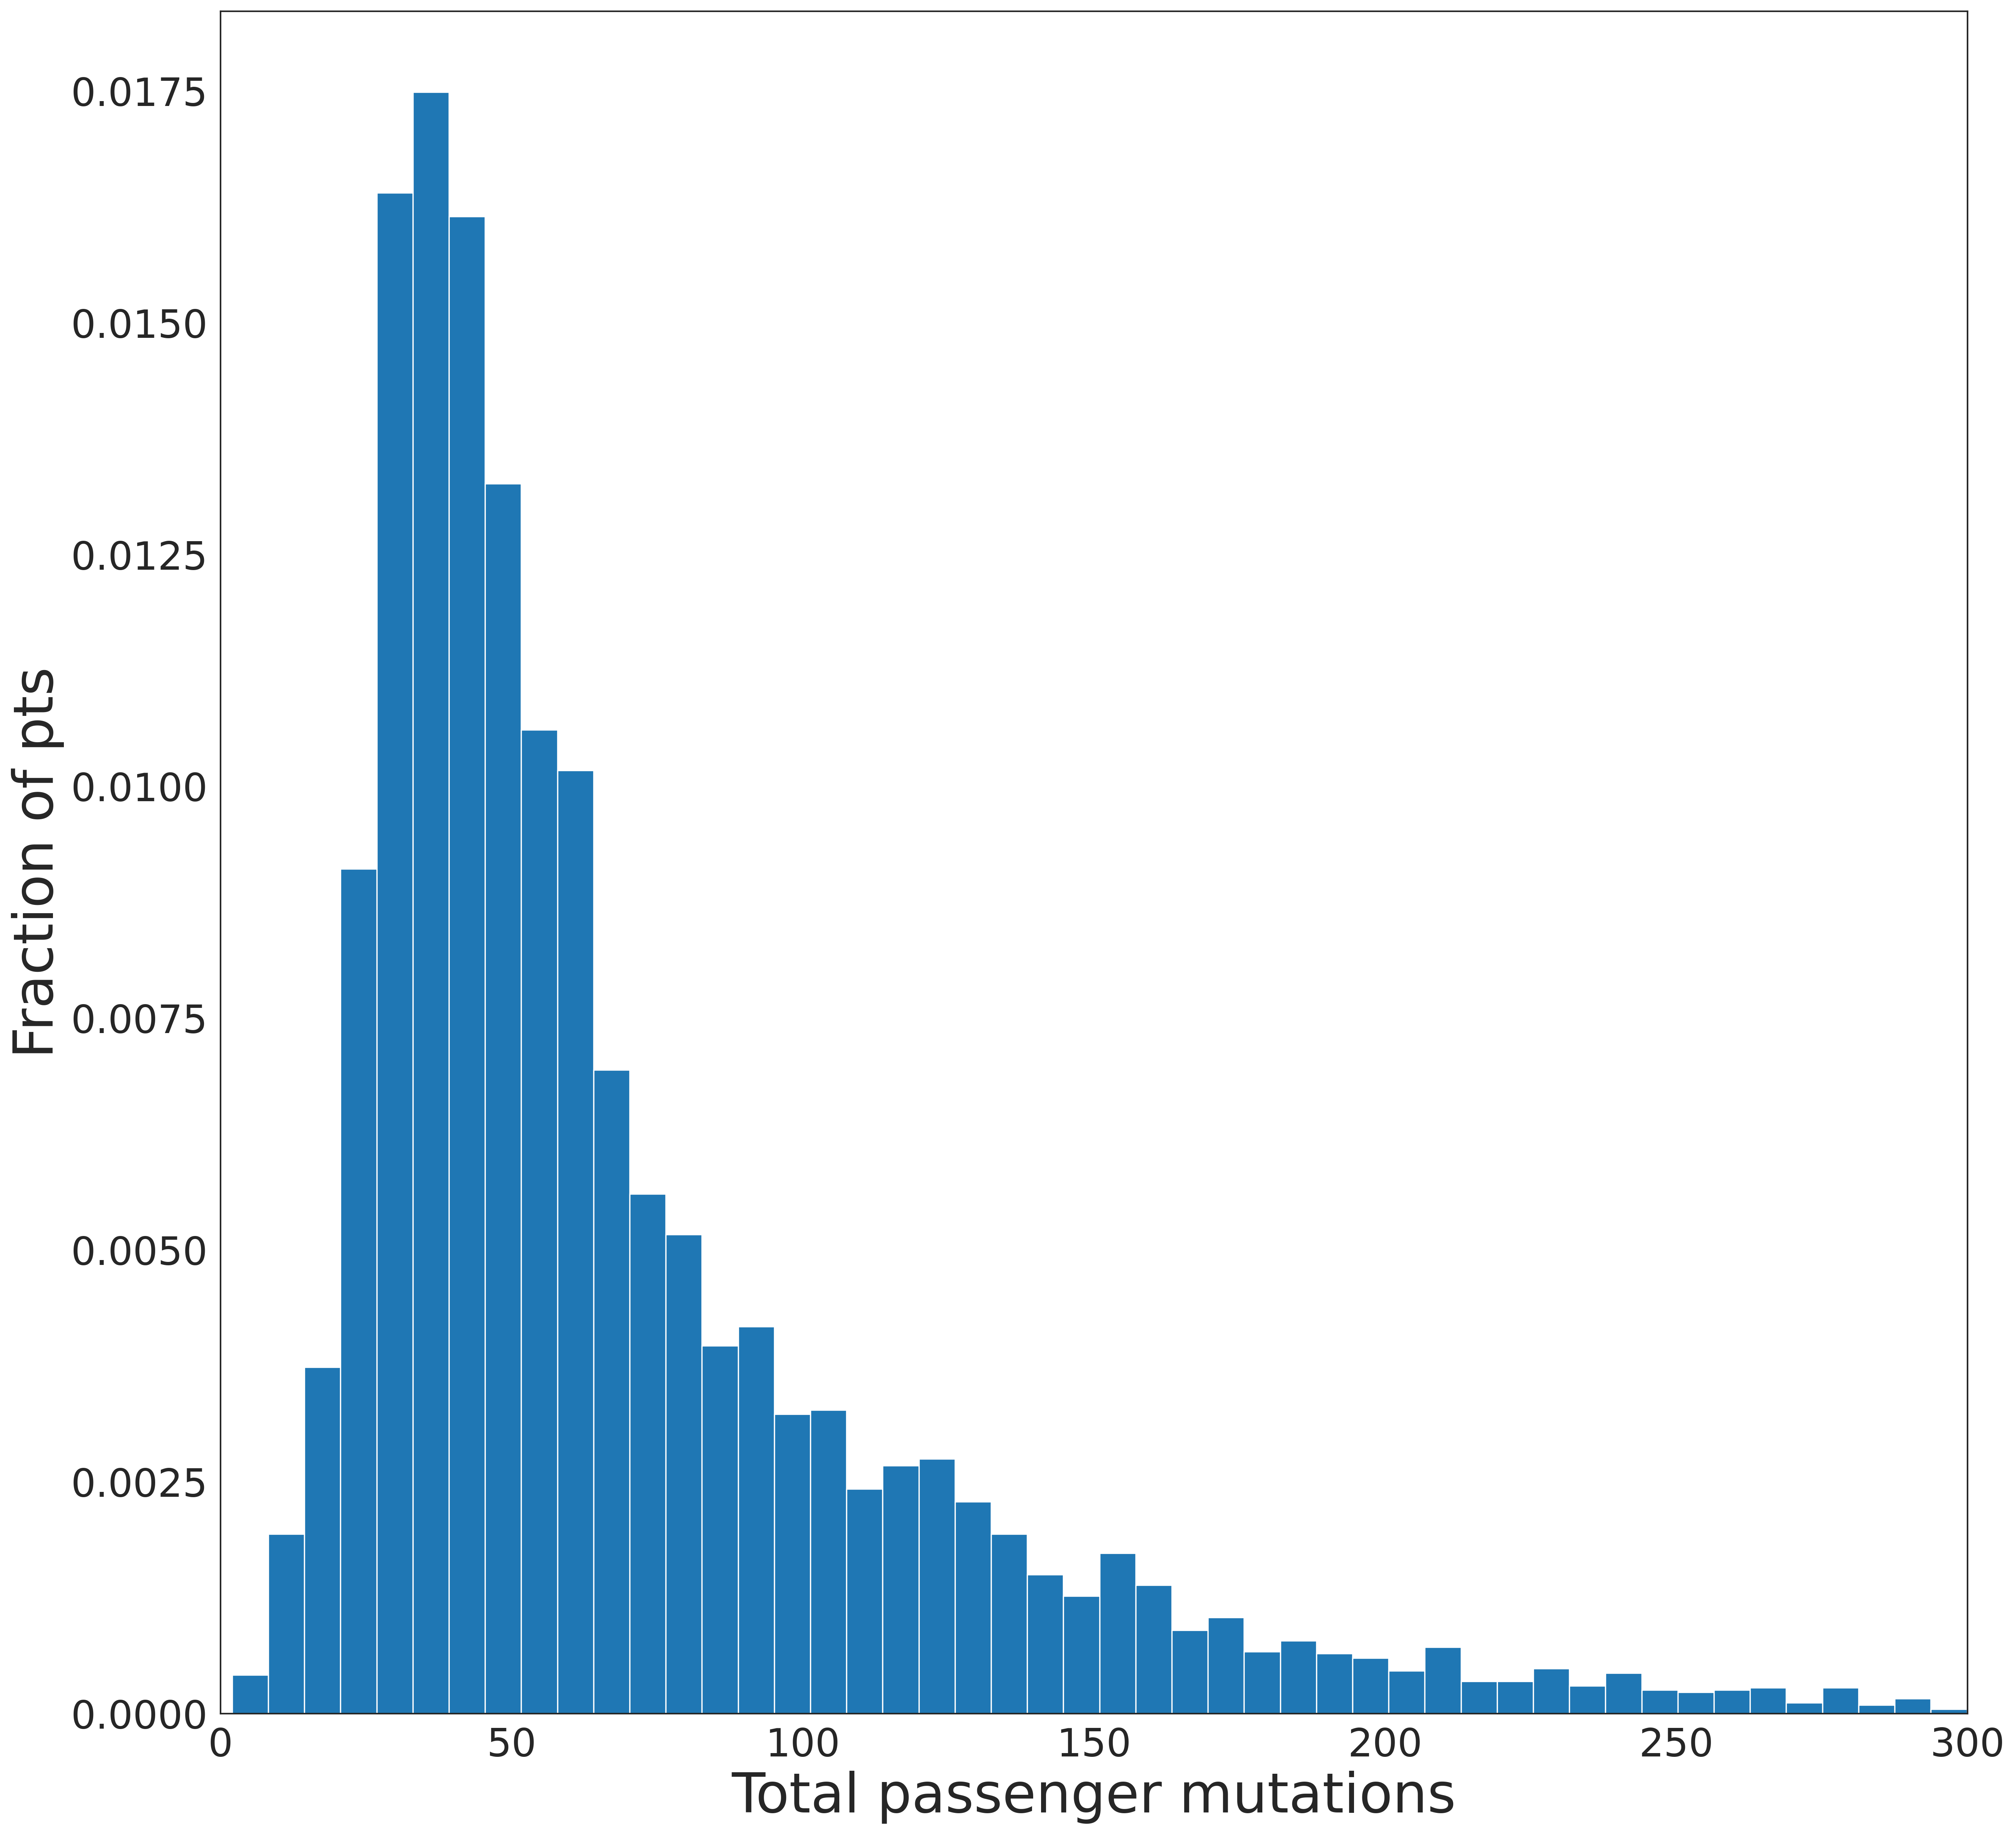

Min: 2
Max: 933
Median: 53.0


In [68]:
plt.figure(dpi=300, figsize=(20,20))
plt.hist(mca_pacer_df['total_pass_mut'], density = True, bins = 150)
plt.ylabel('Fraction of pts', fontsize=35)
plt.xlabel('Total passenger mutations', fontsize=35)
# plt.title("Histogram of total passenger mutations")
plt.xlim(0,300)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.savefig('fig2a_histofpassmut.tif', dpi=300)
plt.show()
print("Min: " + str(min(mca_pacer_df['total_pass_mut'])))
print("Max: " + str(max(mca_pacer_df['total_pass_mut'])))
print("Median: " + str(stats.median(mca_pacer_df['total_pass_mut'])))

In [69]:
! gsutil cp fig2a_histofpassmut.tif gs://fc-secure-827e3d9c-02b8-499f-91af-c2142b7d2074/mCA_pacer/figures/fig2a_histofpassmut.tif

Copying file://fig2a_histofpassmut.tif [Content-Type=image/tiff]...
\ [1 files][137.3 MiB/137.3 MiB]                                                
Operation completed over 1 objects/137.3 MiB.                                    


Source on using residuals to correct for covariates: https://www.middleprofessor.com/files/applied-biostatistics_bookdown/_book/adding-covariates-to-a-linear-model.html  

In [70]:
reg = LinearRegression().fit(mca_pacer_df[['age', 'sex_dummy', 'chip_case', 'cf']].to_numpy(), mca_pacer_df['total_pass_mut'].to_numpy())
y_pred = reg.predict(mca_pacer_df[['age', 'sex_dummy', 'chip_case', 'cf']].to_numpy())
residuals = mca_pacer_df['total_pass_mut'].to_numpy()- np.array(y_pred)

### Histogram of residuals

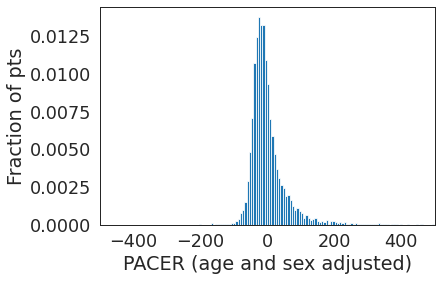

Min: -203.27249794298154
Max: 808.2448249774586
Median: -12.166023734214548


In [71]:
plt.hist(residuals, bins=150, density=True)
plt.xlim(-500,500)
plt.ylabel('Fraction of pts')
plt.xlabel('PACER (age and sex adjusted)')
plt.show()
print("Min: " + str(min(residuals)))
print("Max: " + str(max(residuals)))
print("Median: " + str(stats.median(residuals)))
plt.show()

### Performing a Yeo-Johnson transformation (inverse normal transformation) of the residuals

Theory behind INT and YJT 
- https://cran.r-project.org/web/packages/RNOmni/vignettes/RNOmni.html#inverse-normal-transformation (theory on INT)
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.yeojohnson.html#scipy.stats.yeojohnson (scipy implementation of YJT)

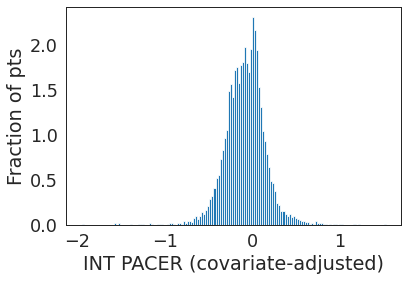

Min: -415.17966672538313
Max: 325.30286807101623
Median: -16.340342022866906


In [72]:
residuals_t, lmbda = yeojohnson(residuals)
residuals_t_norm = normalize([residuals_t])
plt.hist((np.array(residuals_t_norm)*20).flatten(), bins=150, density=True)
plt.ylabel('Fraction of pts')
plt.xlabel('INT PACER (covariate-adjusted)')
plt.show()
print("Min: " + str(min(residuals_t)))
print("Max: " + str(max(residuals_t)))
print("Median: " + str(stats.median(residuals_t)))
plt.show()

In [73]:
mca_pacer_df['pacer_covadj_int'] = residuals_t

In [74]:
mca_pacer_df['pacer_covadj_int_norm'] = (np.array(residuals_t_norm)*20).flatten()

In [75]:
pacer_dict = pd.Series(mca_pacer_df.pacer_covadj_int_norm.values,index=mca_pacer_df['sample.id']).to_dict()

In [76]:
mca_pacer_nochrx_df = mca_pacer_df[~mca_pacer_df['mCA w arm'].str.contains("X")]

In [77]:
mca_pacer_df_nochip = mca_pacer_df[mca_pacer_df['chip_case'] == False]
mca_pacer_df_onlychip = mca_pacer_df[mca_pacer_df['chip_case'] == True]

mca_pacer_nochrx_df_nochip = mca_pacer_nochrx_df[mca_pacer_nochrx_df['chip_case'] == False]
mca_pacer_nochrx_df_onlychip = mca_pacer_nochrx_df[mca_pacer_nochrx_df['chip_case'] == True]

In [78]:
mca_pacer_df_nochip.to_csv('pacer_covadj_forGWAS_nochip_yp_aug12.tsv', header = True, index = False, sep='\t')

In [79]:
! gsutil cp pacer_covadj_forGWAS_nochip_yp_aug12.tsv gs://fc-secure-5b07e482-3fba-4b8f-8644-2006ecf17036/Hannahs_Folder/pacer_covadj_forGWAS_nochip_yp_aug12.tsv

Copying file://pacer_covadj_forGWAS_nochip_yp_aug12.tsv [Content-Type=text/tab-separated-values]...
/ [1 files][674.6 KiB/674.6 KiB]                                                
Operation completed over 1 objects/674.6 KiB.                                    


In [80]:
! gsutil cp pacer_covadj_forGWAS_nochip_yp_aug12.tsv gs://fc-secure-827e3d9c-02b8-499f-91af-c2142b7d2074/mCA_pacer/pacer_covadj_forGWAS_nochip_yp_aug12.tsv

Copying file://pacer_covadj_forGWAS_nochip_yp_aug12.tsv [Content-Type=text/tab-separated-values]...
/ [1 files][674.6 KiB/674.6 KiB]                                                
Operation completed over 1 objects/674.6 KiB.                                    


# Which mCAs have the highest number of total passenger mutations for all pts, for patients without CHIP, and for patients with CHIP?


In [81]:
def get_mca_pacer_pairs(df, col, removeUndetermined = True):
    if removeUndetermined:
        df = df[~df['mCA'].str.contains("U")]
    mcas_pacerscore_summary = df.groupby(col).describe()['pacer_covadj_int']
    mcas_pacerscore_summary_filtered = mcas_pacerscore_summary[mcas_pacerscore_summary['count']>10]
    mcas_pacerscore_summary_filtered = mcas_pacerscore_summary_filtered.sort_values(by=['50%'], ascending = False)
    mcas_pacerscore_summary_filtered = mcas_pacerscore_summary_filtered.reset_index(level=0)
    mcas_pacerscore_summary_filtered.sort_values(by=['50%'], ascending = True).plot(kind='barh', y='50%', x=col, figsize=(25,25), 
                                          fontsize=20, legend=False)
    plt.title("INT PACER (age and sex adjusted) by mCA - " + col, fontsize=30)
    plt.show()
    mcas_pacerscore_summary_filtered.head(10).sort_values(by=['50%'], ascending = True).plot(kind='barh', y='50%', x=col,
                                          legend=False)
    plt.title("INT PACER (age and sex adjusted) by mCA (highest 10) - " + col)
    plt.show()
    return mcas_pacerscore_summary_filtered.head(10)

In [82]:
def get_mca_pacer_pairs_violin(df, col):
    print(df.groupby(col).describe()['pacer_covadj_int_norm']['50%'])
    print(df.groupby(col).describe()['pacer_covadj_int_norm']['75%'] - df.groupby(col).describe()['pacer_covadj_int_norm']['25%'])

    plt.figure(figsize=(8,6))
    ax = sns.violinplot(y="pacer_covadj_int_norm", 
                    x=col, 
                    data=df)
    plt.ylim(-2,2)
    ax.set(xlabel=col, ylabel='PACER (covariate adjusted and normalized)')
    plt.show()

Autosomal Type
CN-LOH   -0.051329
Gain     -0.060927
Loss     -0.091400
chrX     -0.079761
Name: 50%, dtype: float64
Autosomal Type
CN-LOH    0.317355
Gain      0.329954
Loss      0.341027
chrX      0.249384
dtype: float64


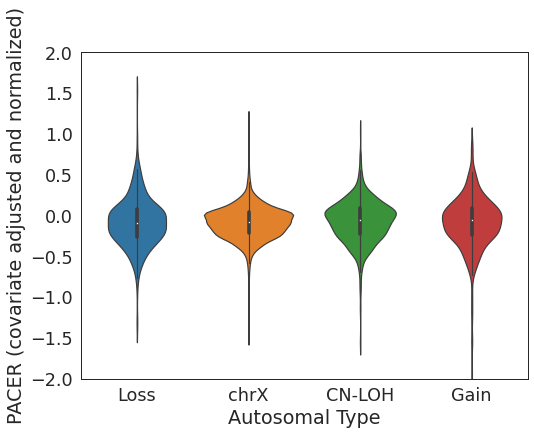

In [83]:
get_mca_pacer_pairs_violin(mca_pacer_df[mca_pacer_df['Autosomal Type'] != "Undetermined"], 'Autosomal Type')

## Including all patients

### Of mCAs with a frequency of > 10,  which mCAs have the highest passenger mutation rate?

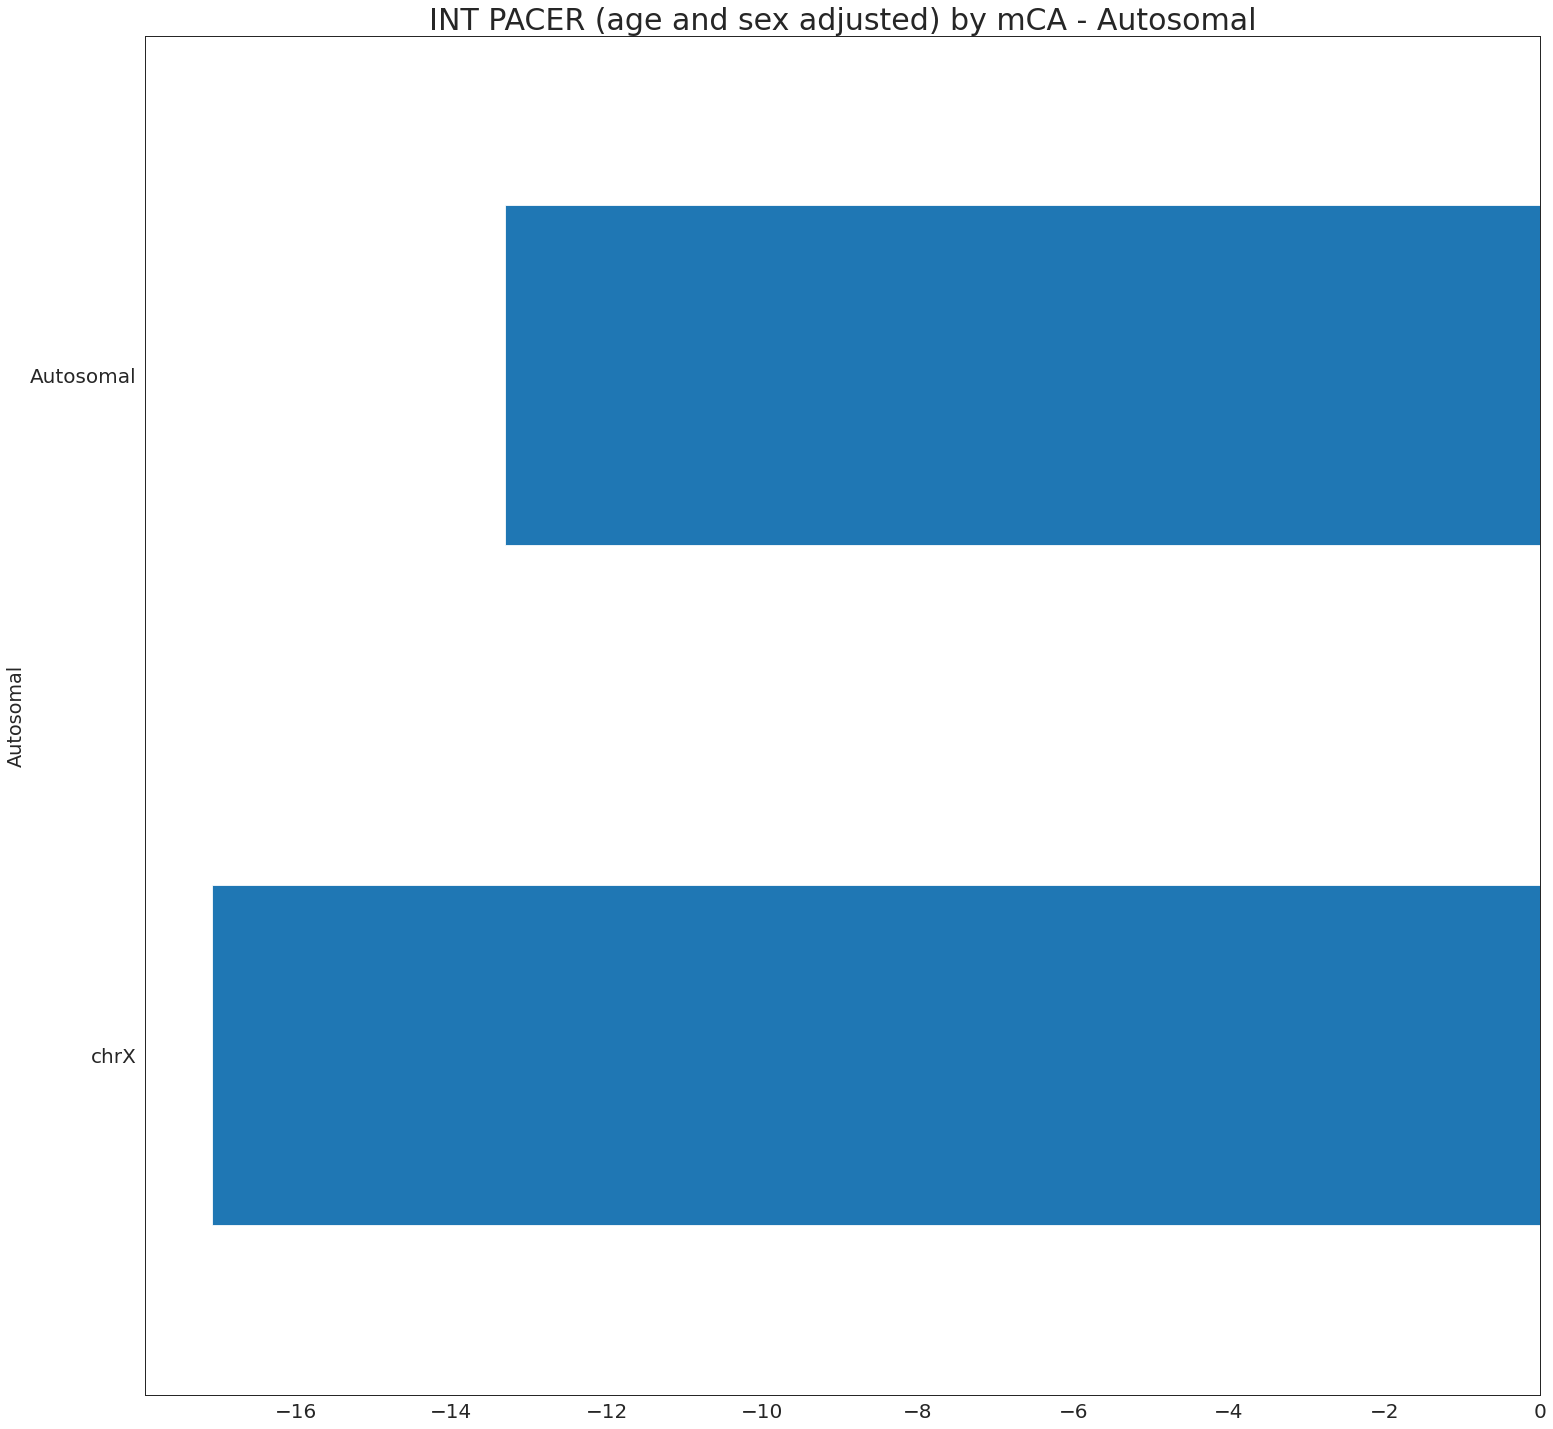

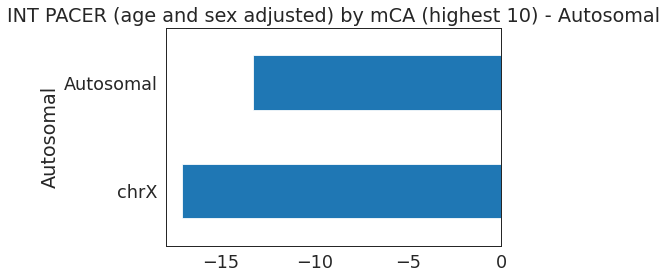

Autosomal   count       mean        std         min        25%        50%  \
0  Autosomal  1898.0 -16.371985  60.254203 -415.179667 -51.084330 -13.312525   
1       chrX  4682.0 -18.110926  41.803164 -321.950009 -45.348725 -17.082452   

         75%         max  
0  18.969631  325.302868  
1   7.875673  257.188791

In [84]:
get_mca_pacer_pairs(mca_pacer_df, 'Autosomal')

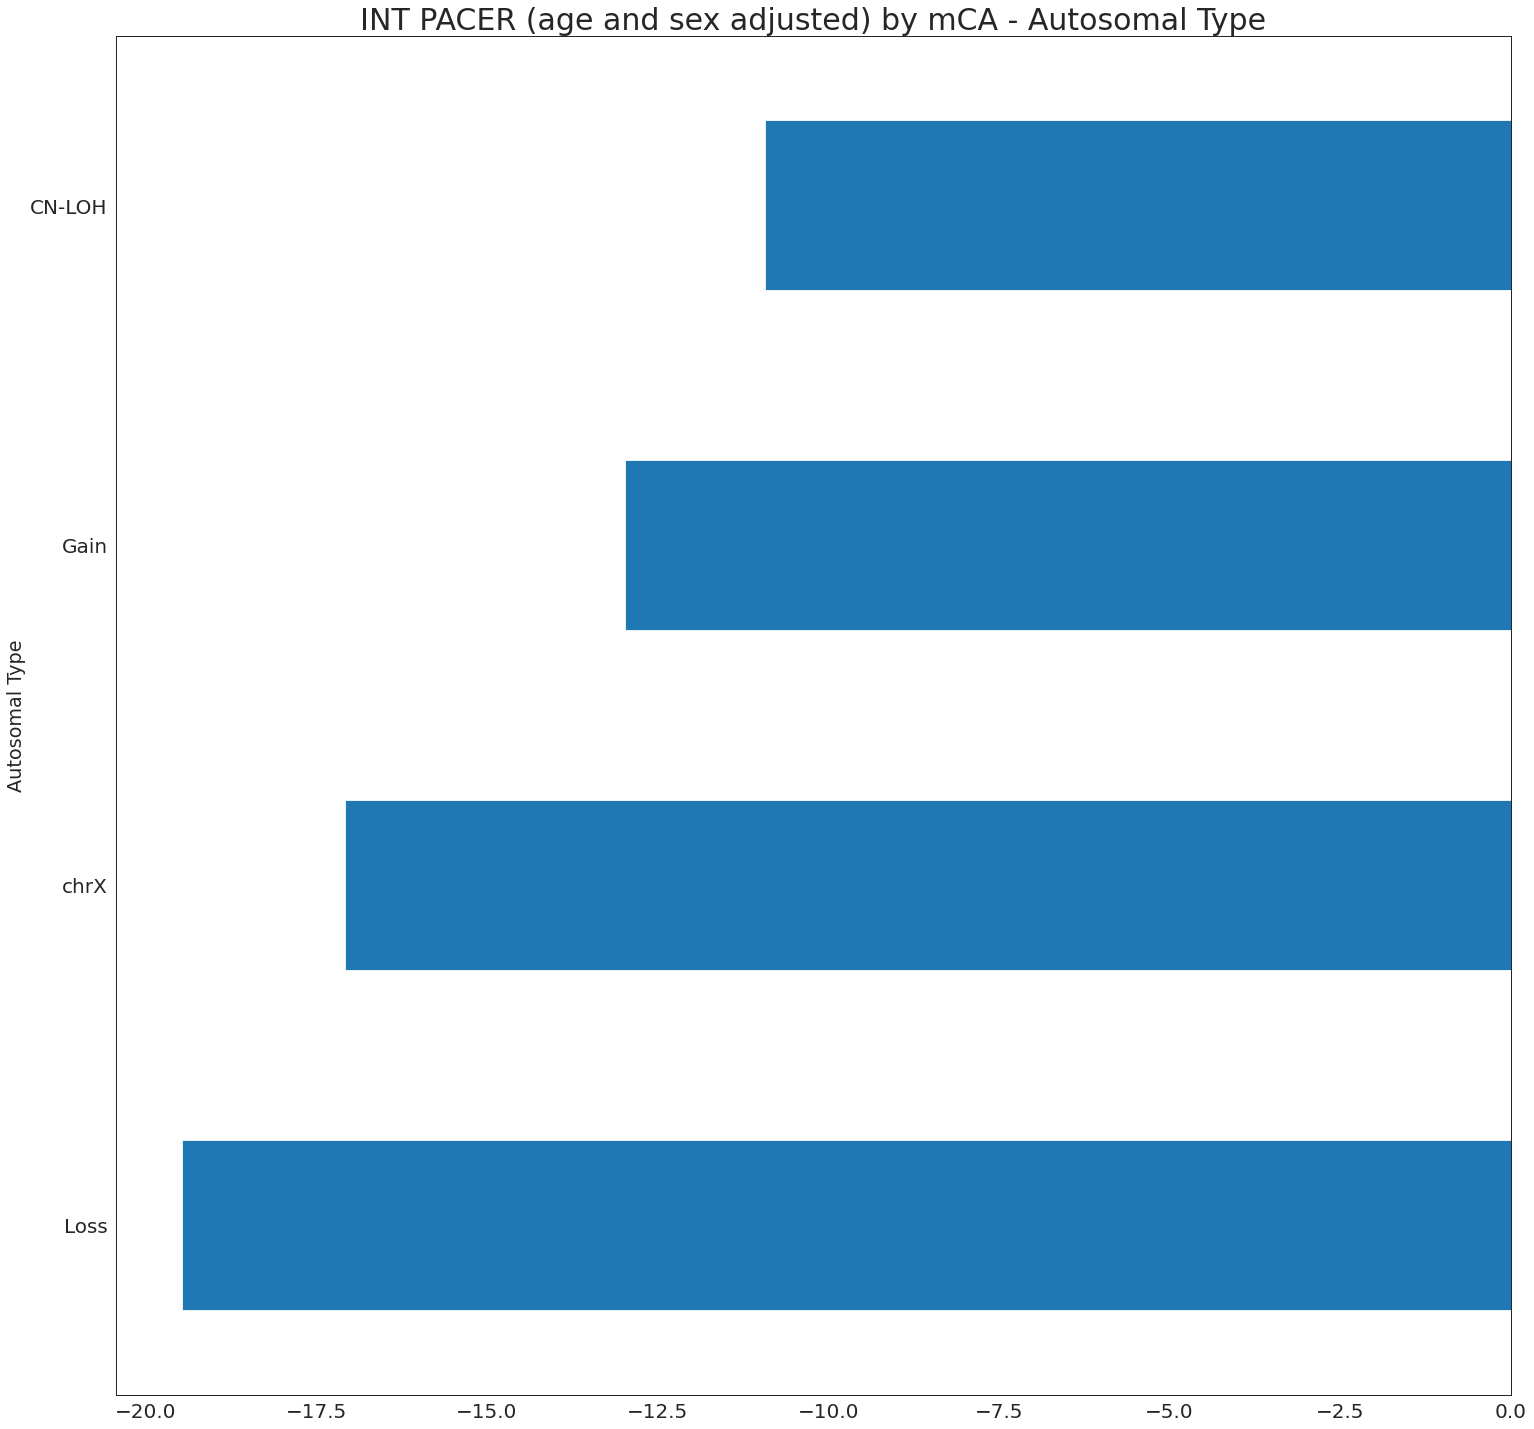

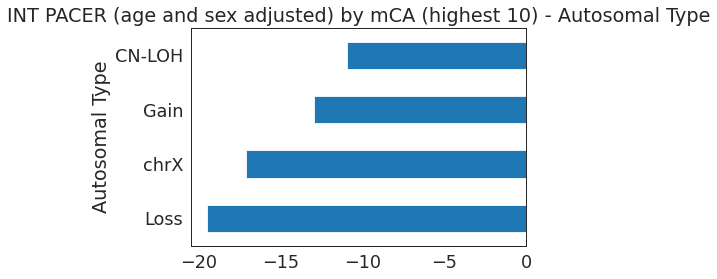

Autosomal Type   count       mean        std         min        25%  \
0         CN-LOH  1073.0 -14.884305  55.200521 -335.793776 -48.531969   
1           Gain   383.0 -18.704589  68.673878 -415.179667 -50.547144   
2           chrX  4682.0 -18.110926  41.803164 -321.950009 -45.348725   
3           Loss   442.0 -17.962241  64.128088 -293.119471 -56.252504   

         50%        75%         max  
0 -10.927879  19.032999  221.265581  
1 -12.971350  19.700130  187.915444  
2 -17.082452   7.875673  257.188791  
3 -19.459115  16.352182  325.302868

In [85]:
get_mca_pacer_pairs(mca_pacer_df[mca_pacer_df['Autosomal Type'] != "Undetermined"], 'Autosomal Type')

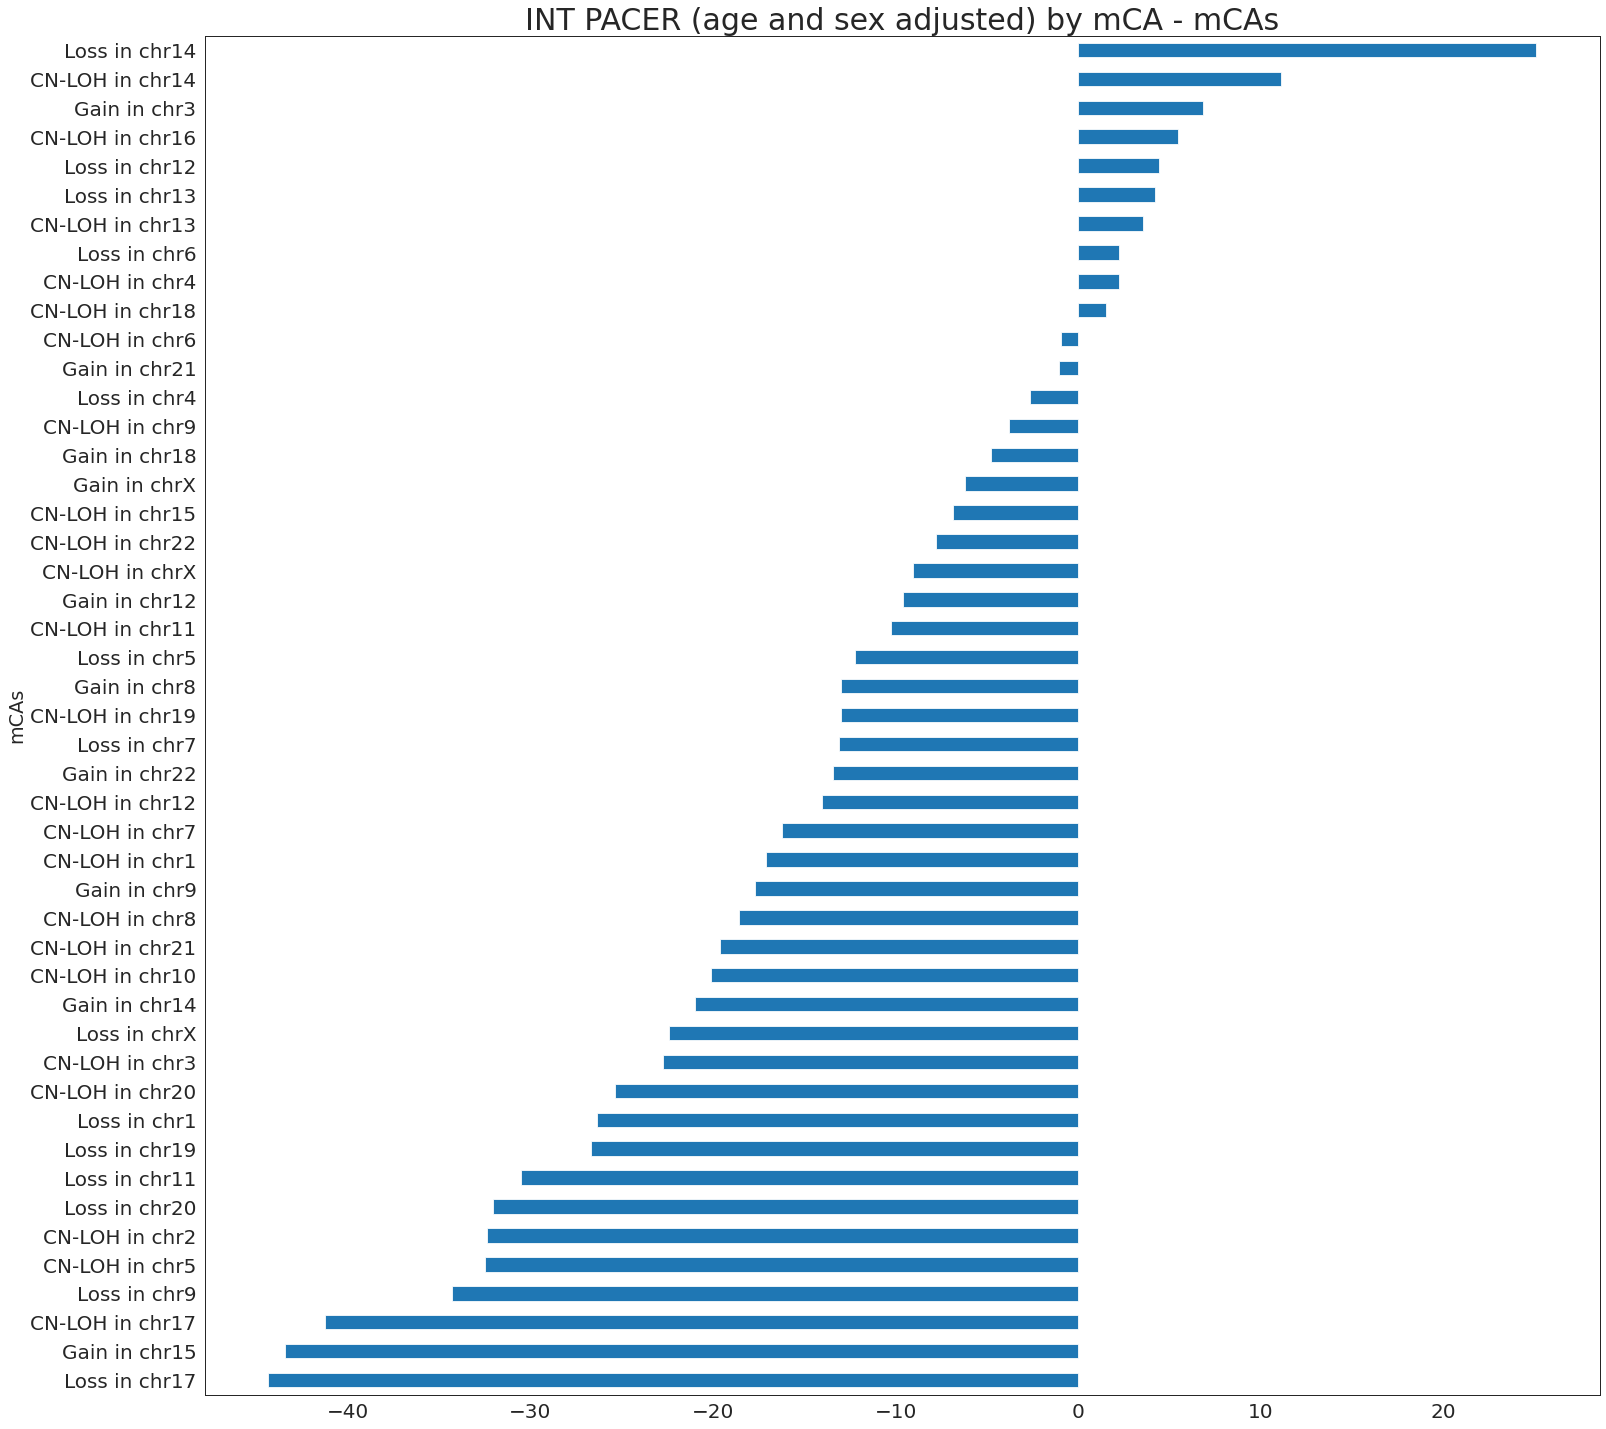

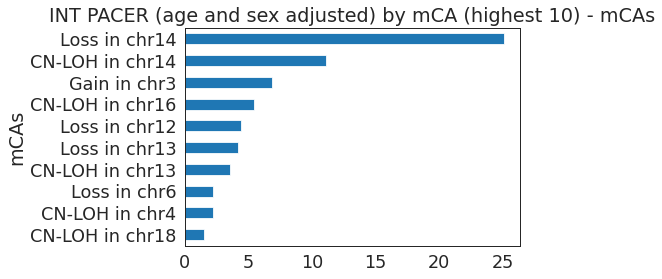

mCAs  count       mean        std         min        25%  \
0    Loss in chr14   14.0  27.496059  51.227562  -65.586602  -2.208779   
1  CN-LOH in chr14  111.0  -1.658257  66.654213 -324.524917 -29.820358   
2     Gain in chr3   11.0   4.672772  40.255038  -60.237223 -20.876172   
3  CN-LOH in chr16   45.0  -2.967338  36.393201  -83.647779 -32.191009   
4    Loss in chr12   11.0 -13.404581  90.889093 -267.109306 -21.465113   
5    Loss in chr13   50.0  12.366667  60.668105 -126.798325 -30.569190   
6  CN-LOH in chr13   46.0   6.357963  78.995860 -195.316460 -45.885179   
7     Loss in chr6   11.0  14.347648  54.614667  -76.237711 -14.871207   
8   CN-LOH in chr4   40.0   1.741494  64.733151 -115.409116 -42.320659   
9  CN-LOH in chr18   15.0 -18.107933  38.078543  -88.081223 -53.279349   

         50%        75%         max  
0  25.080024  66.473979  105.811029  
1  11.113284  36.394582  160.646477  
2   6.834470  35.593948   62.065495  
3   5.468059  20.983427   73.571421  
4   4.398262  20.599817   75.830340  
5   4.209464  41.534599  203.492851  
6   3.516525  54.399849  221.265581  
7   2.232988  61.998537   97.478769  
8   2.232808  45.585928  157.187934  
9   1.532116   9.427897   22.250044

In [86]:
get_mca_pacer_pairs(mca_pacer_df, 'mCAs')

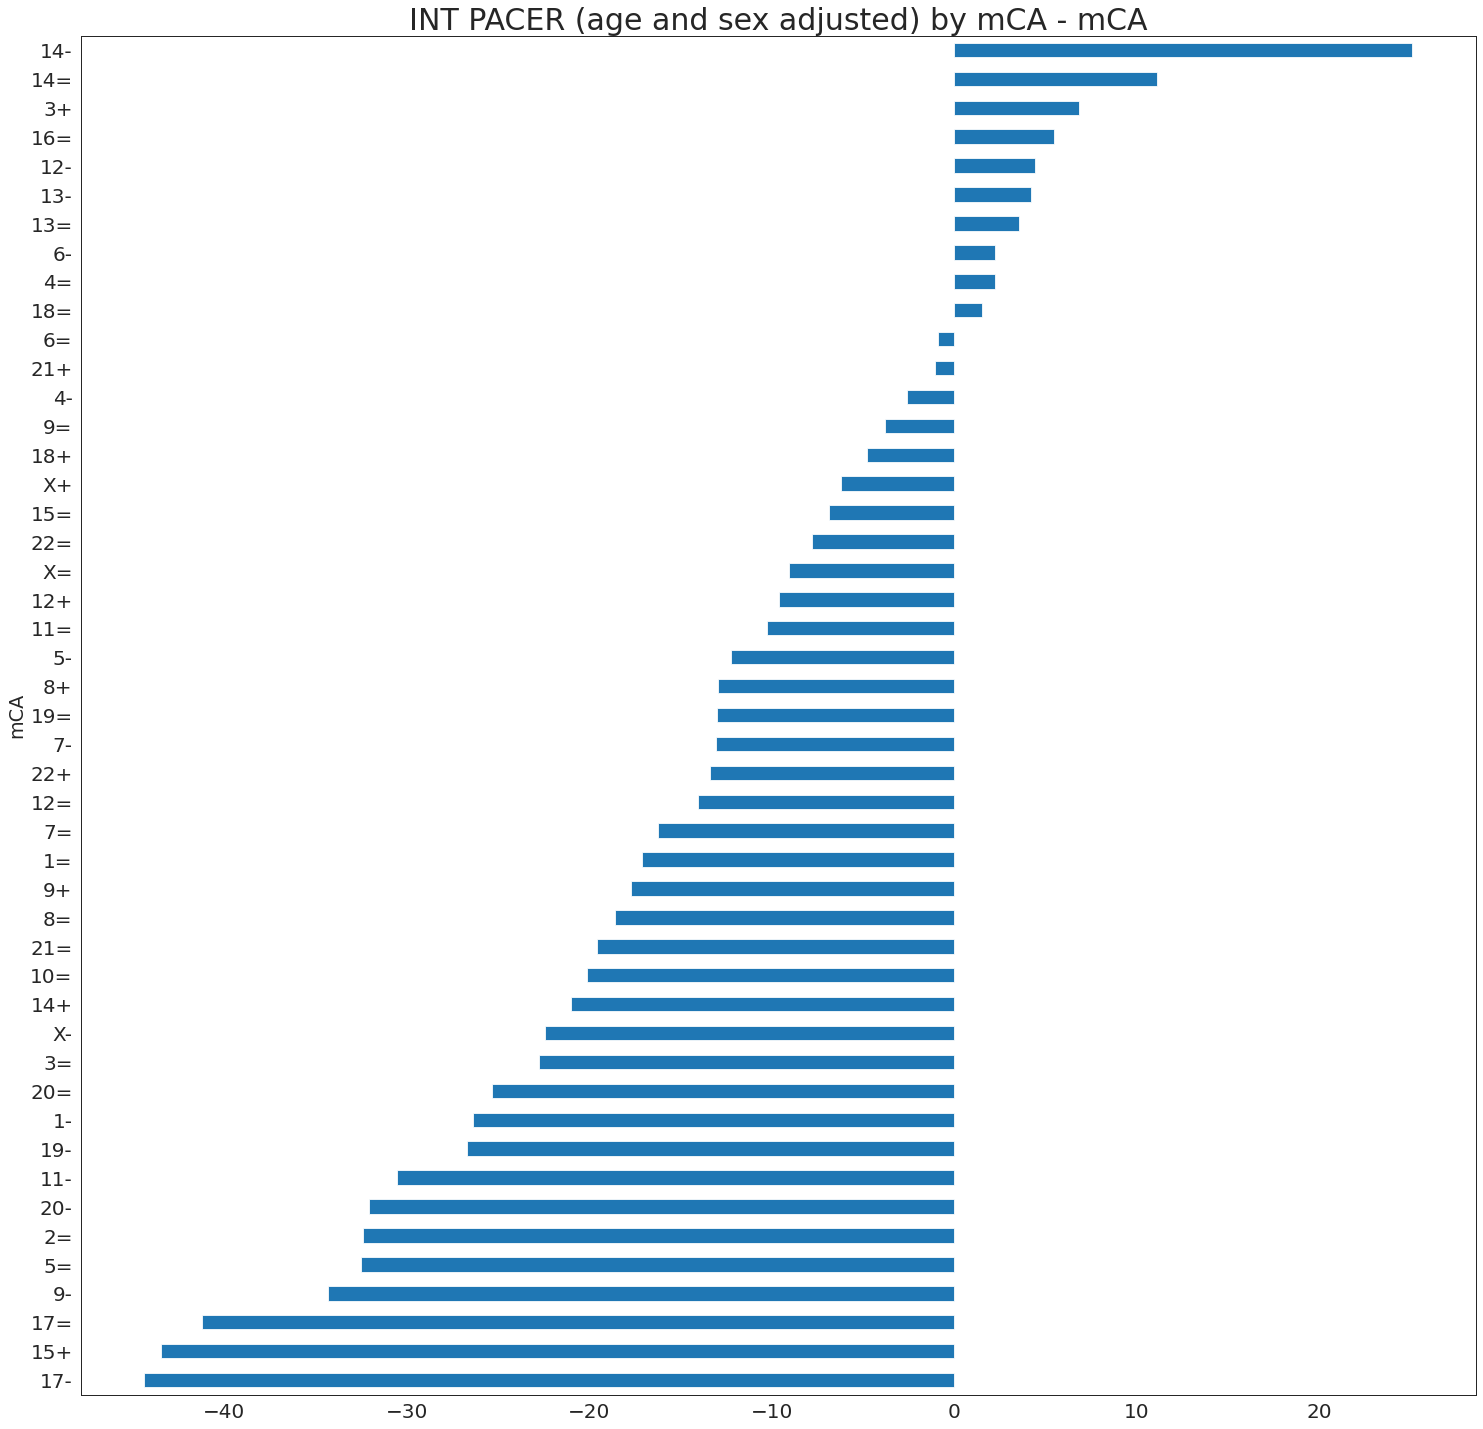

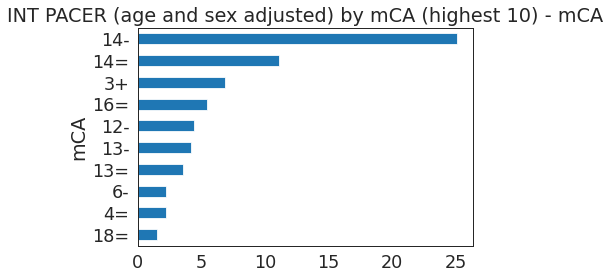

mCA  count       mean        std         min        25%        50%  \
0  14-   14.0  27.496059  51.227562  -65.586602  -2.208779  25.080024   
1  14=  111.0  -1.658257  66.654213 -324.524917 -29.820358  11.113284   
2   3+   11.0   4.672772  40.255038  -60.237223 -20.876172   6.834470   
3  16=   45.0  -2.967338  36.393201  -83.647779 -32.191009   5.468059   
4  12-   11.0 -13.404581  90.889093 -267.109306 -21.465113   4.398262   
5  13-   50.0  12.366667  60.668105 -126.798325 -30.569190   4.209464   
6  13=   46.0   6.357963  78.995860 -195.316460 -45.885179   3.516525   
7   6-   11.0  14.347648  54.614667  -76.237711 -14.871207   2.232988   
8   4=   40.0   1.741494  64.733151 -115.409116 -42.320659   2.232808   
9  18=   15.0 -18.107933  38.078543  -88.081223 -53.279349   1.532116   

         75%         max  
0  66.473979  105.811029  
1  36.394582  160.646477  
2  35.593948   62.065495  
3  20.983427   73.571421  
4  20.599817   75.830340  
5  41.534599  203.492851  
6  54.399849  221.265581  
7  61.998537   97.478769  
8  45.585928  157.187934  
9   9.427897   22.250044

In [87]:
get_mca_pacer_pairs(mca_pacer_df, 'mCA')

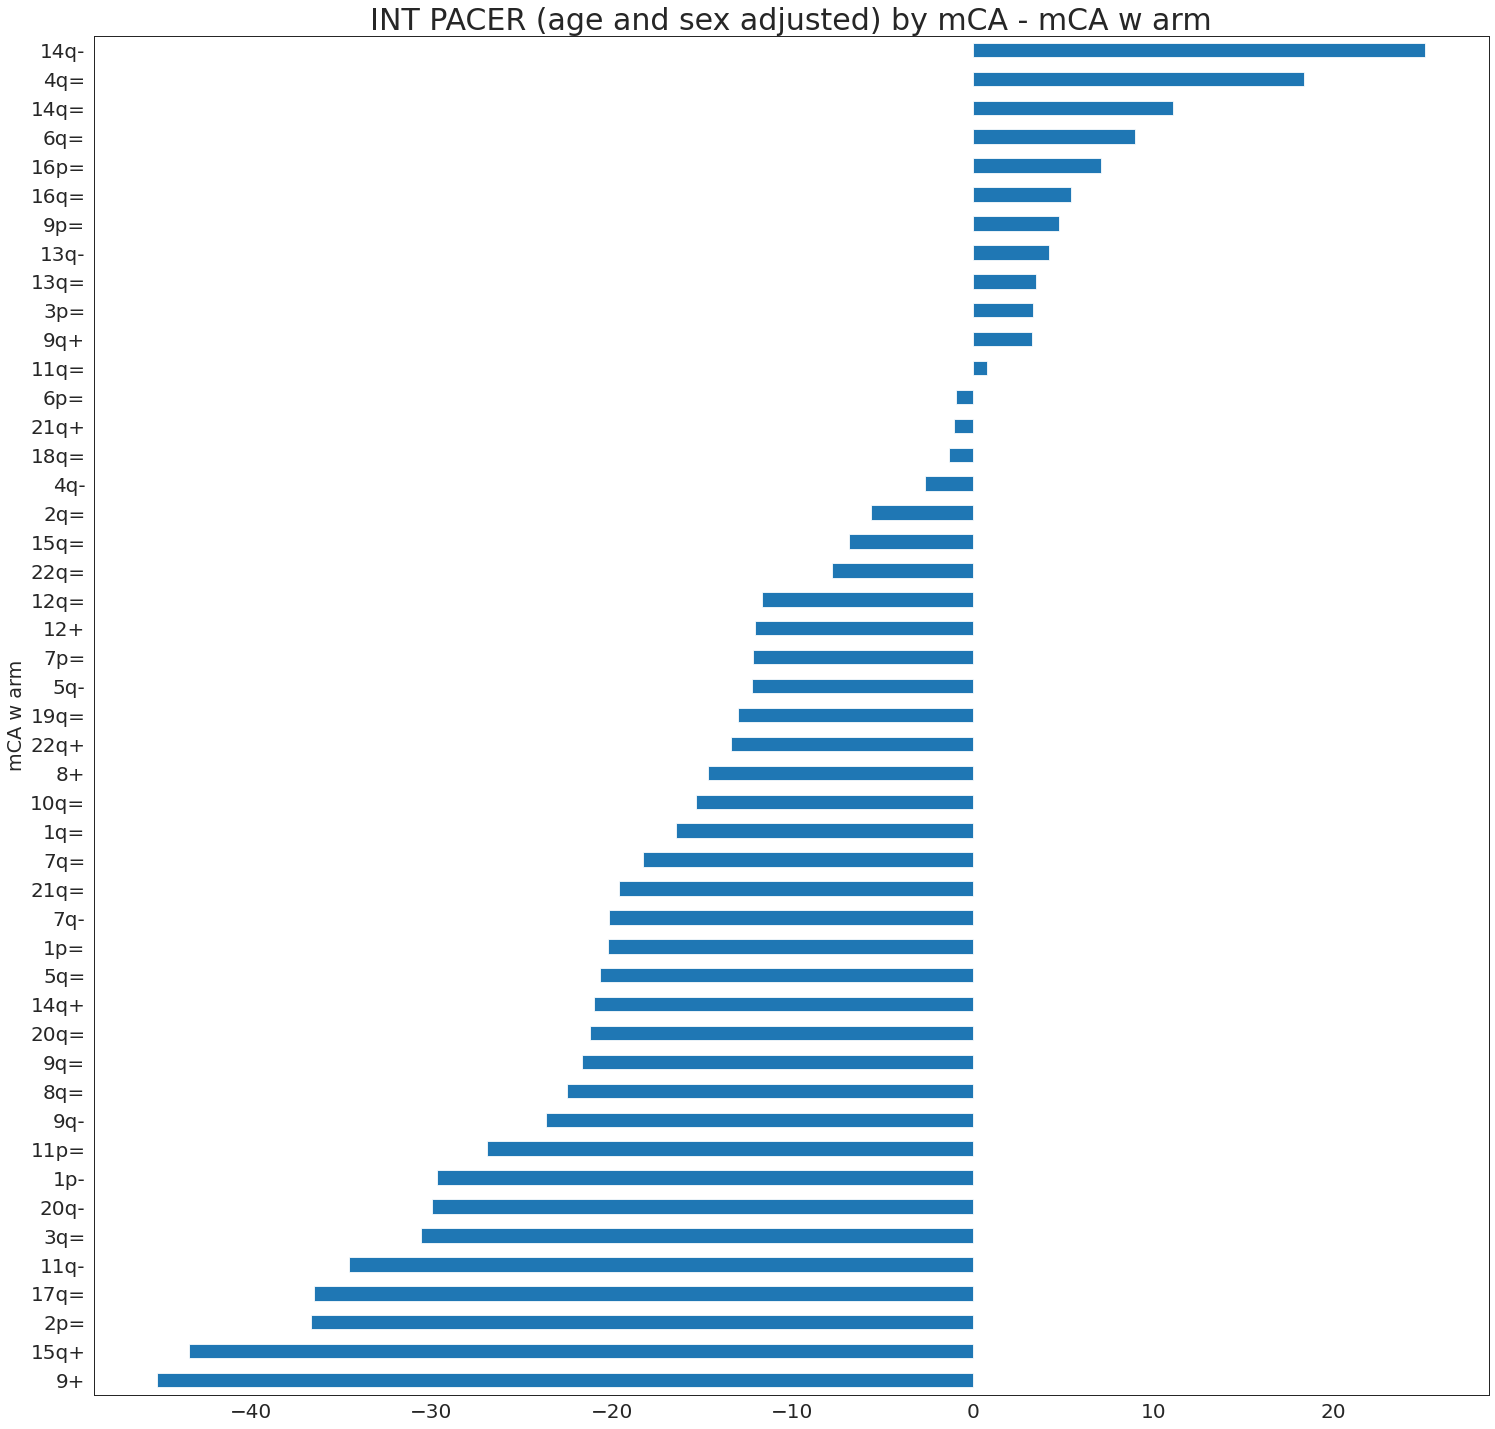

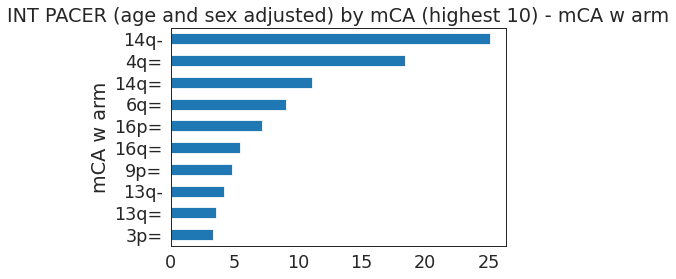

mCA w arm  count       mean        std         min        25%        50%  \
0      14q-   14.0  27.496059  51.227562  -65.586602  -2.208779  25.080024   
1       4q=   32.0  17.542899  60.361124 -104.764328 -15.124684  18.380181   
2      14q=  111.0  -1.658257  66.654213 -324.524917 -29.820358  11.113284   
3       6q=   15.0  -7.408048  53.909068 -152.422966 -27.187970   9.017923   
4      16p=   23.0  -5.021989  36.460512  -83.647779 -35.735683   7.133499   
5      16q=   21.0   0.134597  37.690424  -66.859085 -28.903823   5.468059   
6       9p=   60.0  -4.284637  68.351035 -244.043528 -42.219118   4.781458   
7      13q-   50.0  12.366667  60.668105 -126.798325 -30.569190   4.209464   
8      13q=   46.0   6.357963  78.995860 -195.316460 -45.885179   3.516525   
9       3p=   17.0   0.703558  48.877544  -94.499645 -32.379612   3.336436   

         75%         max  
0  66.473979  105.811029  
1  48.707874  157.187934  
2  36.394582  160.646477  
3  18.448482   80.280266  
4  20.182602   40.746966  
5  22.558988   73.571421  
6  46.849565  125.936142  
7  41.534599  203.492851  
8  54.399849  221.265581  
9  33.205333   73.240437

In [88]:
get_mca_pacer_pairs(mca_pacer_nochrx_df, 'mCA w arm')

## Excluding patients with CHIP

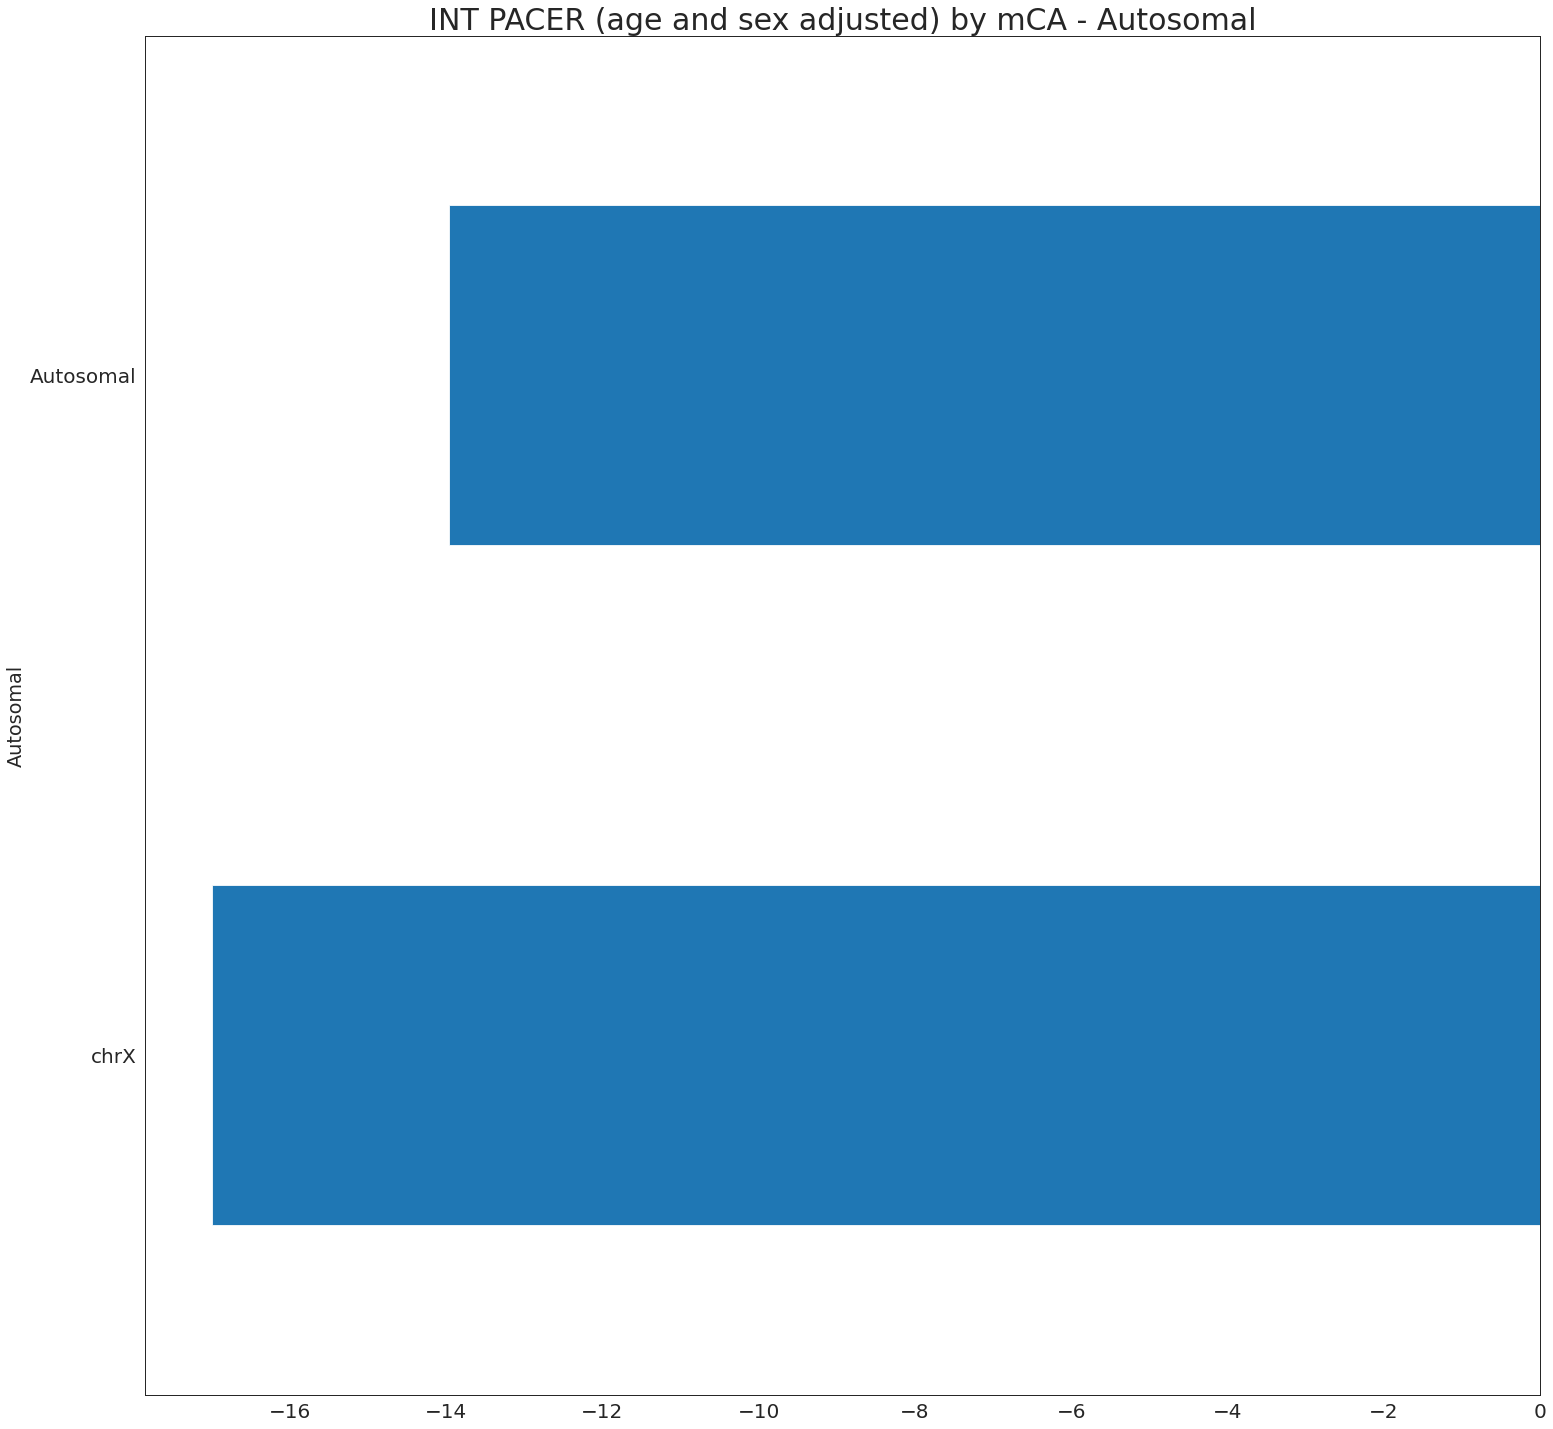

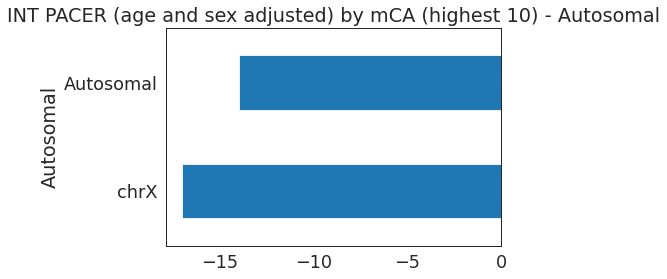

Autosomal   count       mean        std         min        25%        50%  \
0  Autosomal  1661.0 -15.533302  57.063834 -335.793776 -50.184457 -13.959101   
1       chrX  4350.0 -17.215077  40.121106 -321.950009 -44.040567 -17.001486   

         75%         max  
0  17.004905  325.302868  
1   7.412753  257.188791

In [89]:
get_mca_pacer_pairs(mca_pacer_df_nochip, 'Autosomal')

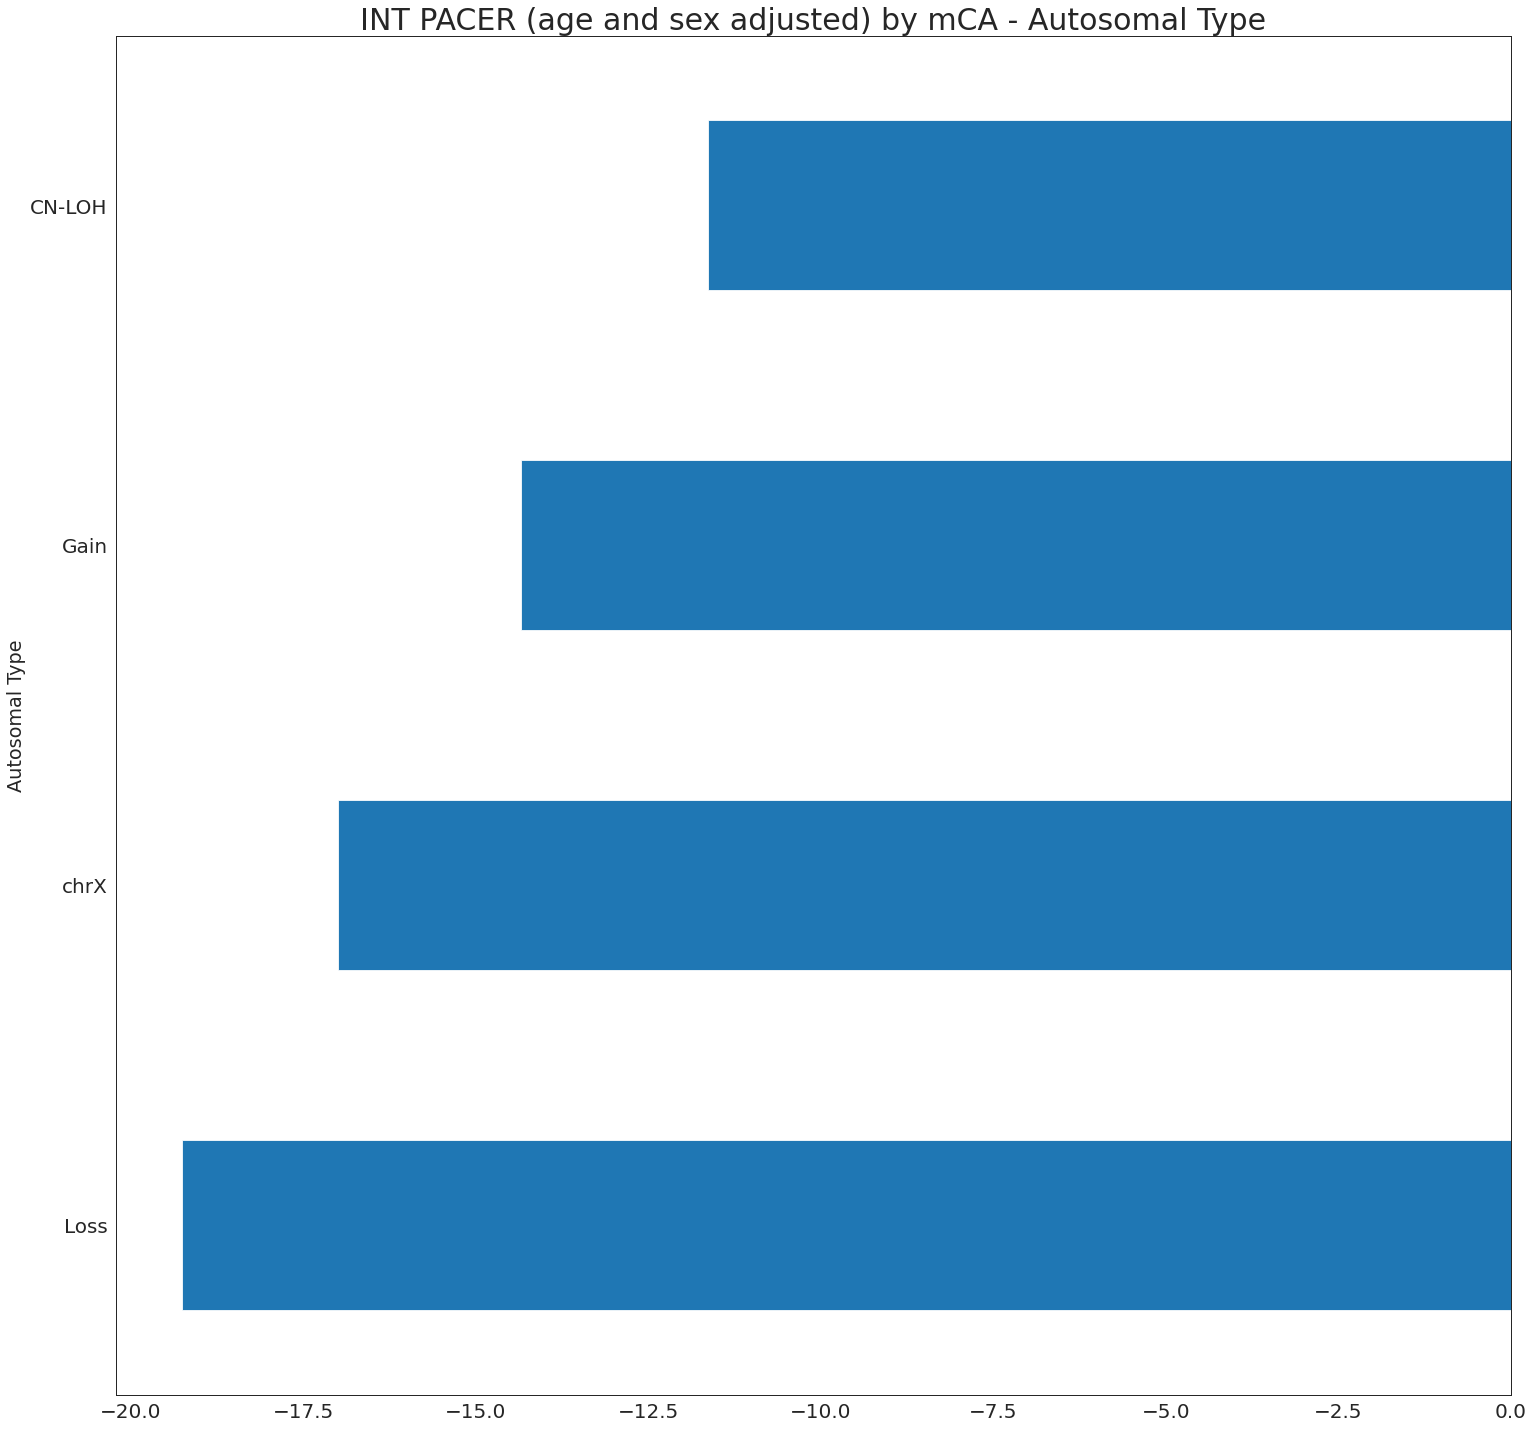

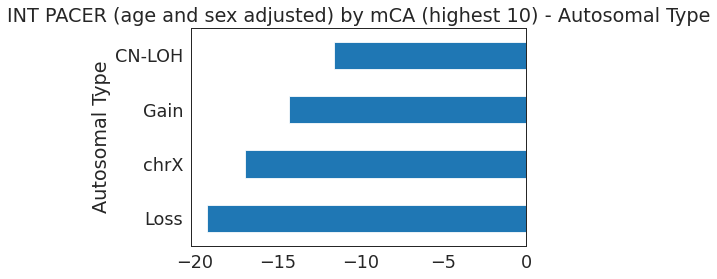

Autosomal Type   count       mean        std         min        25%  \
0         CN-LOH   946.0 -14.317695  52.287666 -335.793776 -47.349009   
1           Gain   333.0 -17.223107  63.018608 -332.056071 -50.335150   
2           chrX  4350.0 -17.215077  40.121106 -321.950009 -44.040567   
3           Loss   382.0 -17.070632  62.746807 -293.119471 -54.100151   

         50%        75%         max  
0 -11.635771  18.296899  221.265581  
1 -14.351091  16.961420  187.915444  
2 -17.001486   7.412753  257.188791  
3 -19.253670  15.488065  325.302868

In [90]:
get_mca_pacer_pairs(mca_pacer_df_nochip, 'Autosomal Type')

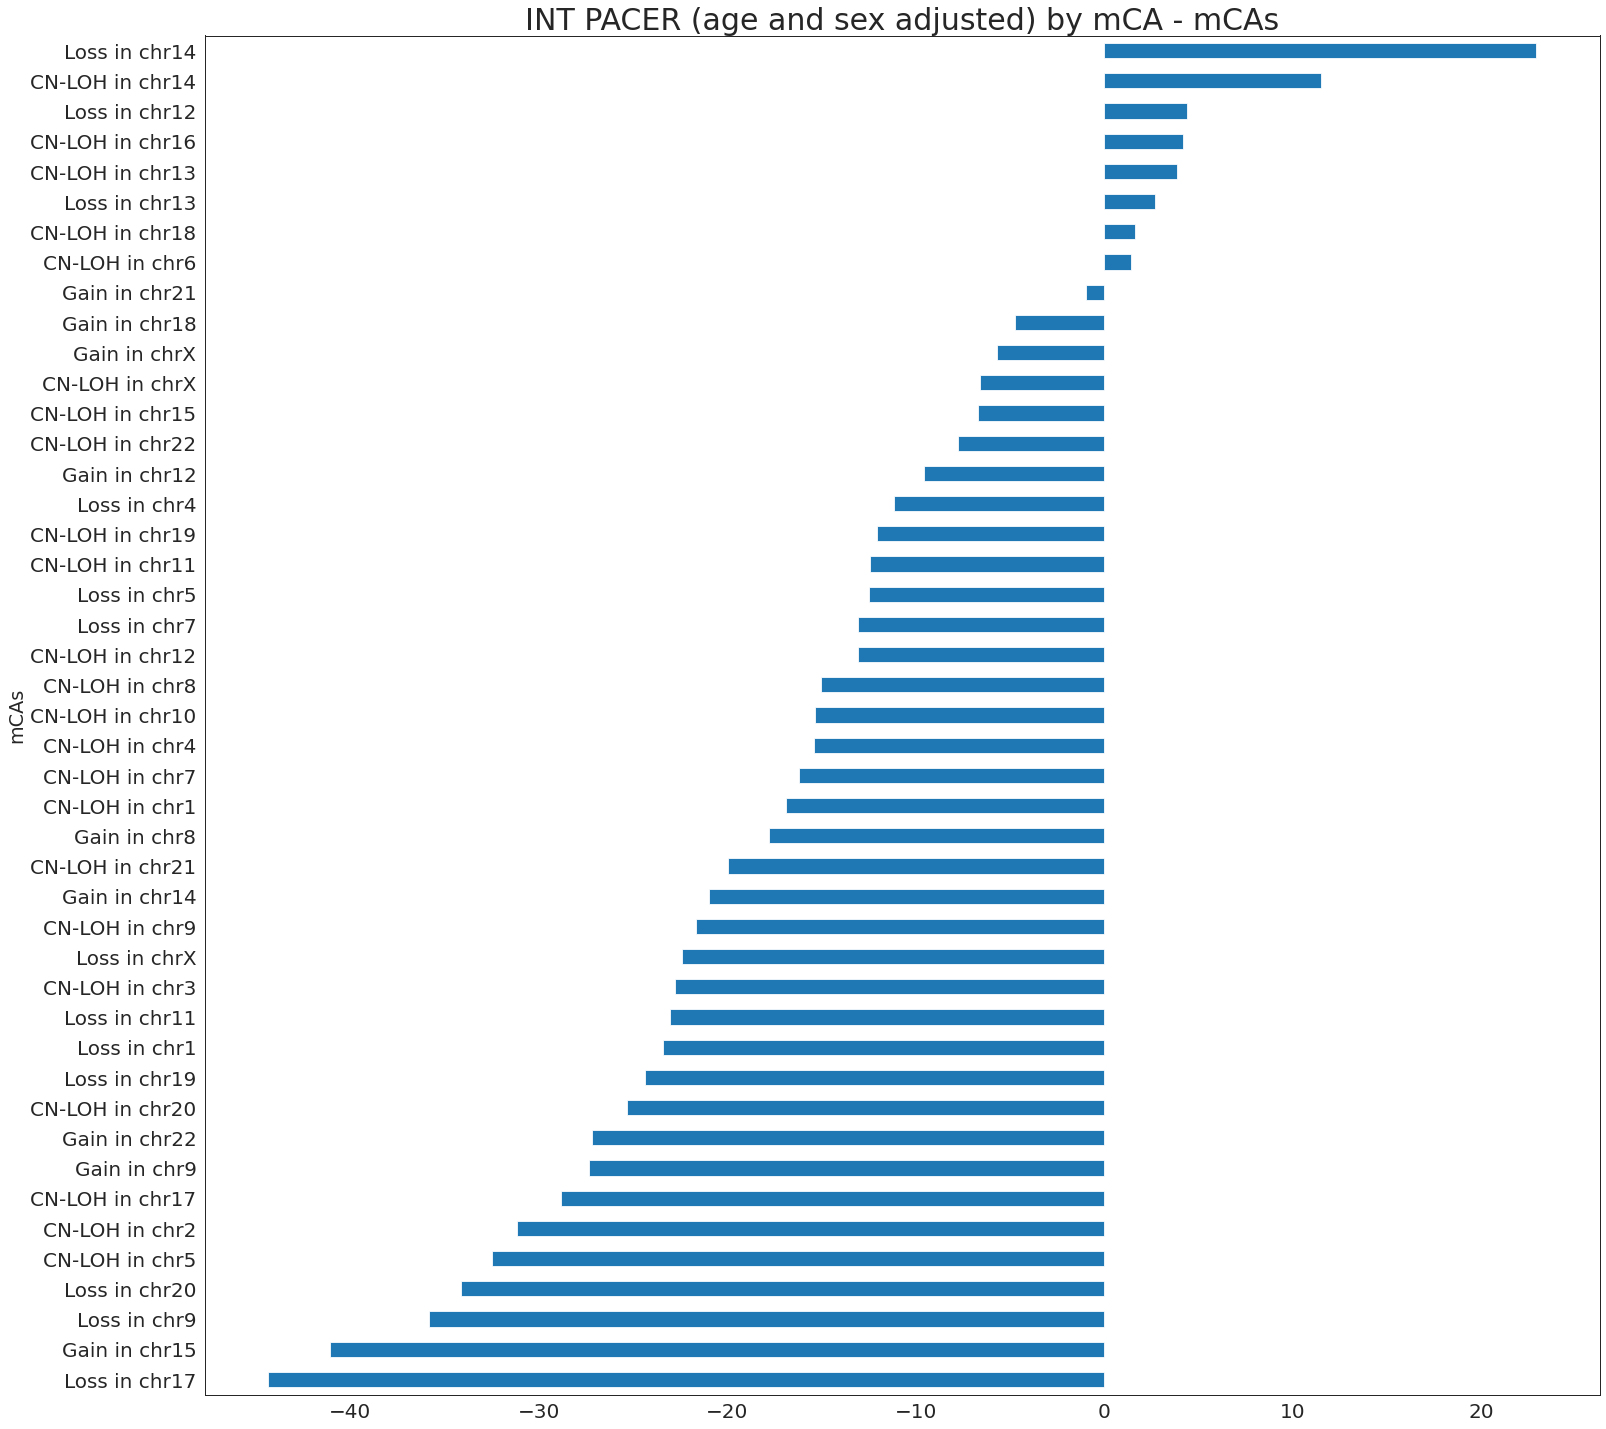

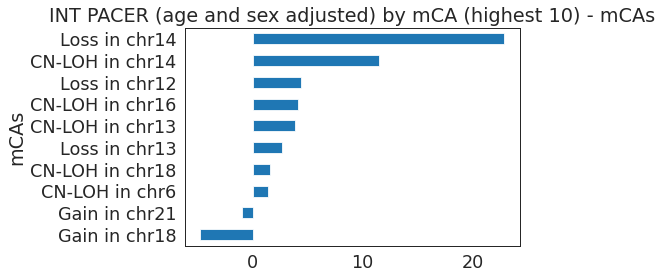

mCAs  count       mean        std         min        25%  \
0    Loss in chr14   11.0  29.590785  47.775123  -40.340092   2.796734   
1  CN-LOH in chr14   90.0   5.606789  51.952006 -133.362325 -24.117173   
2    Loss in chr12   11.0 -13.404581  90.889093 -267.109306 -21.465113   
3  CN-LOH in chr16   42.0  -5.210153  36.175042  -83.647779 -36.201068   
4  CN-LOH in chr13   45.0   9.159438  77.543195 -195.316460 -44.770110   
5    Loss in chr13   43.0  10.494045  56.612781 -126.798325 -27.599719   
6  CN-LOH in chr18   13.0 -15.210335  37.103992  -88.081223 -51.348158   
7   CN-LOH in chr6   41.0  -6.483395  46.681475 -108.932258 -35.752226   
8    Gain in chr21   42.0 -12.910767  47.520725 -113.909345 -49.066088   
9    Gain in chr18   13.0  -9.846820  30.420601  -58.286198 -23.245206   

         50%        75%         max  
0  22.908987  57.814101  105.811029  
1  11.495597  37.299102  160.646477  
2   4.398262  20.599817   75.830340  
3   4.179604  19.309393   73.571421  
4   3.869606  54.805326  221.265581  
5   2.690649  28.998196  203.492851  
6   1.602684  13.055647   22.250044  
7   1.386124  25.674438   90.839541  
8  -0.974622   9.597101  106.676026  
9  -4.767057   0.543633   60.541795

In [91]:
get_mca_pacer_pairs(mca_pacer_df_nochip, 'mCAs')

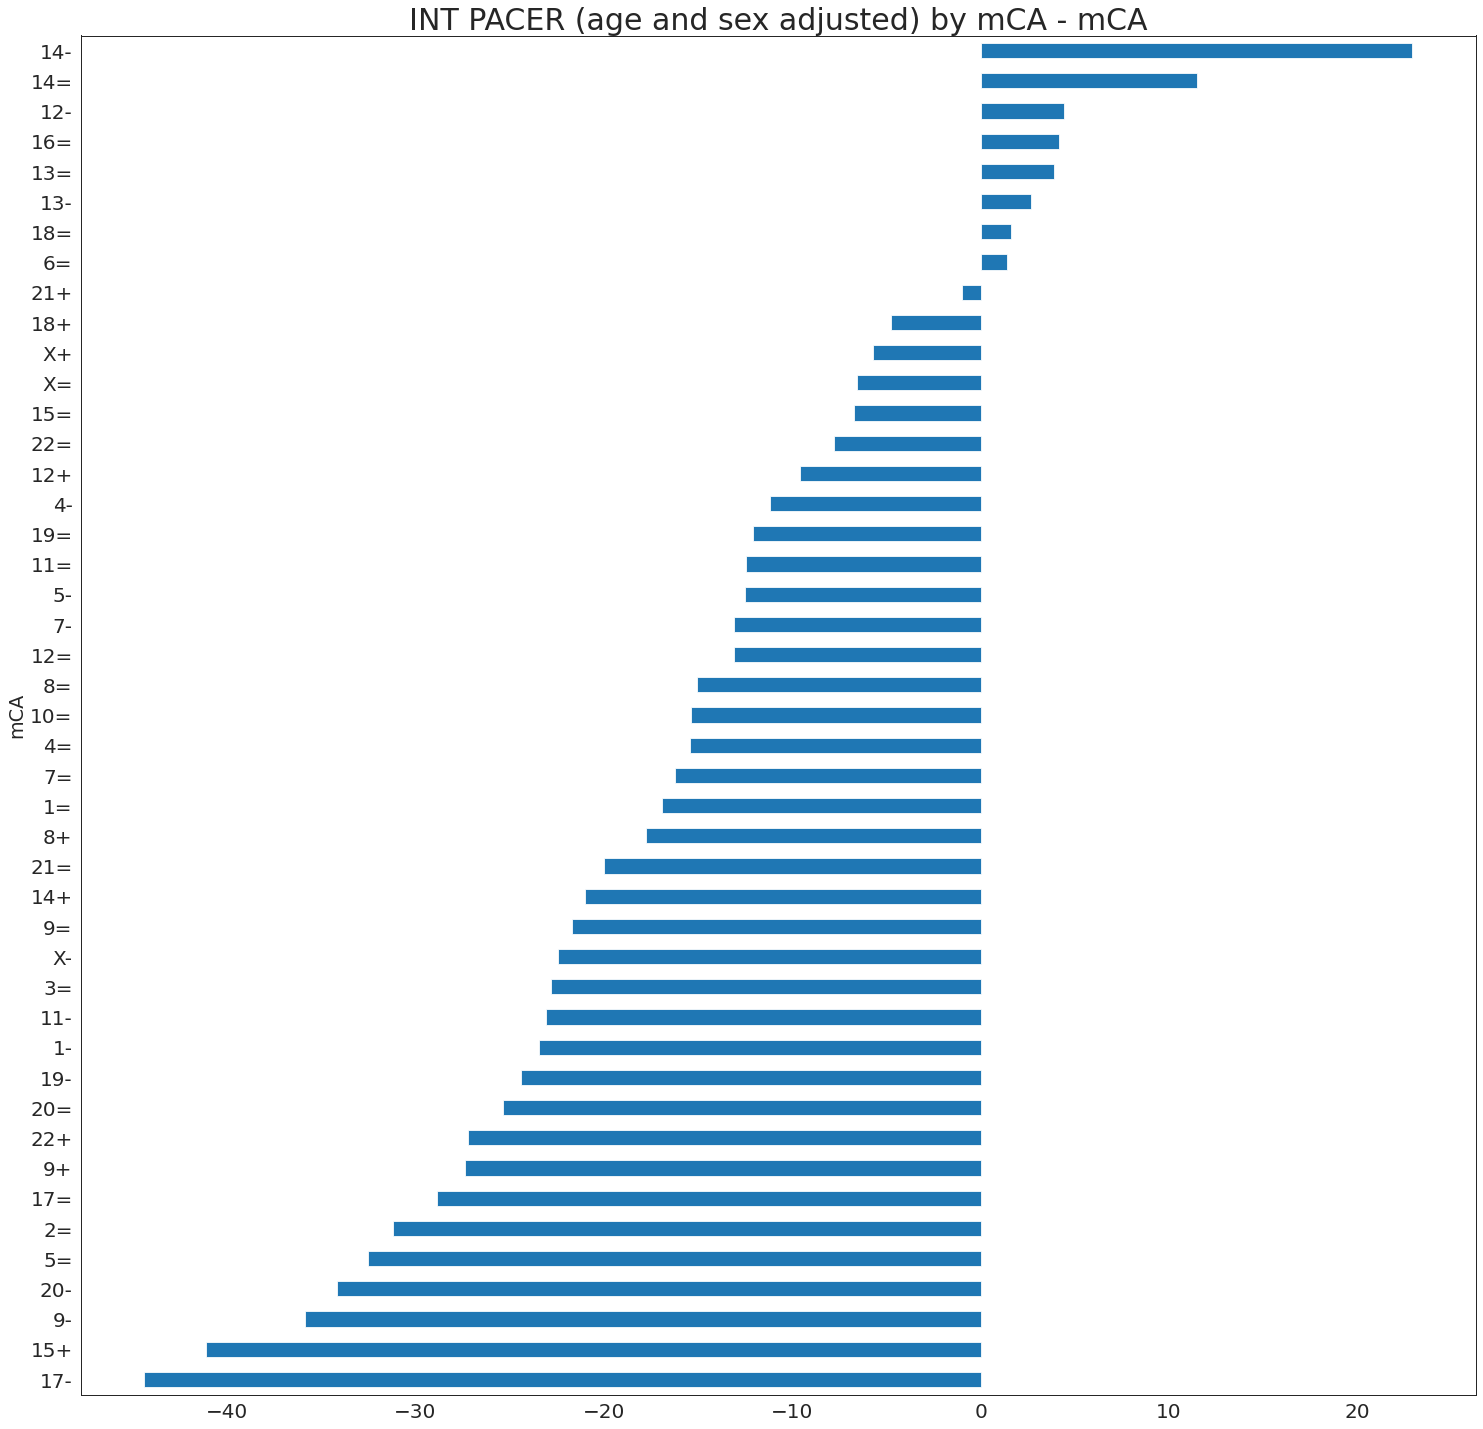

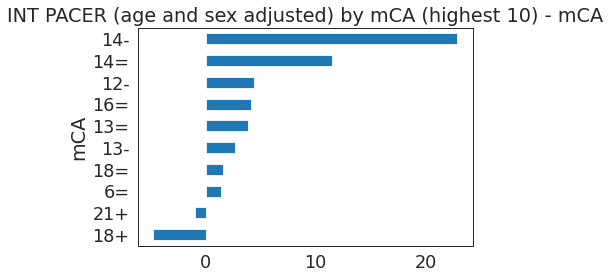

mCA  count       mean        std         min        25%        50%  \
0  14-   11.0  29.590785  47.775123  -40.340092   2.796734  22.908987   
1  14=   90.0   5.606789  51.952006 -133.362325 -24.117173  11.495597   
2  12-   11.0 -13.404581  90.889093 -267.109306 -21.465113   4.398262   
3  16=   42.0  -5.210153  36.175042  -83.647779 -36.201068   4.179604   
4  13=   45.0   9.159438  77.543195 -195.316460 -44.770110   3.869606   
5  13-   43.0  10.494045  56.612781 -126.798325 -27.599719   2.690649   
6  18=   13.0 -15.210335  37.103992  -88.081223 -51.348158   1.602684   
7   6=   41.0  -6.483395  46.681475 -108.932258 -35.752226   1.386124   
8  21+   42.0 -12.910767  47.520725 -113.909345 -49.066088  -0.974622   
9  18+   13.0  -9.846820  30.420601  -58.286198 -23.245206  -4.767057   

         75%         max  
0  57.814101  105.811029  
1  37.299102  160.646477  
2  20.599817   75.830340  
3  19.309393   73.571421  
4  54.805326  221.265581  
5  28.998196  203.492851  
6  13.055647   22.250044  
7  25.674438   90.839541  
8   9.597101  106.676026  
9   0.543633   60.541795

In [92]:
get_mca_pacer_pairs(mca_pacer_df_nochip, 'mCA')

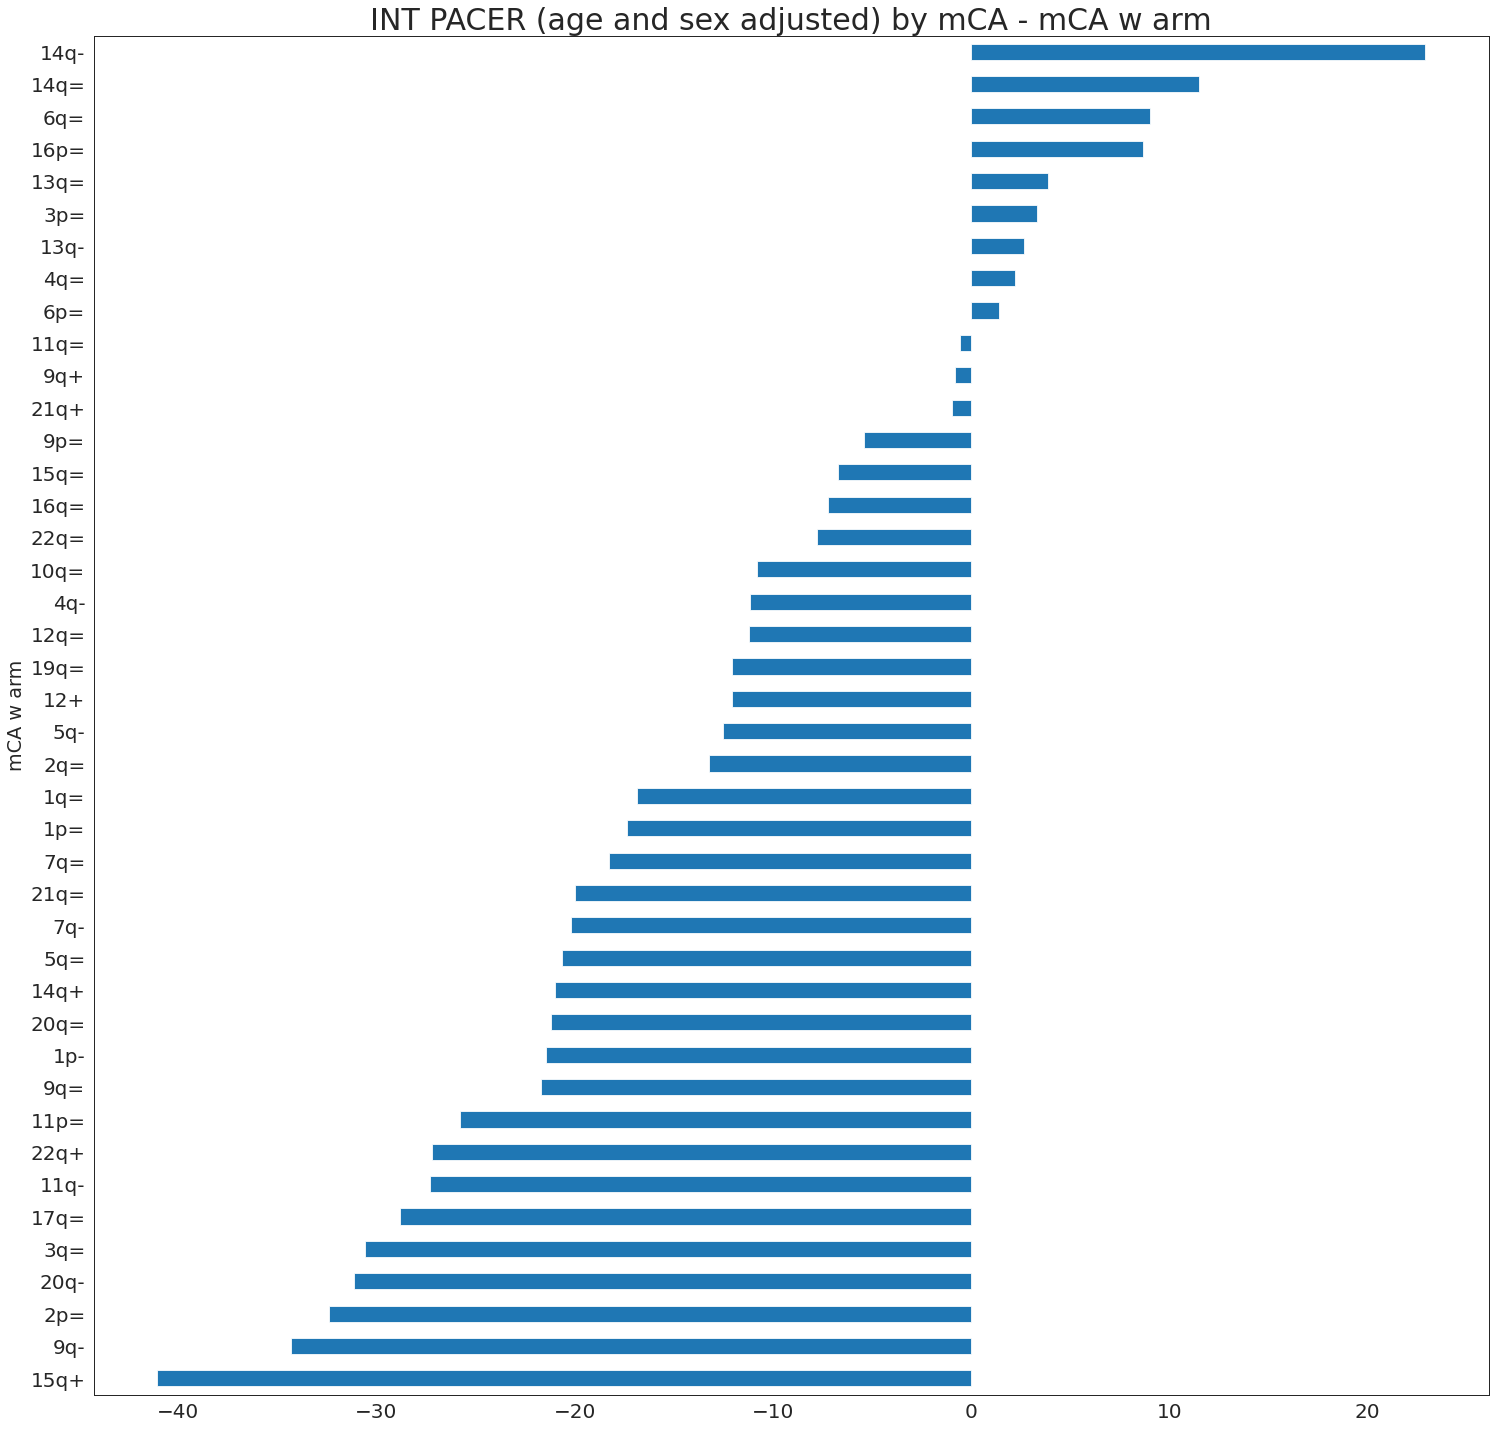

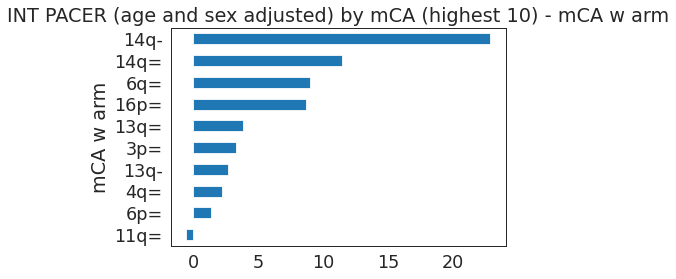

mCA w arm  count       mean        std         min        25%        50%  \
0      14q-   11.0  29.590785  47.775123  -40.340092   2.796734  22.908987   
1      14q=   90.0   5.606789  51.952006 -133.362325 -24.117173  11.495597   
2       6q=   11.0   0.710272  37.801347  -69.950295 -18.261319   9.017923   
3      16p=   22.0  -5.465402  37.254996  -83.647779 -37.508019   8.674059   
4      13q=   45.0   9.159438  77.543195 -195.316460 -44.770110   3.869606   
5       3p=   17.0   0.703558  48.877544  -94.499645 -32.379612   3.336436   
6      13q-   43.0  10.494045  56.612781 -126.798325 -27.599719   2.690649   
7       4q=   20.0   5.921407  58.996711 -104.764328 -21.213104   2.232808   
8       6p=   27.0  -2.266064  46.696747  -96.003784 -38.039207   1.386124   
9      11q=   72.0  -5.145468  51.006797 -114.550024 -34.635924  -0.545141   

         75%         max  
0  57.814101  105.811029  
1  37.299102  160.646477  
2  10.637329   80.280266  
3  20.583014   40.746966  
4  54.805326  221.265581  
5  33.205333   73.240437  
6  28.998196  203.492851  
7  37.672106  157.187934  
8  36.865492   90.839541  
9  29.943410  132.045545

In [93]:
get_mca_pacer_pairs(mca_pacer_nochrx_df_nochip, 'mCA w arm')

## Only patients with CHIP - not enough samples to proceed

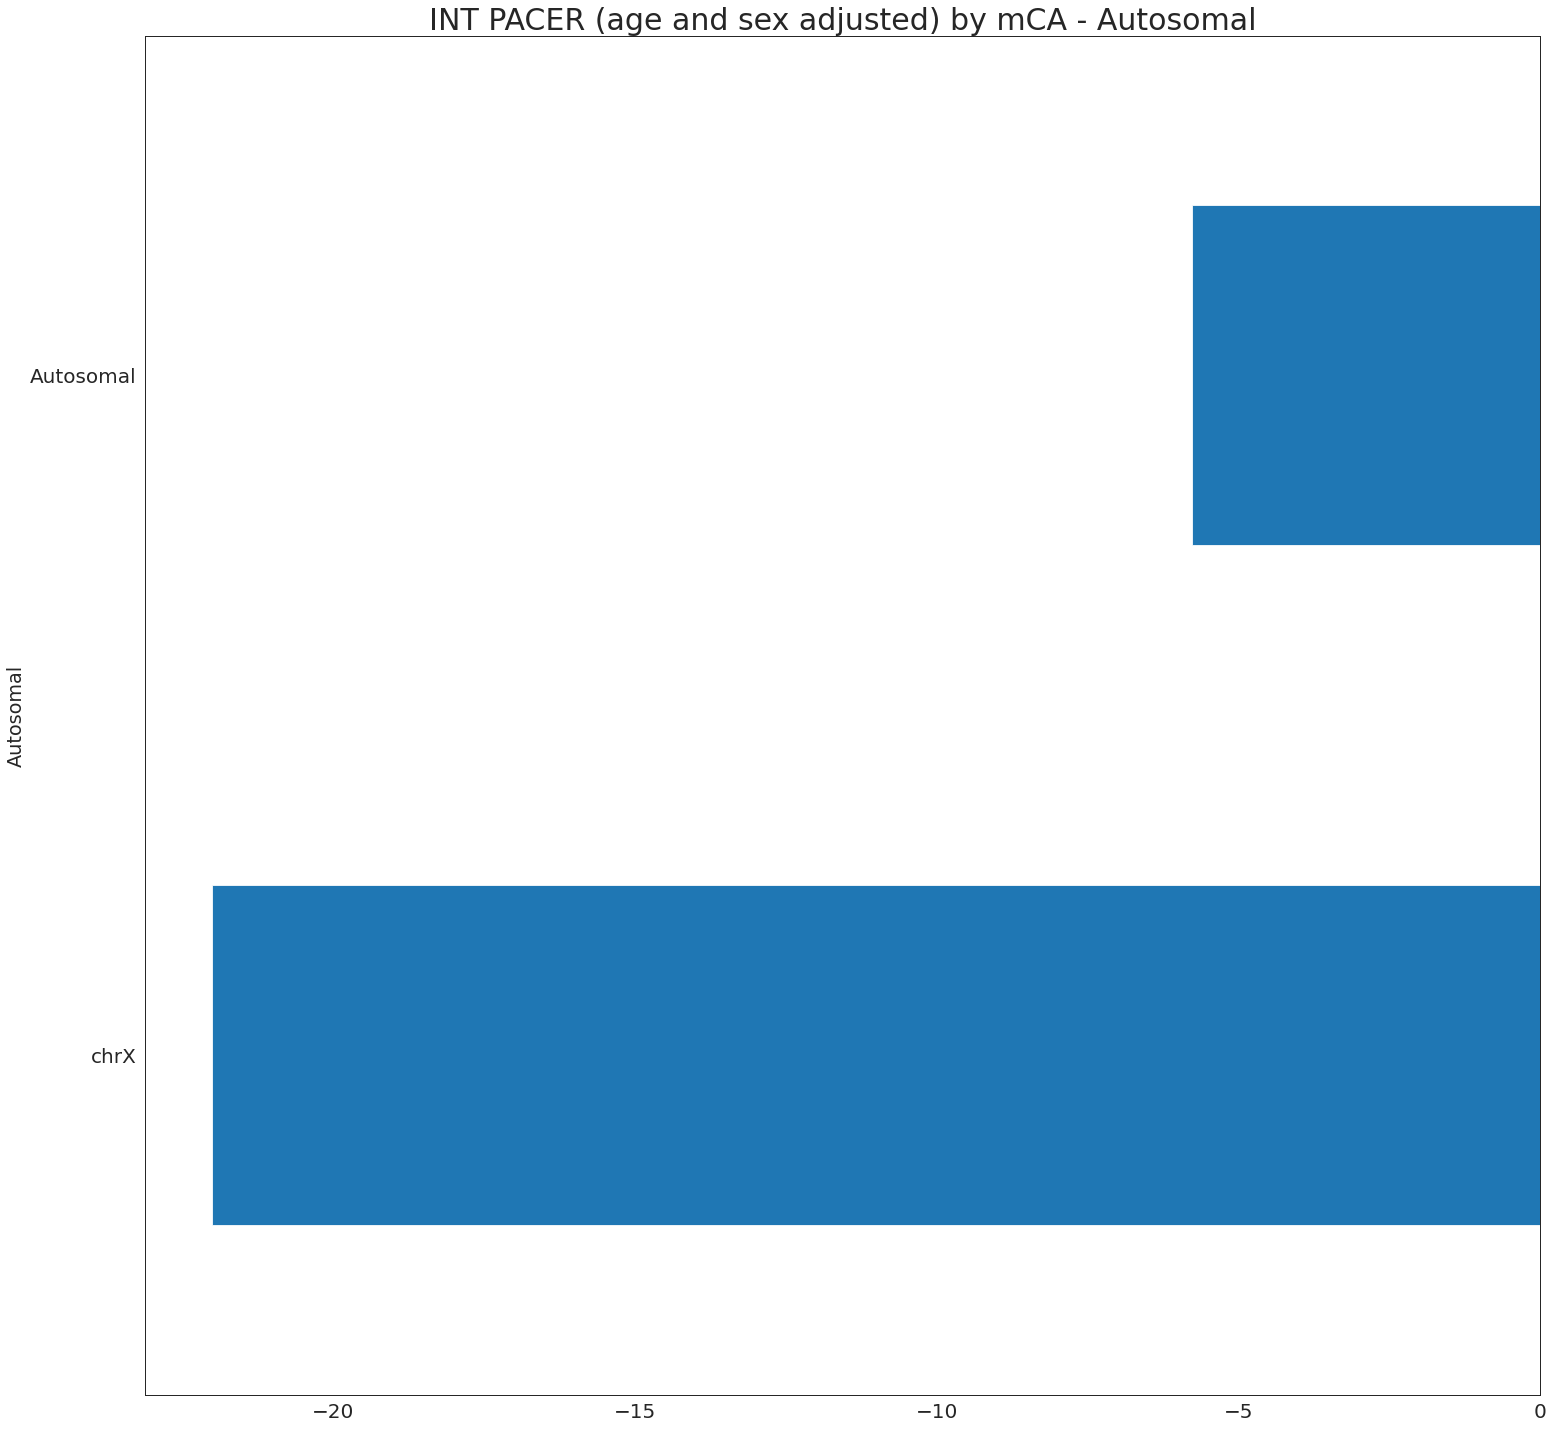

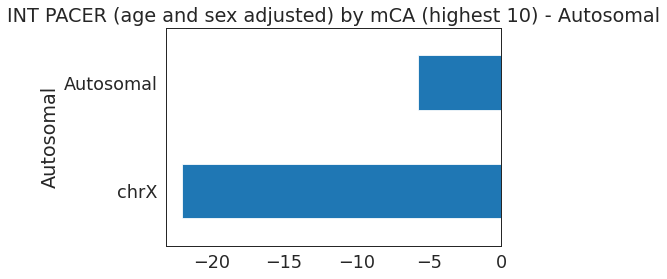

Autosomal  count       mean        std         min        25%        50%  \
0  Autosomal  237.0 -22.249840  78.987399 -415.179667 -68.006384  -5.765510   
1       chrX  332.0 -29.848708  58.434692 -230.705024 -70.834946 -22.015824   

         75%         max  
0  31.906862  154.115698  
1  14.386880  123.865068

In [94]:
get_mca_pacer_pairs(mca_pacer_df_onlychip, 'Autosomal')

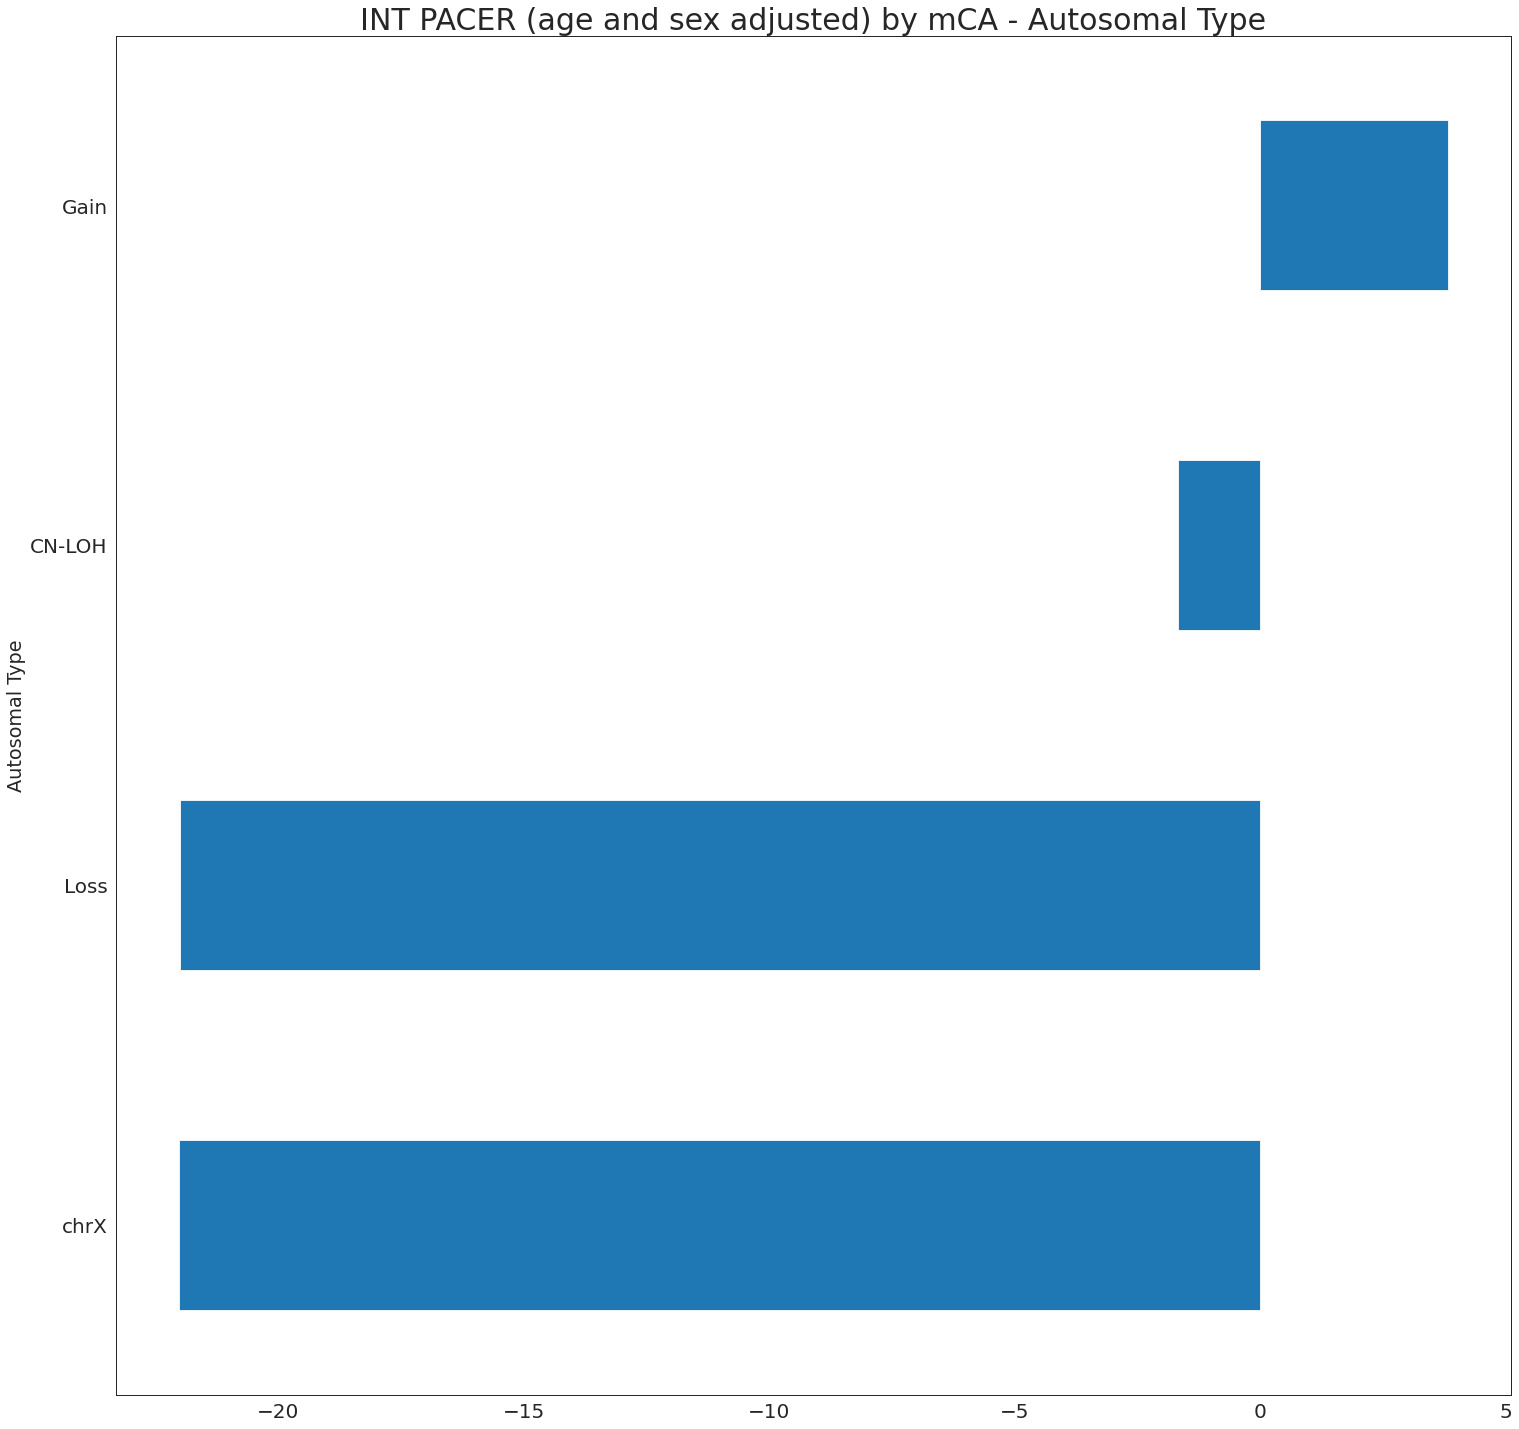

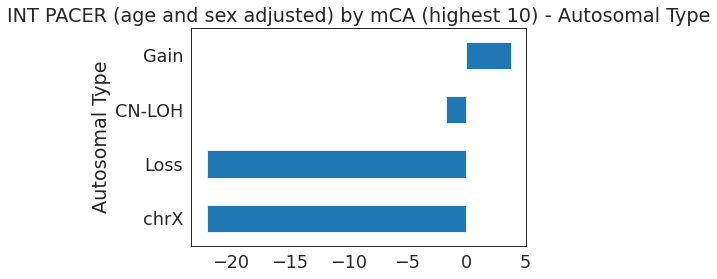

Autosomal Type  count       mean        std         min        25%  \
0           Gain   50.0 -28.571261  98.712721 -415.179667 -82.390755   
1         CN-LOH  127.0 -19.104880  73.478890 -324.524917 -57.840999   
2           Loss   60.0 -23.638823  72.635361 -167.922149 -85.224499   
3           chrX  332.0 -29.848708  58.434692 -230.705024 -70.834946   

         50%        75%         max  
0   3.812606  31.610092  113.071509  
1  -1.676676  32.239625  154.115698  
2 -22.005908  27.297901  126.775333  
3 -22.015824  14.386880  123.865068

In [95]:
get_mca_pacer_pairs(mca_pacer_df_onlychip, 'Autosomal Type')

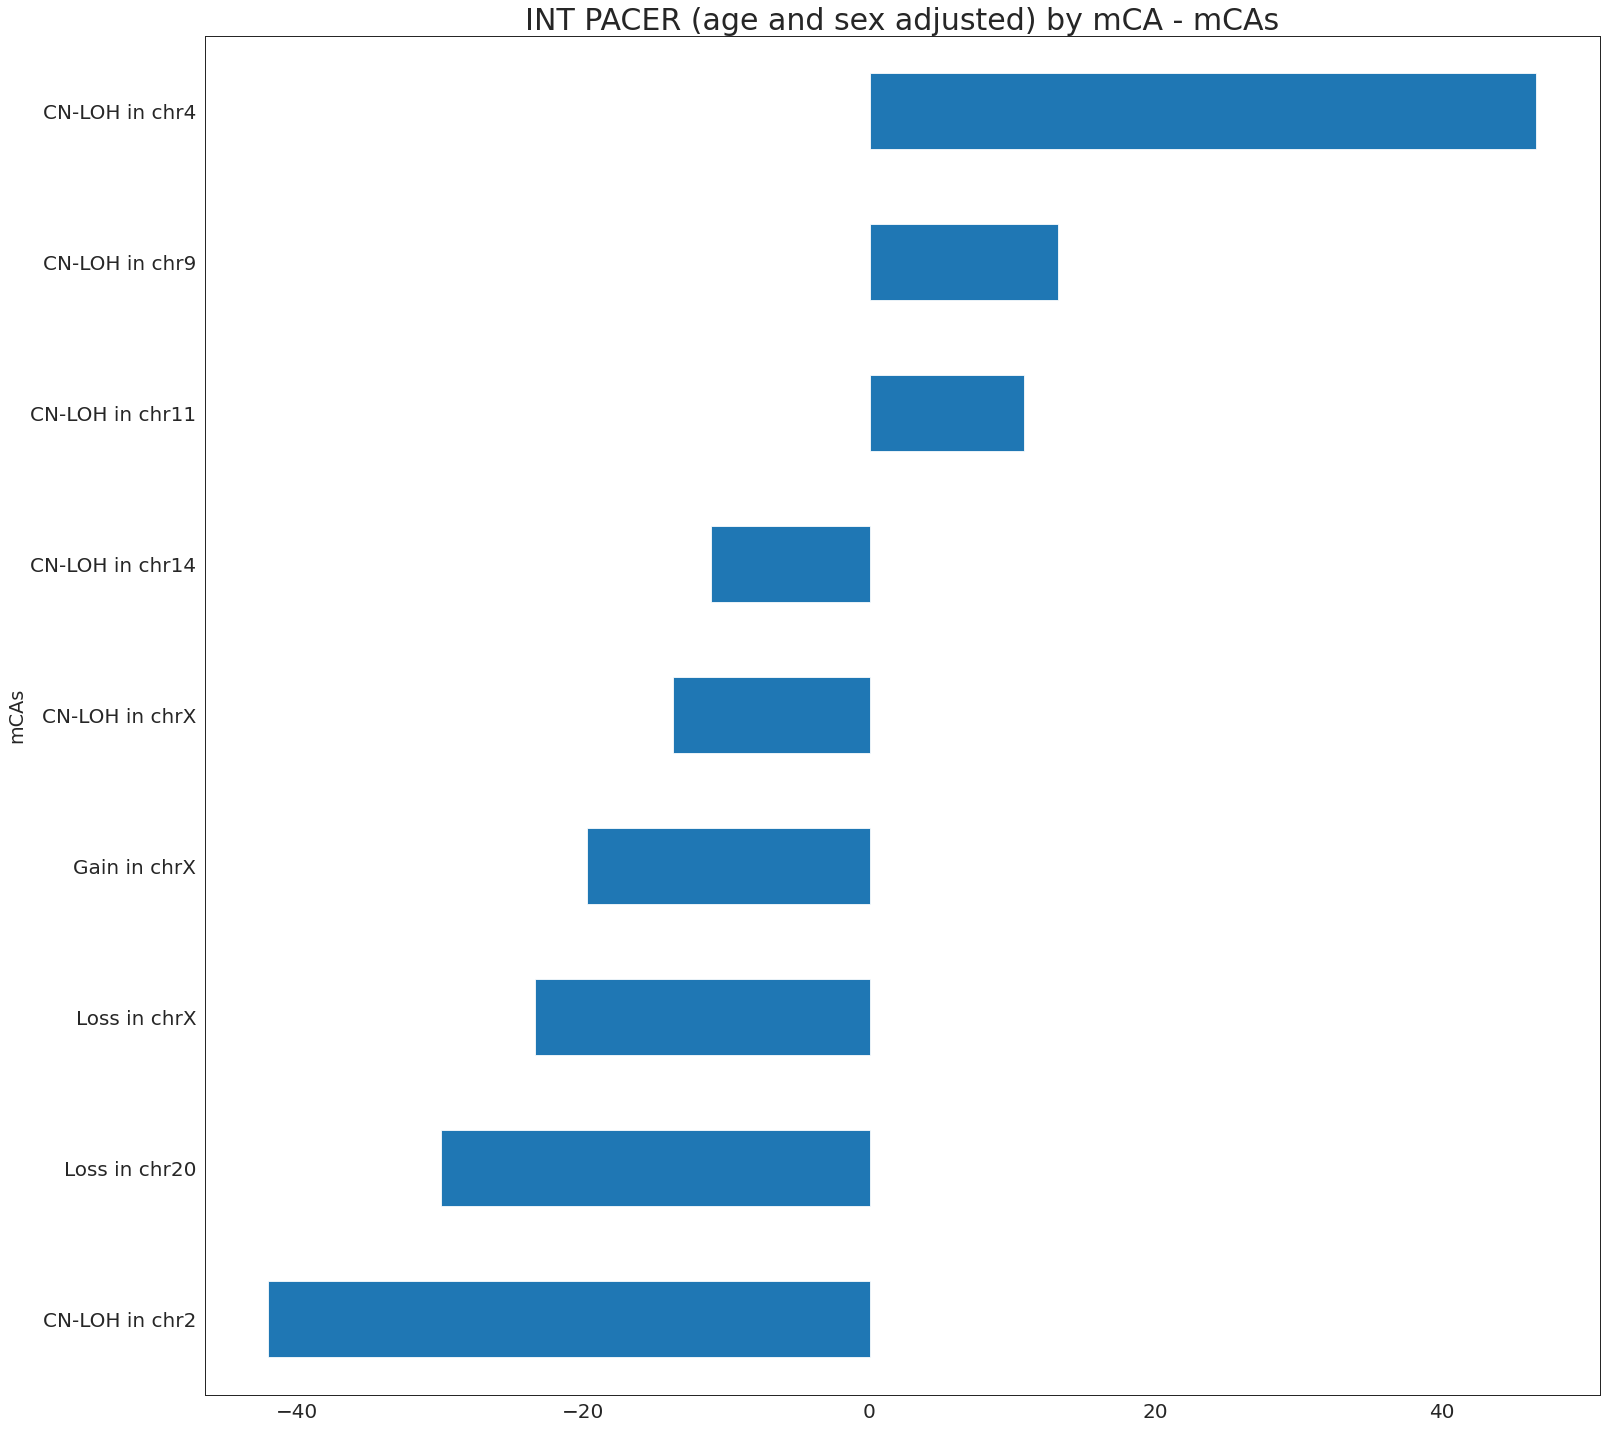

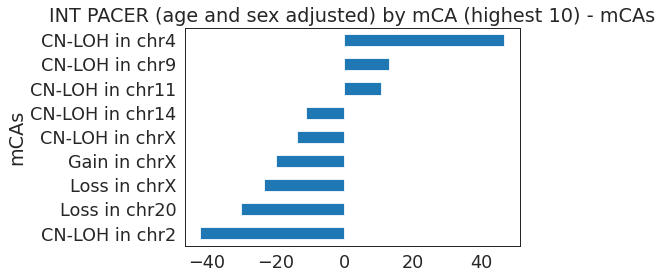

mCAs  count       mean         std         min        25%  \
0   CN-LOH in chr4   12.0  36.912052   60.009578  -94.402150  11.462908   
1   CN-LOH in chr9   28.0  -2.456901   60.290241 -202.980350 -27.407895   
2  CN-LOH in chr11   12.0 -21.973372   77.595834 -150.189889 -79.428536   
3  CN-LOH in chr14   21.0 -32.794168  105.684829 -324.524917 -81.082145   
4   CN-LOH in chrX   21.0 -33.113000   52.449612 -124.663366 -76.848813   
5     Gain in chrX   52.0 -16.889128   44.023851 -138.464450 -36.105175   
6     Loss in chrX  259.0 -32.185959   61.189837 -230.705024 -80.795590   
7    Loss in chr20   15.0 -26.834465   65.043321 -127.643105 -76.520859   
8   CN-LOH in chr2   12.0 -40.501518   45.389552 -124.029952 -72.407695   

         50%        75%         max  
0  46.596296  53.714120  154.115698  
1  13.145724  36.749131   97.268478  
2  10.780755  20.748570   96.748200  
3 -11.061101  26.556894  109.239081  
4 -13.764065   8.286447   65.849711  
5 -19.765299  13.801414   66.455816  
6 -23.398153  15.516063  123.865068  
7 -29.957649  10.468900  126.775333  
8 -42.037216  -0.645527   25.627994

In [96]:
get_mca_pacer_pairs(mca_pacer_df_onlychip, 'mCAs')

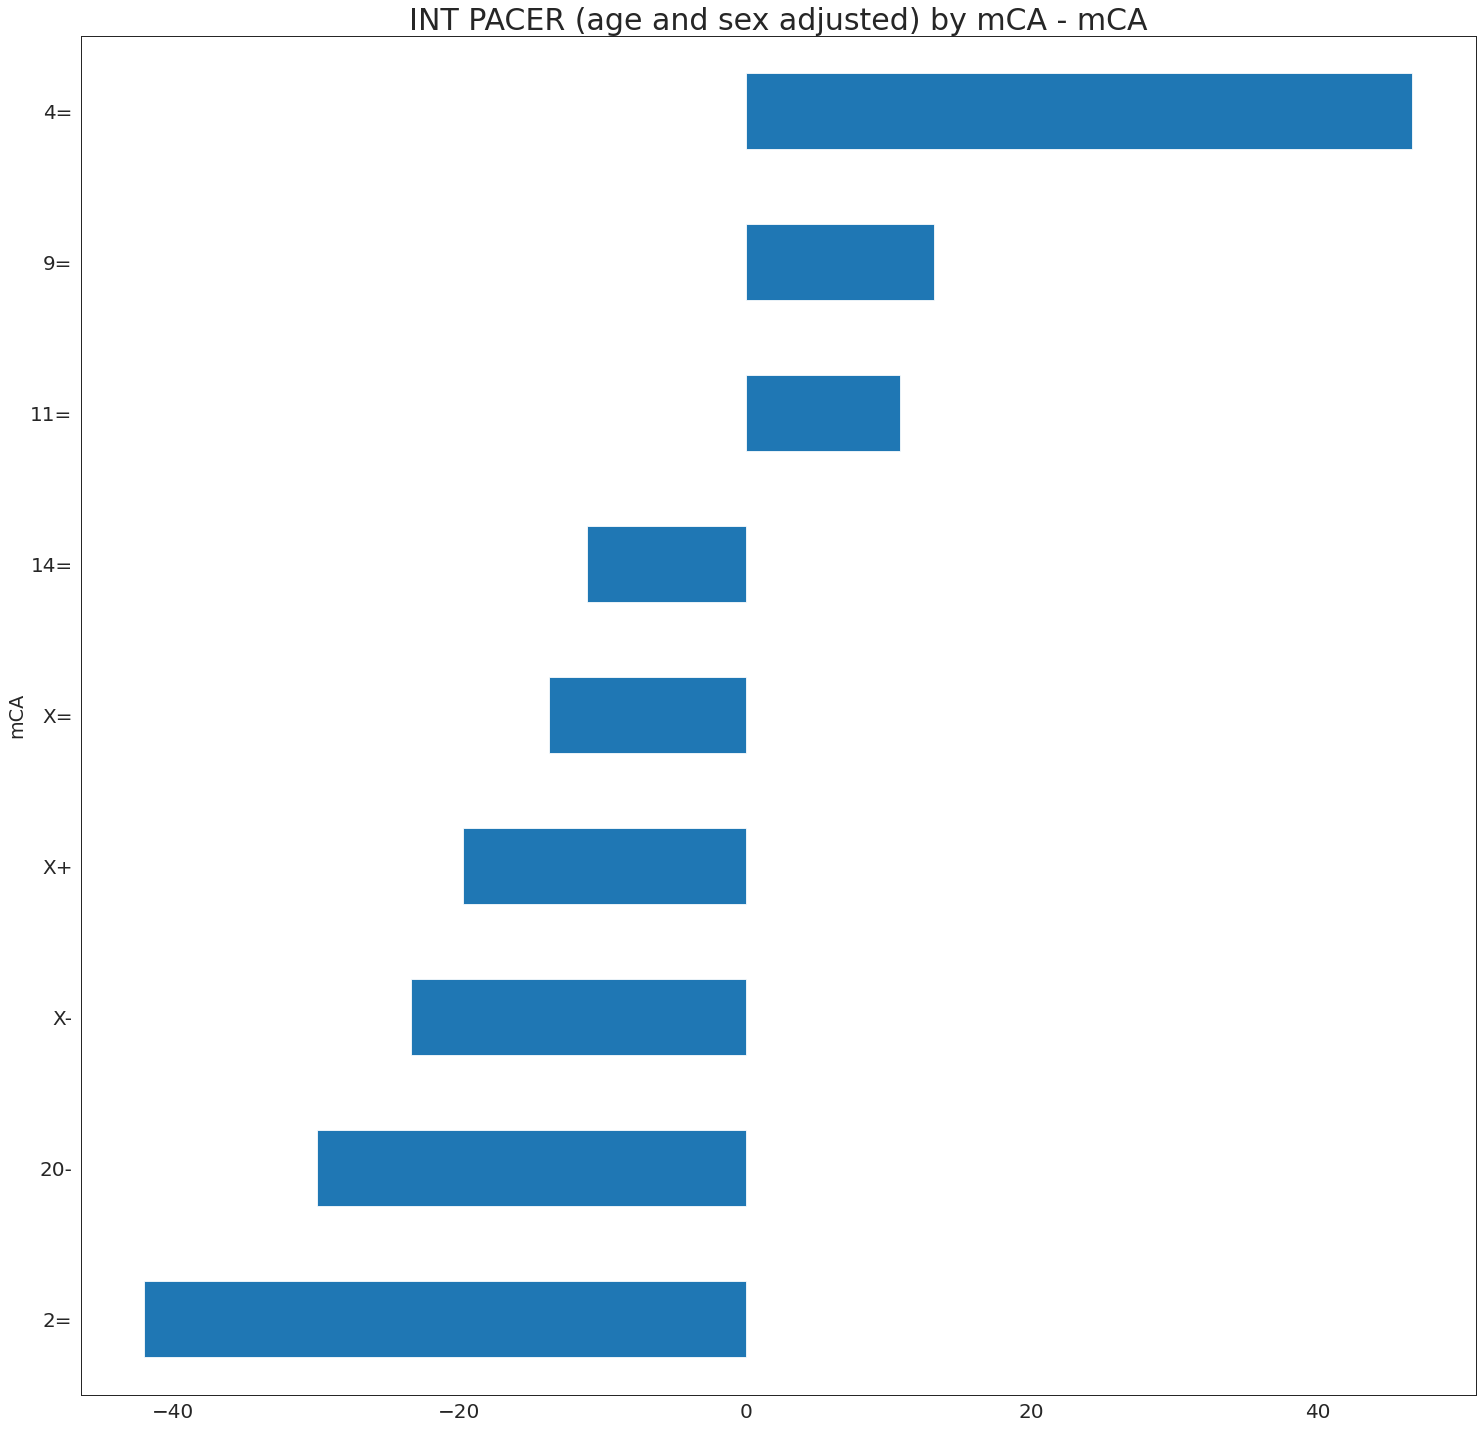

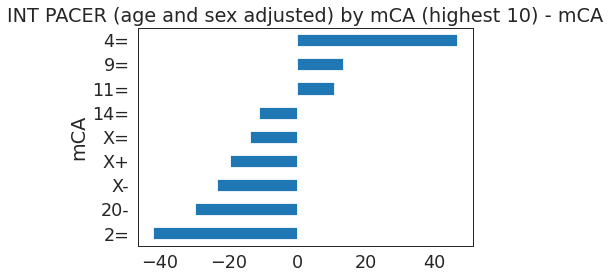

mCA  count       mean         std         min        25%        50%  \
0   4=   12.0  36.912052   60.009578  -94.402150  11.462908  46.596296   
1   9=   28.0  -2.456901   60.290241 -202.980350 -27.407895  13.145724   
2  11=   12.0 -21.973372   77.595834 -150.189889 -79.428536  10.780755   
3  14=   21.0 -32.794168  105.684829 -324.524917 -81.082145 -11.061101   
4   X=   21.0 -33.113000   52.449612 -124.663366 -76.848813 -13.764065   
5   X+   52.0 -16.889128   44.023851 -138.464450 -36.105175 -19.765299   
6   X-  259.0 -32.185959   61.189837 -230.705024 -80.795590 -23.398153   
7  20-   15.0 -26.834465   65.043321 -127.643105 -76.520859 -29.957649   
8   2=   12.0 -40.501518   45.389552 -124.029952 -72.407695 -42.037216   

         75%         max  
0  53.714120  154.115698  
1  36.749131   97.268478  
2  20.748570   96.748200  
3  26.556894  109.239081  
4   8.286447   65.849711  
5  13.801414   66.455816  
6  15.516063  123.865068  
7  10.468900  126.775333  
8  -0.645527   25.627994

In [97]:
get_mca_pacer_pairs(mca_pacer_df_onlychip, 'mCA')

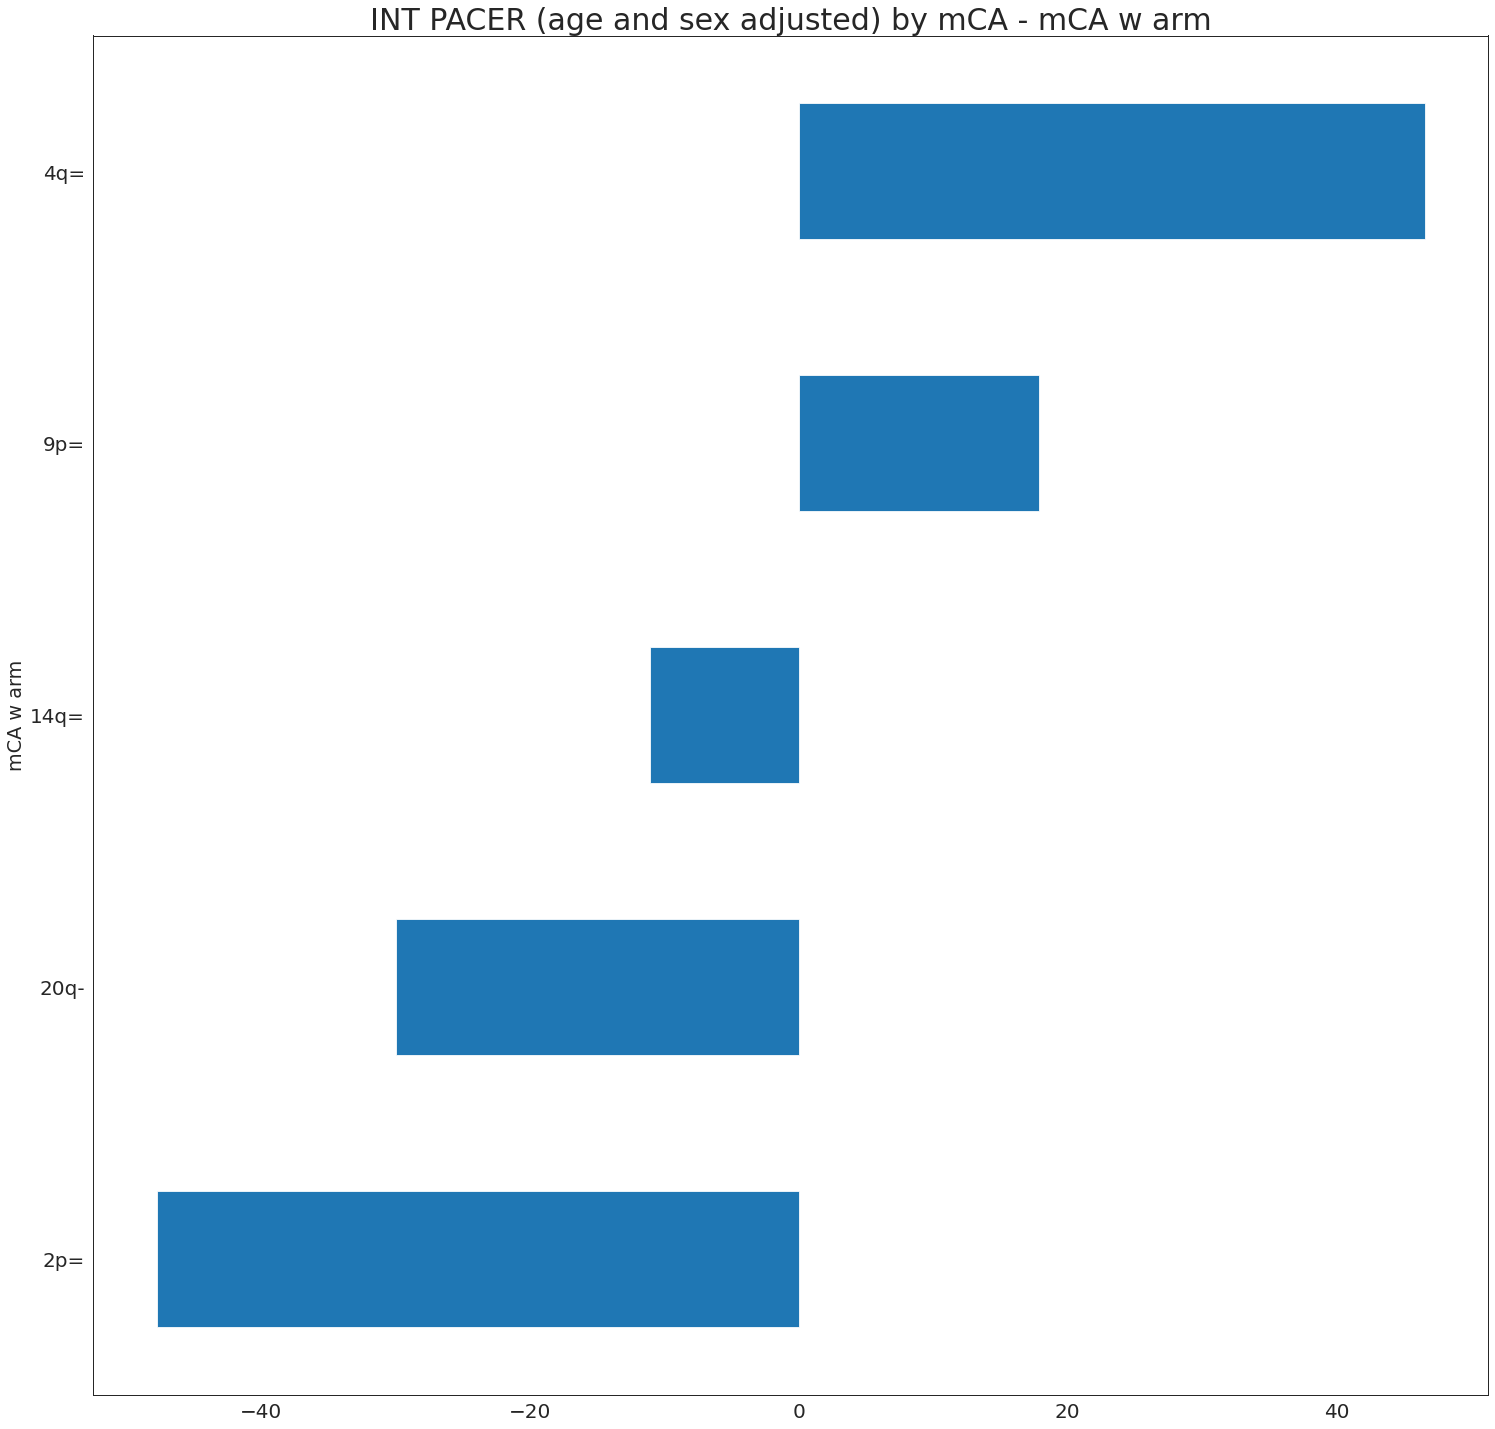

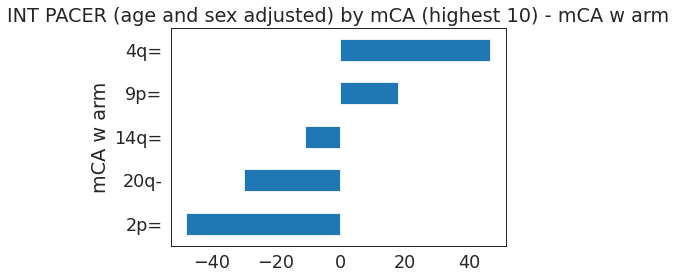

mCA w arm  count       mean         std         min        25%        50%  \
0       4q=   12.0  36.912052   60.009578  -94.402150  11.462908  46.596296   
1       9p=   22.0  -0.804653   66.209520 -202.980350 -23.094898  17.864837   
2      14q=   21.0 -32.794168  105.684829 -324.524917 -81.082145 -11.061101   
3      20q-   15.0 -26.834465   65.043321 -127.643105 -76.520859 -29.957649   
4       2p=   11.0 -44.363895   45.489730 -124.029952 -75.975034 -47.782050   

         75%         max  
0  53.714120  154.115698  
1  43.414734   97.268478  
2  26.556894  109.239081  
3  10.468900  126.775333  
4 -11.050353   25.627994

In [98]:
get_mca_pacer_pairs(mca_pacer_nochrx_df_onlychip, 'mCA w arm')

# Recapitulating Watson and Blundell's results

## What fraction of mCAs by type?

In [107]:
def plot_mCAtype_comparedtoWatson(df):
    gain = 2389
    loss = 3718
    cnloh = 8185
    tot = gain+loss+cnloh
    df = df[~(df['type'] == 'Undetermined')]
    counts_df = pd.DataFrame(data = list(df['type'].value_counts(normalize=True)))
    counts_df.index = ['CN-LOH', 'Loss', 'Gain']
    counts_df.columns = ['TOPMed']
    counts_df['UKBB'] = [cnloh/tot, loss/tot, gain/tot]
    counts_df.plot(kind='bar')
    plt.xlabel('Type of mCA')
    plt.ylabel('Fraction')
    plt.title('Proportion of mCAs by type')
    plt.xticks(rotation='horizontal')
    plt.show()

In [100]:
def plotmCAsummary_bymcashort(df):
    df.sort_values(['type_short', 'chrom_short'], inplace=True)
    mcashort_df = df['mca_short'].value_counts(normalize=True, sort=False)
    mcashort_df.plot(kind='bar', fontsize = 14, figsize = (40, 20))
    plt.xlabel('mCA', fontsize=30)
    plt.ylabel('Fraction of all mCAs', fontsize=30)
    plt.title("Fraction of mCAs",fontsize=40)
    plt.xticks(rotation='vertical')
    plt.show()

In [101]:
def dotplot_mCA_cf(df):
    df.sort_values(['type_short', 'chrom_short'], inplace=True)
    df.plot.scatter(x = 'mca_short', y = 'cf', alpha=0.25, fontsize = 18, figsize = (40, 20), grid=True, s=100)
    plt.xlabel('mCA', fontsize=30)
    plt.ylabel('Clonal Fraction', fontsize=30)
    plt.title("Clonal Fraction by mCA", fontsize=40)
    plt.ylim(0,1)
    plt.xlim(-2,90)
    plt.xticks(rotation='vertical')
    plt.show()
    
    plt.figure(figsize=(40,20))
    for index, row in df.iterrows():
        if row['type_short'] == '+':
            plt.scatter(x=row['mca_short'], y=row['cf'], alpha=0.25, s=100, color='r')
        if row['type_short'] == '-':
            plt.scatter(x=row['mca_short'], y=row['cf'], alpha=0.25, s=100, color = 'b')
        if row['type_short'] == '=':
            plt.scatter(x=row['mca_short'], y=row['cf'], alpha=0.25, s=100, color = 'y')
        if row['type_short'] == 'U':
            plt.scatter(x=row['mca_short'], y=row['cf'], alpha=0.25, s=100, color = 'gray')
    plt.grid(True)
    plt.xlabel('mCA', fontsize=30)
    plt.ylabel('Clonal Fraction', fontsize=30)
    plt.title("Clonal Fraction by mCA", fontsize=40)
    plt.ylim(0,1)
    plt.xlim(-2,90)
    plt.xticks(rotation='vertical', fontsize=20)
    plt.yticks(fontsize=30)
    plt.show()


In [271]:
def dotplot_mCA_cf_nou(df, filename):
    df.sort_values(['type_short', 'chrom_short'], inplace=True)
    df.plot.scatter(x = 'mca_short', y = 'cf', alpha=0.25, fontsize = 18, figsize = (40, 20), grid=True, s=100)
    plt.xlabel('mCA', fontsize=30)
    plt.ylabel('Clonal Fraction', fontsize=30)
    plt.title("Clonal Fraction by mCA", fontsize=40)
    plt.ylim(0,1)
    plt.xlim(-2,90)
    plt.xticks(rotation='vertical')
    plt.show()
    
    plt.figure(figsize=(40,20))
    for index, row in df.iterrows():
        if row['type_short'] == '+':
            plt.scatter(x=row['mca_short'], y=row['cf'], alpha=0.25, s=100, color='r')
        if row['type_short'] == '-':
            plt.scatter(x=row['mca_short'], y=row['cf'], alpha=0.25, s=100, color = 'b')
        if row['type_short'] == '=':
            plt.scatter(x=row['mca_short'], y=row['cf'], alpha=0.25, s=100, color = 'y')
    plt.grid(True)
    plt.xlabel('mCA', fontsize=40)
    plt.ylabel('Clonal Fraction', fontsize=40)
#     plt.title("Clonal Fraction by mCA", fontsize=40)
    plt.ylim(0,1)
    plt.xlim(-2,90-23)
    plt.xticks(rotation='vertical', fontsize=25)
    plt.yticks(fontsize=35)
    marker1 = plt.scatter([],[], c='r')
    marker2 = plt.scatter([],[], c='b')
    marker3 = plt.scatter([],[], c='y')
    legend_markers = [marker1, marker2, marker3]

    labels = ['Gain', 'Loss', 'CN-LOH']

    legend= plt.legend(handles=legend_markers, labels=labels,
                        frameon=True, fontsize=30)

    plt.savefig(filename, dpi=300)
    plt.show()


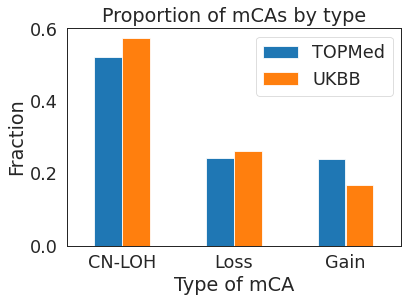

In [108]:
plot_mCAtype_comparedtoWatson(mocha_df_nochrx)

/opt/conda/lib/python3.7/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


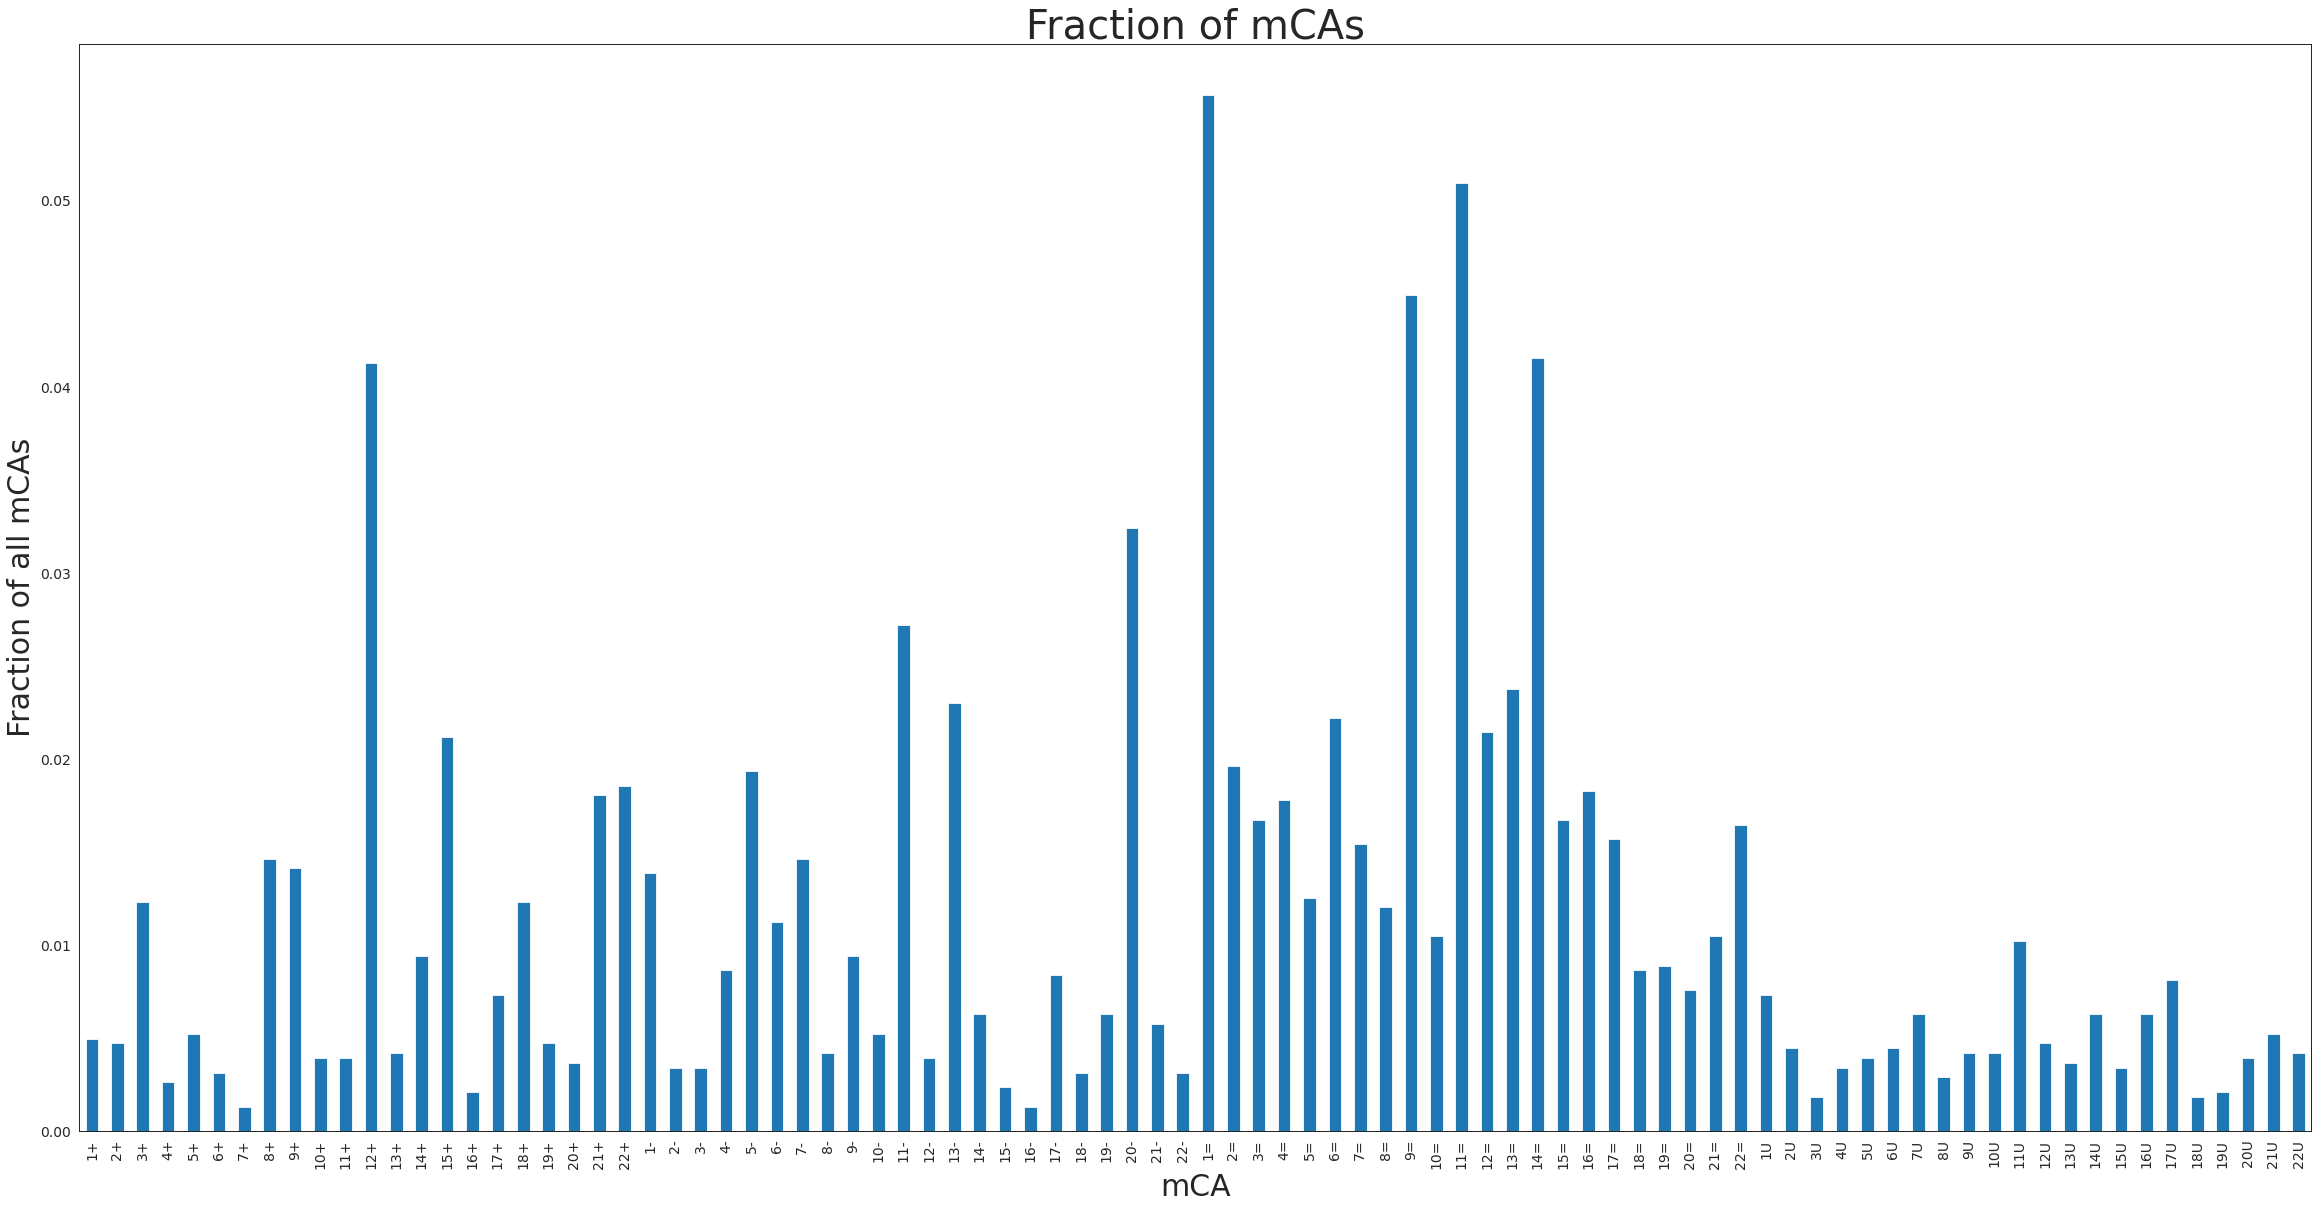

In [104]:
plotmCAsummary_bymcashort(mocha_df_nochrx)

## What are the clonal fractions by chromosome?

/opt/conda/lib/python3.7/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


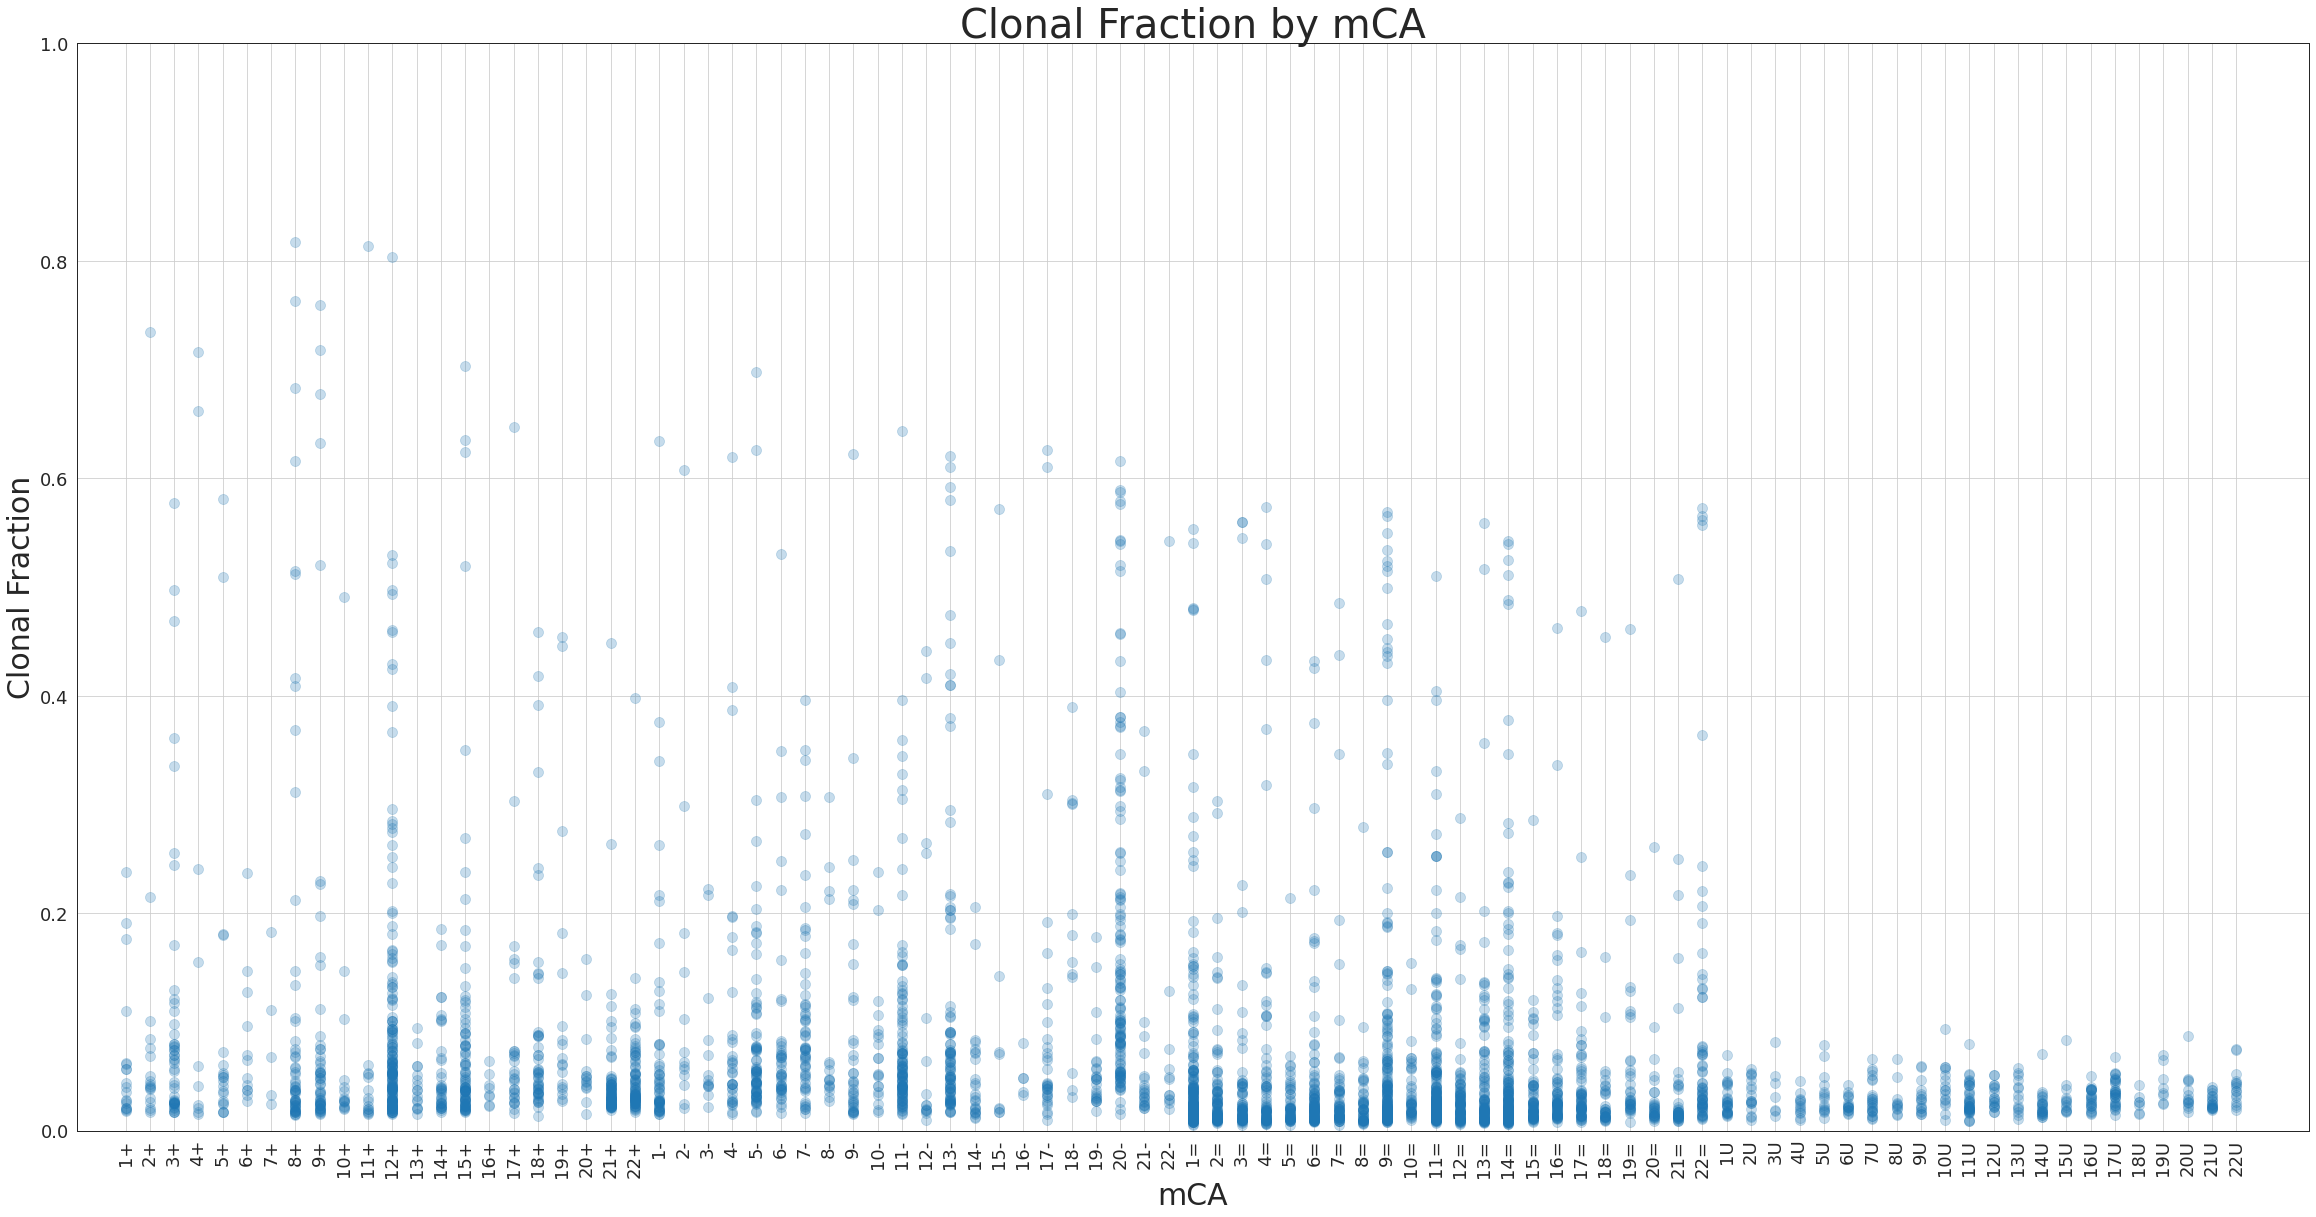

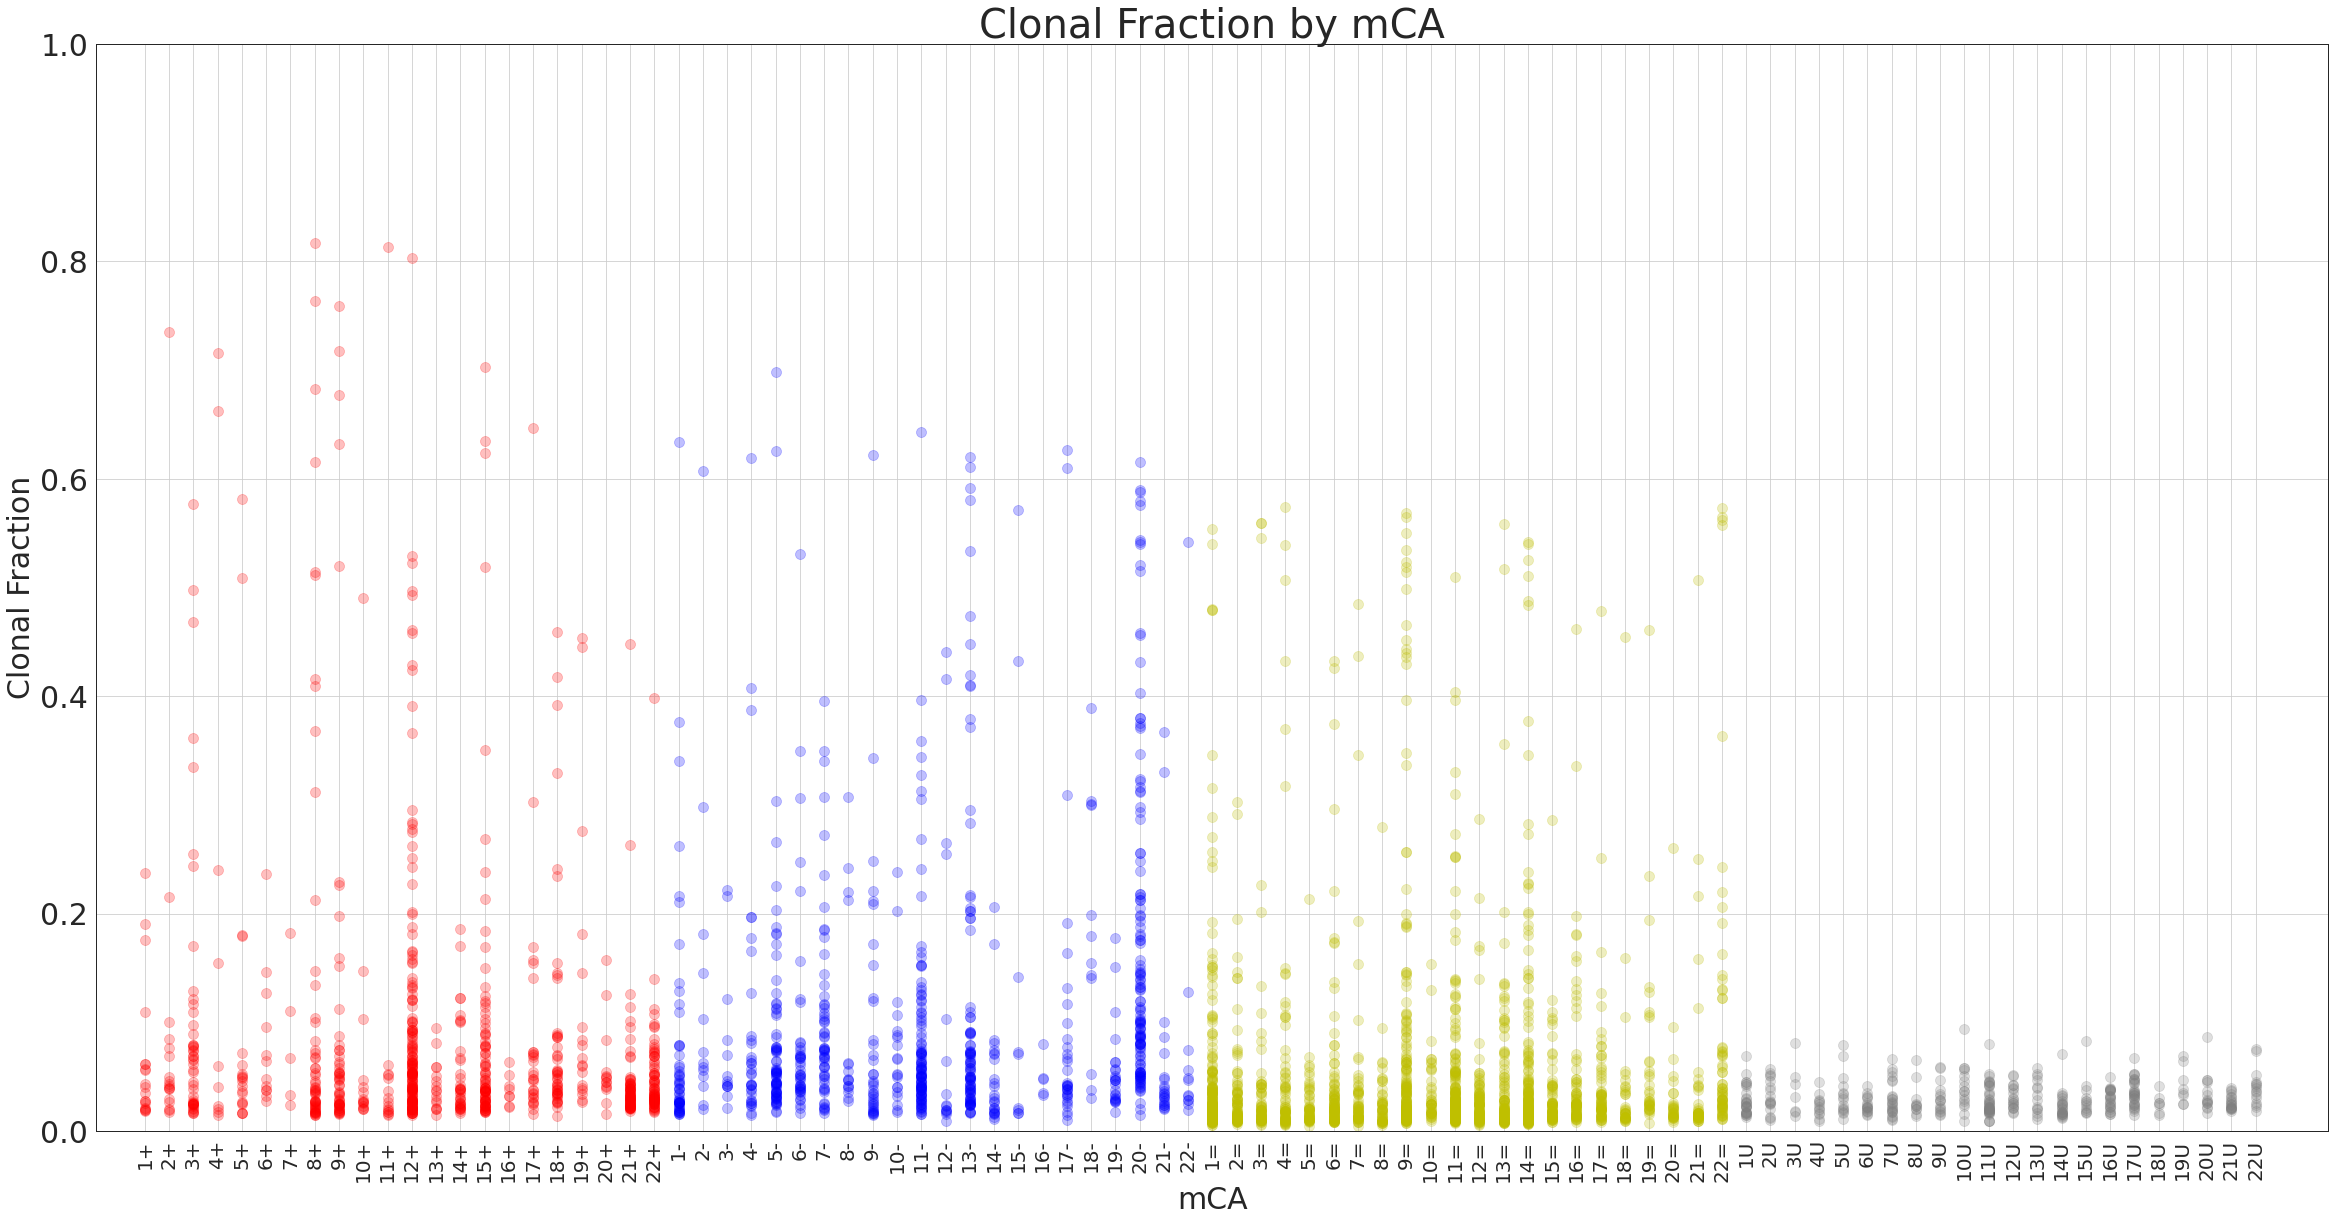

In [269]:
dotplot_mCA_cf(mocha_df_nochrx)

/opt/conda/lib/python3.7/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


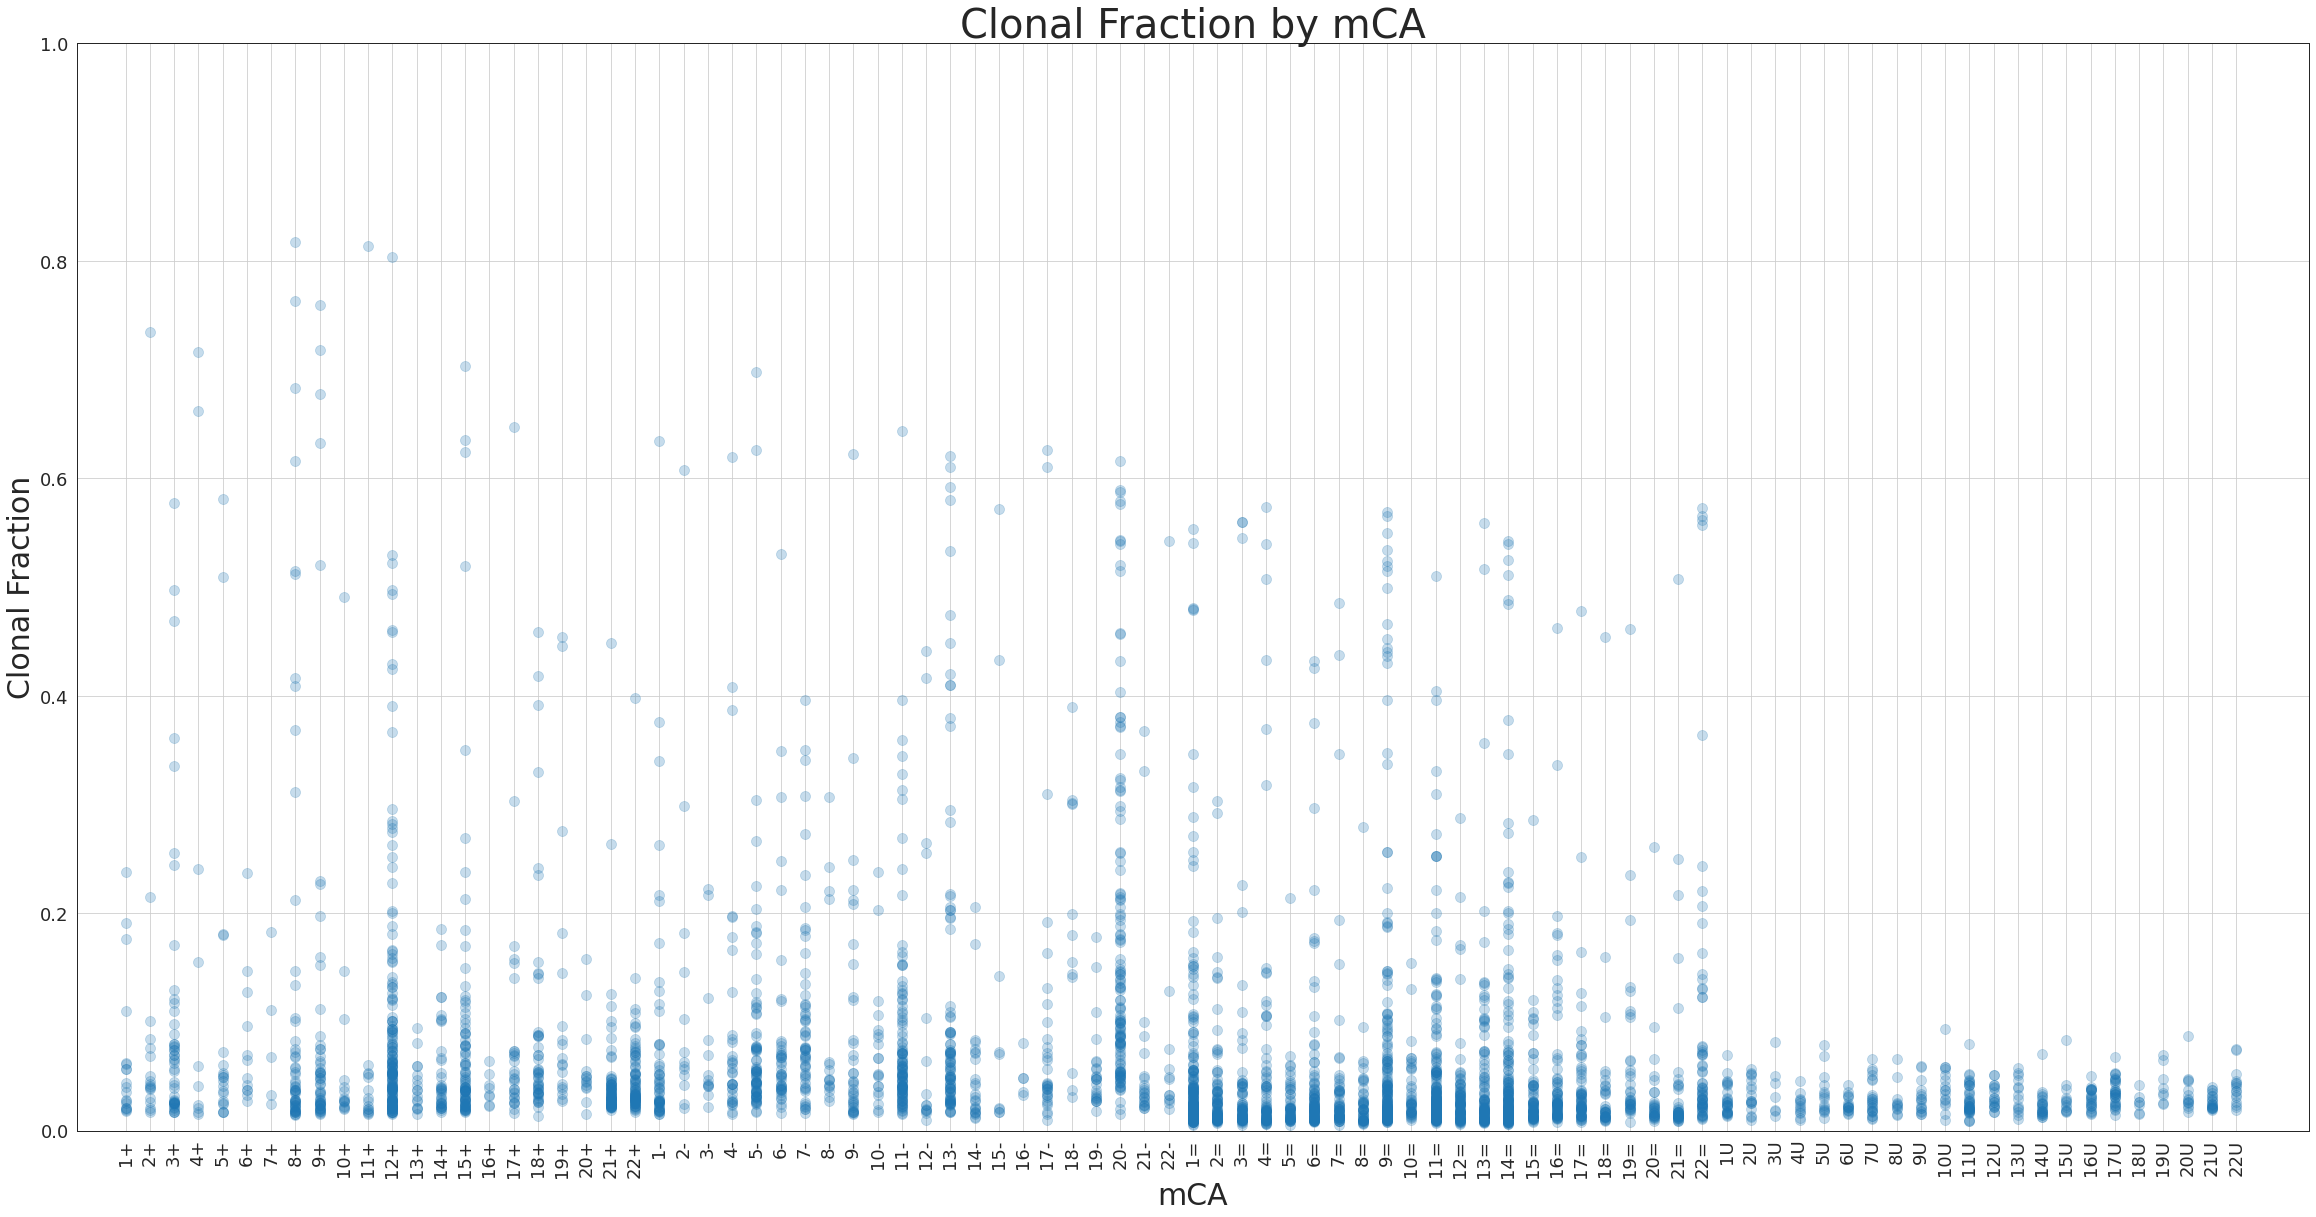

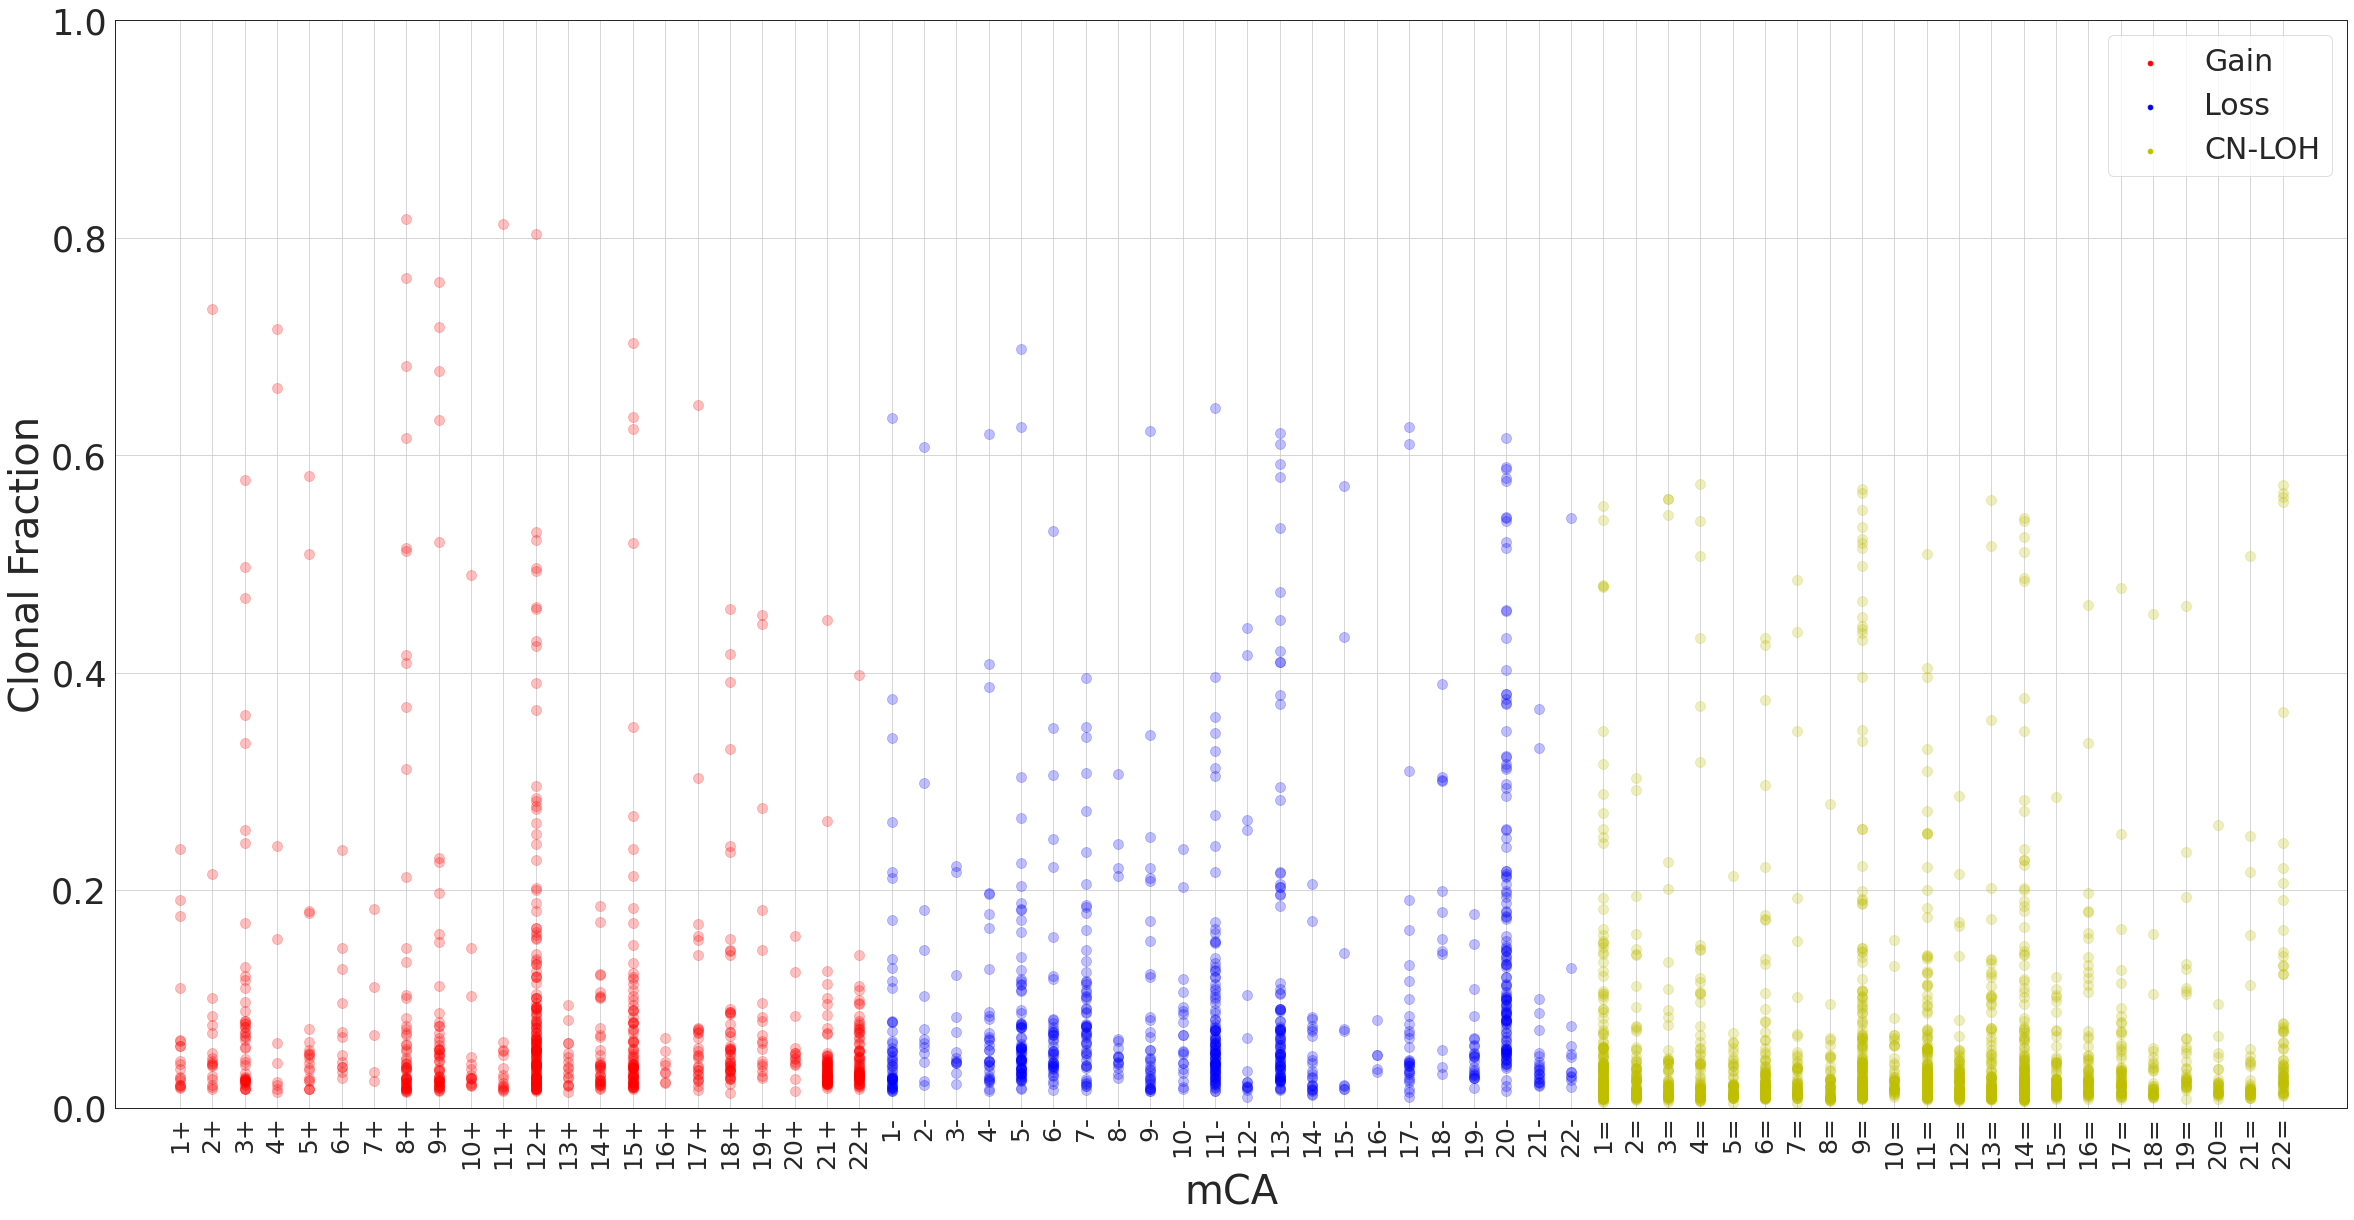

In [272]:
dotplot_mCA_cf_nou(mocha_df_nochrx, 'fig1c_cfdotplot.tif')

In [273]:
! gsutil cp fig1c_cfdotplot.tif gs://fc-secure-827e3d9c-02b8-499f-91af-c2142b7d2074/mCA_pacer/figures/fig1c_cfdotplot.tif

Copying file://fig1c_cfdotplot.tif [Content-Type=image/tiff]...
==> NOTE: You are uploading one or more large file(s), which would run          
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

- [1 files][274.7 MiB/274.7 MiB]                                                
Operation completed over 1 objects/274.7 MiB.                                    


## Using PACER to estimate fitness 

In [112]:
def get_mca_pacer_pairs_nocountfilter(df, col):
    mcas_pacerscore_summary = df.groupby(col).describe()['pacer_covadj_int']
#     mcas_pacerscore_summary_filtered = mcas_pacerscore_summary[mcas_pacerscore_summary['count']>10]
    mcas_pacerscore_summary_filtered = mcas_pacerscore_summary.sort_values(by=['50%'], ascending = False)
    mcas_pacerscore_summary_filtered = mcas_pacerscore_summary_filtered.reset_index(level=0)
    mcas_pacerscore_summary_filtered=mcas_pacerscore_summary_filtered[~mcas_pacerscore_summary_filtered[col].str.contains("U")]

    mcas_pacerscore_summary_filtered.sort_values(by=['50%'], ascending = True).plot(kind='barh', y='50%', x=col, figsize=(25,25), 
                                          fontsize=20, legend=False)
    plt.title("INT PACER (age and sex adjusted) by mCA - " + col, fontsize=30)
    plt.show()
    mcas_pacerscore_summary_filtered.head(10).sort_values(by=['50%'], ascending = True).plot(kind='barh', y='50%', x=col,
                                          legend=False)
    plt.title("INT PACER (age and sex adjusted) by mCA (highest 10) - " + col)
    plt.show()
    return mcas_pacerscore_summary_filtered.head(10)

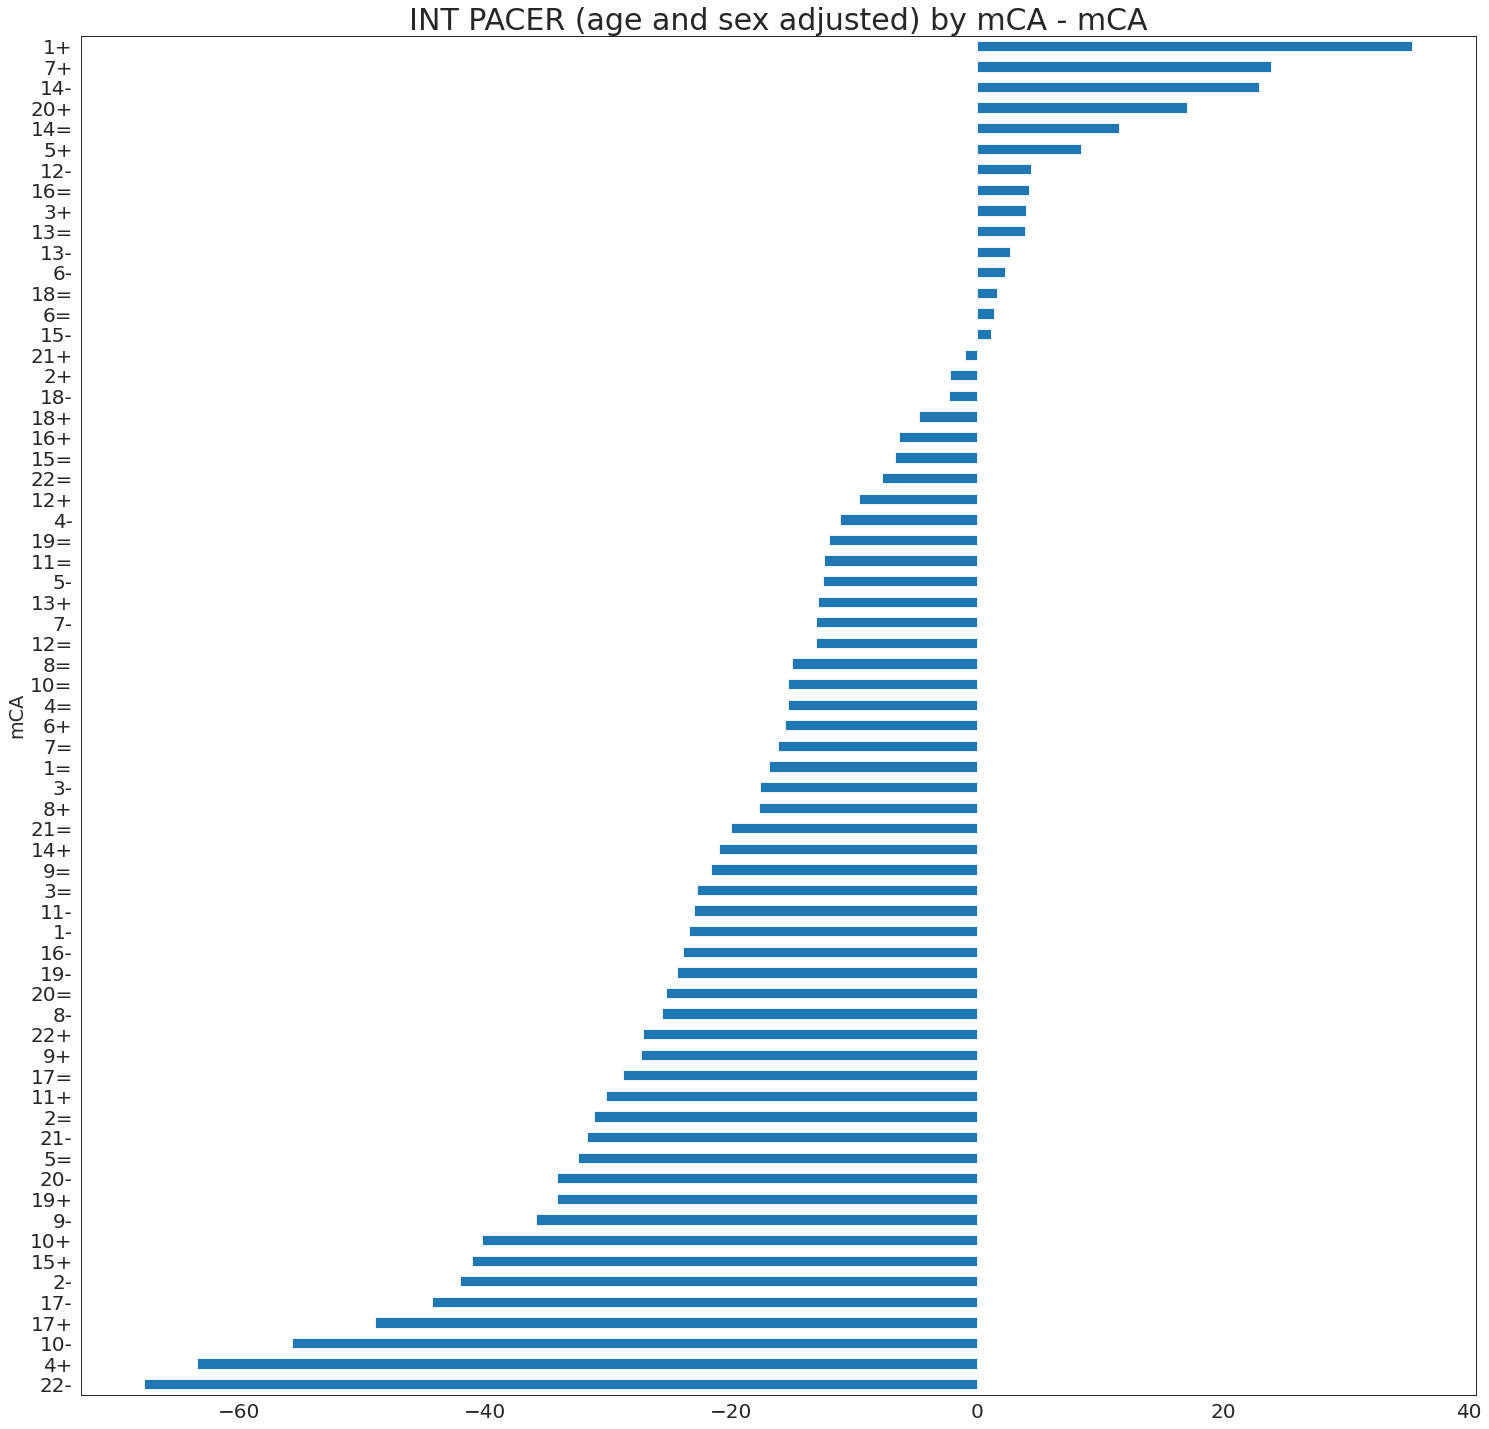

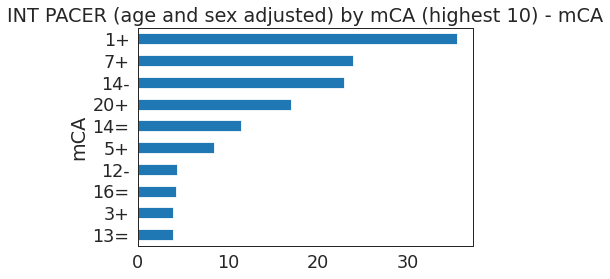

mCA  count       mean        std         min        25%        50%  \
0    1+    6.0  44.790104  69.431946  -32.908453   0.875474  35.387067   
2    7+    1.0  23.846110        NaN   23.846110  23.846110  23.846110   
3   14-   11.0  29.590785  47.775123  -40.340092   2.796734  22.908987   
5   20+    6.0  20.748443  92.277857  -97.198476 -20.957251  17.027829   
6   14=   90.0   5.606789  51.952006 -133.362325 -24.117173  11.495597   
8    5+    6.0 -10.604009  53.588008 -111.730613 -17.314173   8.438210   
11  12-   11.0 -13.404581  90.889093 -267.109306 -21.465113   4.398262   
12  16=   42.0  -5.210153  36.175042  -83.647779 -36.201068   4.179604   
13   3+   10.0   4.456602  42.425806  -60.237223 -31.320871   3.942050   
14  13=   45.0   9.159438  77.543195 -195.316460 -44.770110   3.869606   

          75%         max  
0   67.521628  163.270182  
2   23.846110   23.846110  
3   57.814101  105.811029  
5   34.727674  180.624799  
6   37.299102  160.646477  
8   17.168815   37.049424  
11  20.599817   75.830340  
12  19.309393   73.571421  
13  39.119472   62.065495  
14  54.805326  221.265581

In [113]:
get_mca_pacer_pairs_nocountfilter(mca_pacer_nochrx_df_nochip, 'mCA')

## Not enough sample size to replicate their fitness effect (s) estimations, so we will use PACER instead

Assuming that N$\tau$ = 100,000, we can use the log-binned histogram for each mCA to estimate N$\tau$, $\mu$, and s, 

where N is stem cell population, $\tau$ is symmetric cell division time, $\mu$ is mutation rate, and s = mCA fitness effect 

In [114]:
counts_df = mocha_df_nochrx.groupby('mca_short').describe()['cf']

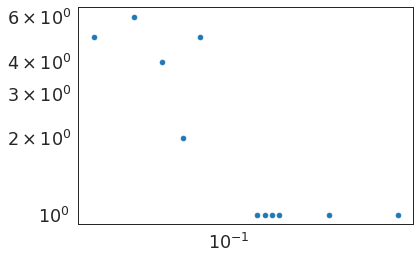

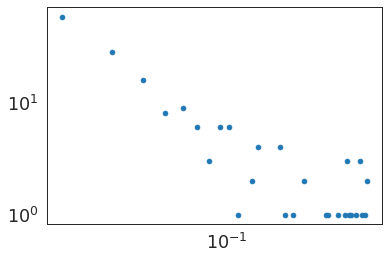

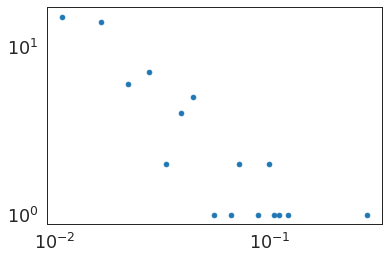

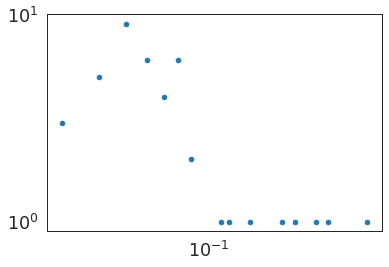

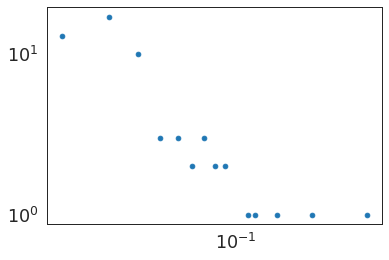

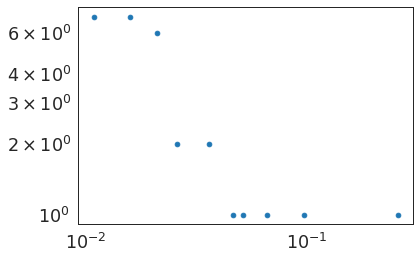

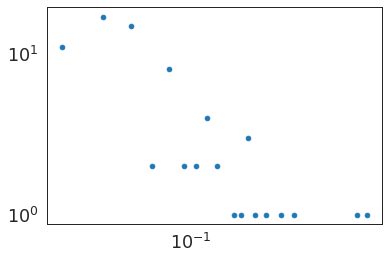

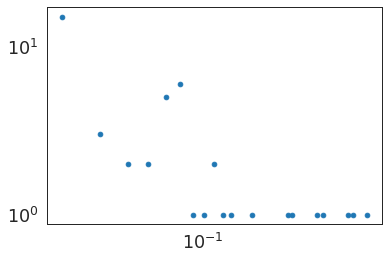

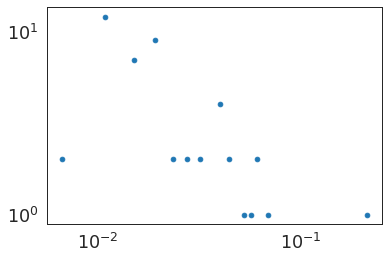

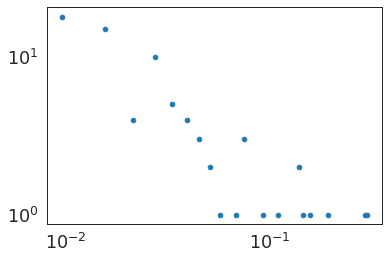

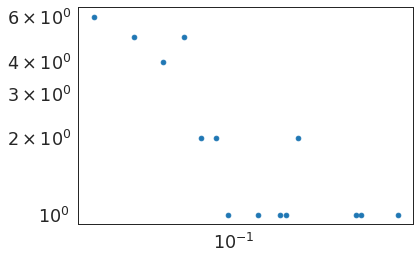

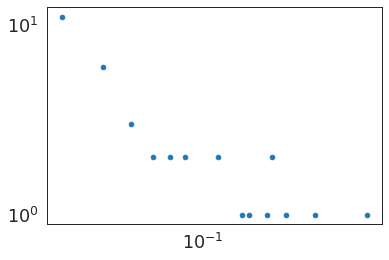

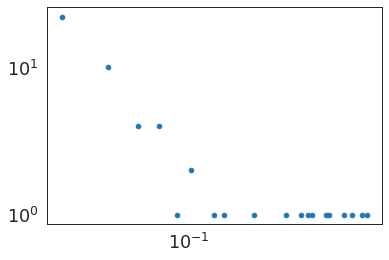

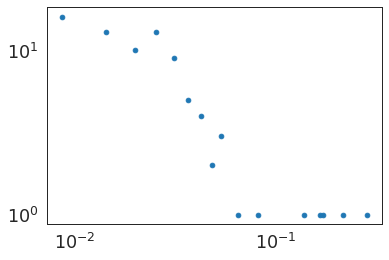

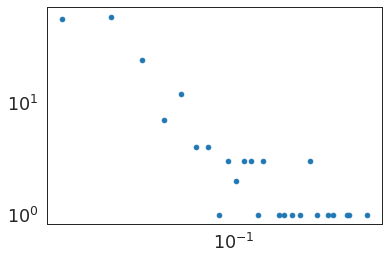

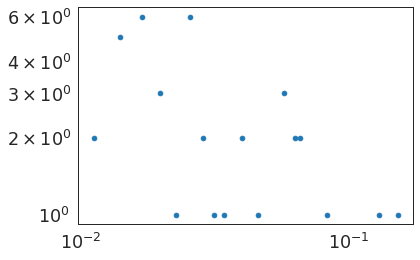

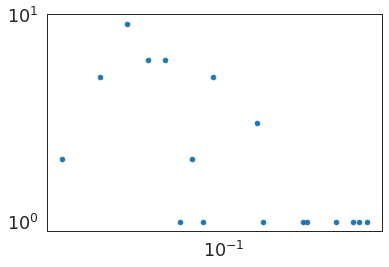

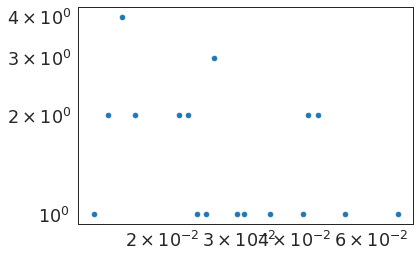

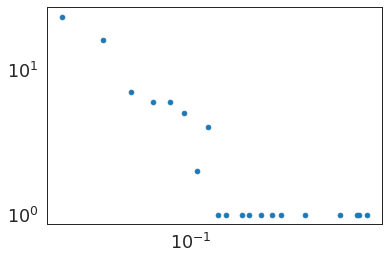

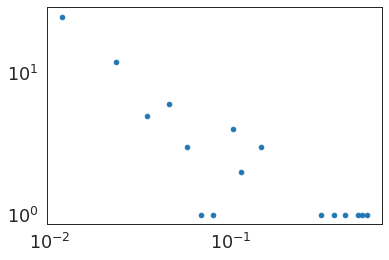

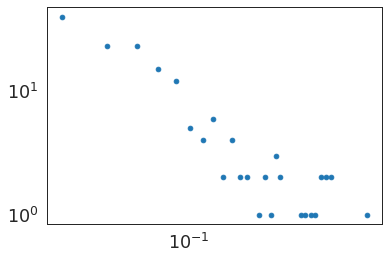

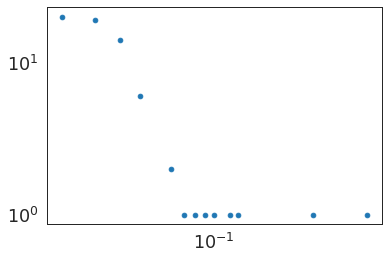

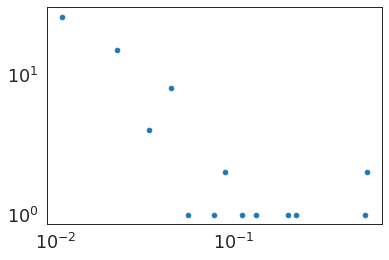

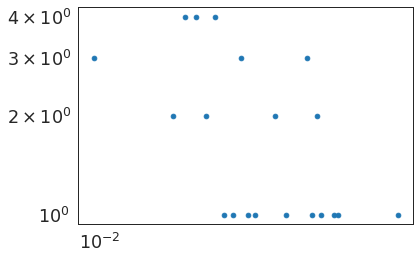

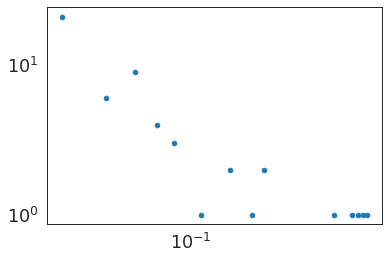

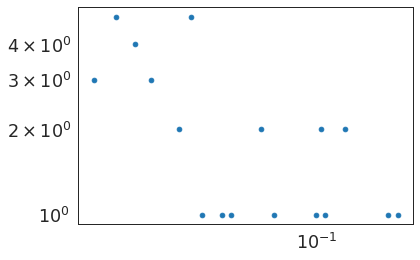

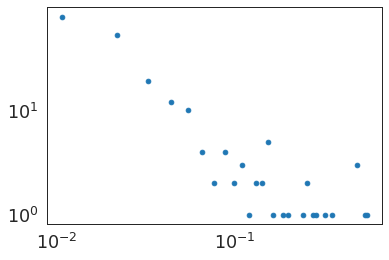

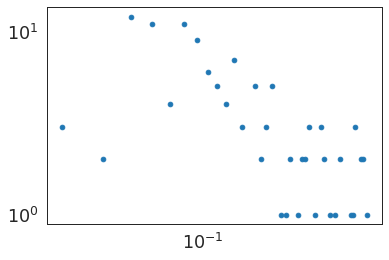

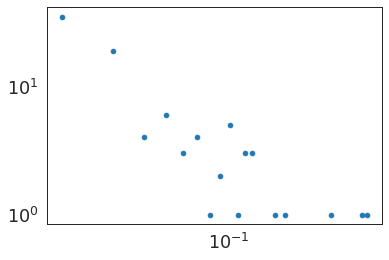

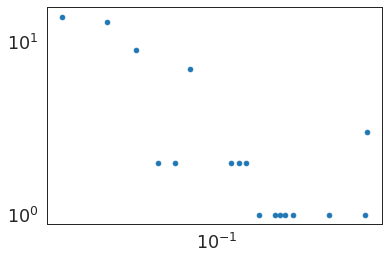

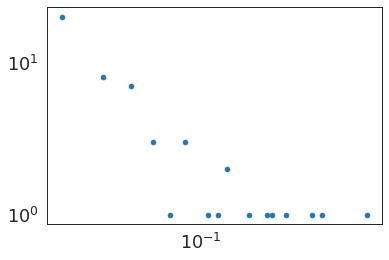

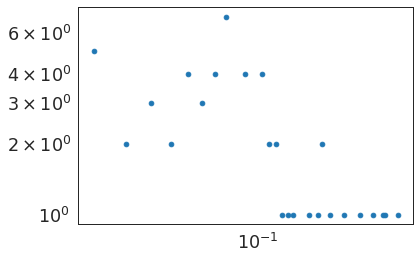

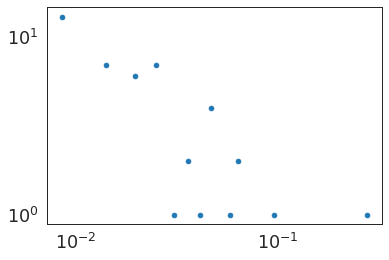

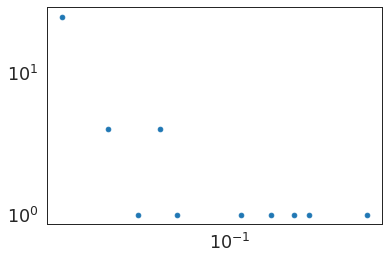

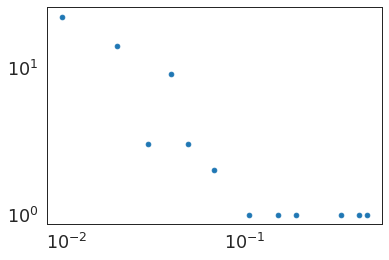

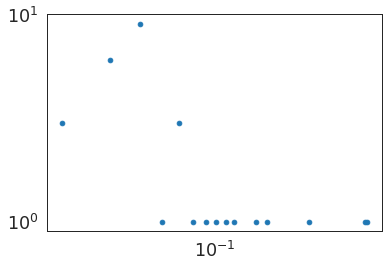

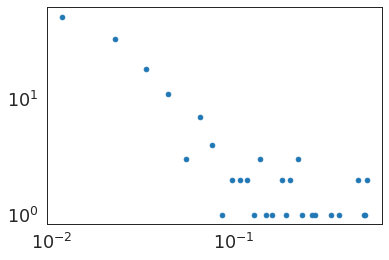

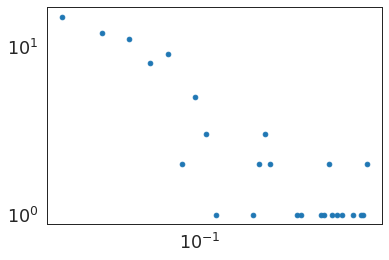

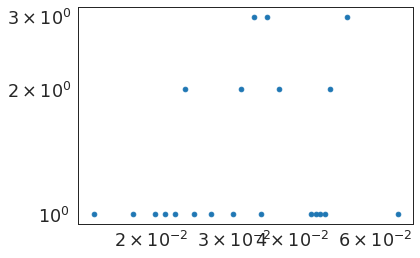

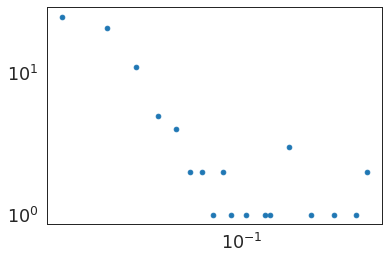

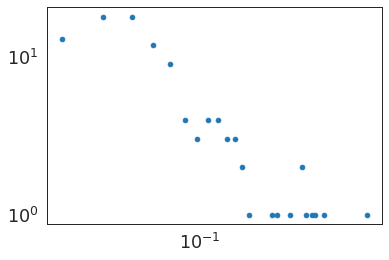

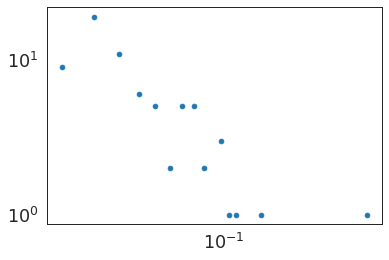

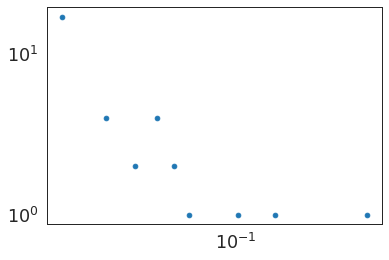

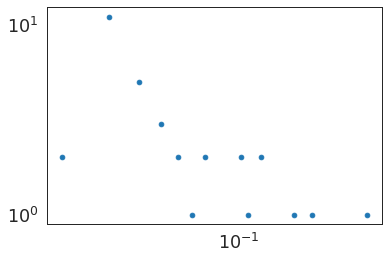

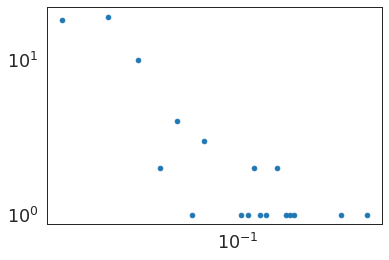

In [115]:
for mca in set(counts_df[counts_df['count'] > 25].index):
    hist, bin_edges = np.histogram(mocha_df_nochrx[mocha_df_nochrx['mca_short']==mca]['cf'], 
                                   bins=50, density=False)
    bin_center = (bin_edges[:-1] + bin_edges[1:])/2
    plt.figure()
    # plt.hist(mocha_df_nochrx[mocha_df_nochrx['mca_short']=='14=']['cf'], bins=50, density=False)
    plt.scatter(bin_center, hist)
    plt.yscale('log')
    plt.xscale('log')
    plt.show()


## Correlation of fitness between Watson and Blundell and PACER

In [116]:
! gsutil cp gs://fc-secure-827e3d9c-02b8-499f-91af-c2142b7d2074/mCA_pacer/wb_fitness.txt .

Copying gs://fc-secure-827e3d9c-02b8-499f-91af-c2142b7d2074/mCA_pacer/wb_fitness.txt...
/ [1 files][  1.3 KiB/  1.3 KiB]                                                
Operation completed over 1 objects/1.3 KiB.                                      


In [117]:
wb_fitness = pd.read_csv('wb_fitness.txt', header = None)
fitness = wb_fitness.iloc[0,0].split(" ")
chr_counts =  wb_fitness.iloc[1,0].split(" ")
counts = []
chrom = []
for i in range(0,len(chr_counts)):
    if i % 2 == 1:
        counts.append(chr_counts[i])
    else:
        chrom.append(chr_counts[i])
wb_fitness_df = pd.DataFrame([chrom, counts, fitness]).T
wb_fitness_df.drop(wb_fitness_df.tail(1).index,inplace=True)
wb_fitness_df.columns = ['chr', 'counts', 'fitness']
wb_fitness_df['fitness'] = pd.to_numeric(wb_fitness_df['fitness'])

In [118]:
wb_fitness_dict = pd.Series(wb_fitness_df.fitness.values,index=wb_fitness_df.chr).to_dict()

### Total passengers by pt not mCA

Method: Fill in W&B fitness for a given pt based on their mCA

In [119]:
mca_pacer_nochrx_df_nochip['wb_fitness'] = mca_pacer_nochrx_df_nochip['mCA w arm'].map(wb_fitness_dict)
mca_pacer_nochrx_df_nochip = mca_pacer_nochrx_df_nochip[~mca_pacer_nochrx_df_nochip['wb_fitness'].isna()]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [120]:
model = smf.glm('wb_fitness~age+sex_dummy+total_pass_mut', data=mca_pacer_nochrx_df_nochip)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:             wb_fitness   No. Observations:                 1522
Model:                            GLM   Df Residuals:                     1518
Model Family:                Gaussian   Df Model:                            3
Link Function:               identity   Scale:                          3.0491
Method:                          IRLS   Log-Likelihood:                -3006.0
Date:                Fri, 19 Aug 2022   Deviance:                       4628.6
Time:                        14:49:34   Pearson chi2:                 4.63e+03
No. Iterations:                     3   Pseudo R-squ. (CS):            0.02468
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         12.2163      0.259     47.156      0.000      11.709      12.724
age                0.0103      0.004      2.561      0.010       0.002       0.018
sex_dummy          0.2214      0.091      2.444      0.015       0.044       0.399
total_pass_mut     0.0025      0.001      3.981      0.000       0.001       0.004
==================================================================================
"""

### Total Passenger Mutations

In [121]:
def get_mca_pacer_pairs_wbfitness(df, col, num_filt):
    mcas_pacerscore_summary = df.groupby(col).describe()[['total_pass_mut', 'age', 'cf']]
    mcas_pacerscore_summary_filtered = mcas_pacerscore_summary[mcas_pacerscore_summary['total_pass_mut']['count']>num_filt]
#     mcas_pacerscore_summary_filtered = mcas_pacerscore_summary_filtered.sort_values(by=['50%'], ascending = False)
    mcas_pacerscore_summary_filtered = mcas_pacerscore_summary_filtered.reset_index(level=0)
    return mcas_pacerscore_summary_filtered

In [122]:
fitness_df = get_mca_pacer_pairs_wbfitness(mca_pacer_nochrx_df_nochip, 'mCA w arm', 10)
fitness_df['wb_fitness'] = fitness_df['mCA w arm'].map(wb_fitness_dict)

In [123]:
fitness_df['tpm'] = fitness_df['total_pass_mut']['mean']
fitness_df['age_mean'] = fitness_df['age']['mean']
fitness_df['cf_mean'] = fitness_df['cf']['mean']
fitness_df['count'] = fitness_df['age']['count']

In [124]:
model = smf.glm('wb_fitness~tpm+age_mean+cf_mean', data=fitness_df)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:             wb_fitness   No. Observations:                   41
Model:                            GLM   Df Residuals:                       37
Model Family:                Gaussian   Df Model:                            3
Link Function:               identity   Scale:                          1.6761
Method:                          IRLS   Log-Likelihood:                -66.660
Date:                Fri, 19 Aug 2022   Deviance:                       62.016
Time:                        14:49:37   Pearson chi2:                     62.0
No. Iterations:                     3   Pseudo R-squ. (CS):             0.4730
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      9.1720      3.963      2.314      0.021       1.405      16.939
tpm            0.0401      0.012      3.431      0.001       0.017       0.063
age_mean      -0.0017      0.068     -0.025      0.980      -0.136       0.132
cf_mean        8.3872      6.893      1.217      0.224      -5.123      21.898
==============================================================================
"""

In [125]:
model = smf.glm('wb_fitness~age_mean', data=fitness_df)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:             wb_fitness   No. Observations:                   41
Model:                            GLM   Df Residuals:                       39
Model Family:                Gaussian   Df Model:                            1
Link Function:               identity   Scale:                          2.3452
Method:                          IRLS   Log-Likelihood:                -74.625
Date:                Fri, 19 Aug 2022   Deviance:                       91.462
Time:                        14:49:37   Pearson chi2:                     91.5
No. Iterations:                     3   Pseudo R-squ. (CS):             0.1386
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.4956      4.284      0.582      0.560      -5.902      10.893
age_mean       0.1623      0.066      2.463      0.014       0.033       0.291
==============================================================================
"""

In [126]:
model = smf.glm('wb_fitness~cf_mean', data=fitness_df)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:             wb_fitness   No. Observations:                   41
Model:                            GLM   Df Residuals:                       39
Model Family:                Gaussian   Df Model:                            1
Link Function:               identity   Scale:                          2.2793
Method:                          IRLS   Log-Likelihood:                -74.040
Date:                Fri, 19 Aug 2022   Deviance:                       88.891
Time:                        14:49:38   Pearson chi2:                     88.9
No. Iterations:                     3   Pseudo R-squ. (CS):             0.1656
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     11.8398      0.498     23.758      0.000      10.863      12.817
cf_mean       19.7924      7.291      2.715      0.007       5.503      34.082
==============================================================================
"""

In [127]:
model = smf.glm('wb_fitness~tpm', data=fitness_df)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:             wb_fitness   No. Observations:                   41
Model:                            GLM   Df Residuals:                       39
Model Family:                Gaussian   Df Model:                            1
Link Function:               identity   Scale:                          1.6540
Method:                          IRLS   Log-Likelihood:                -67.467
Date:                Fri, 19 Aug 2022   Deviance:                       64.506
Time:                        14:49:40   Pearson chi2:                     64.5
No. Iterations:                     3   Pseudo R-squ. (CS):             0.4558
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      9.1432      0.805     11.362      0.000       7.566      10.720
tpm            0.0449      0.009      4.990      0.000       0.027       0.063
==============================================================================
"""

In [128]:
fitness_df = fitness_df[~fitness_df['wb_fitness'].isna()]

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


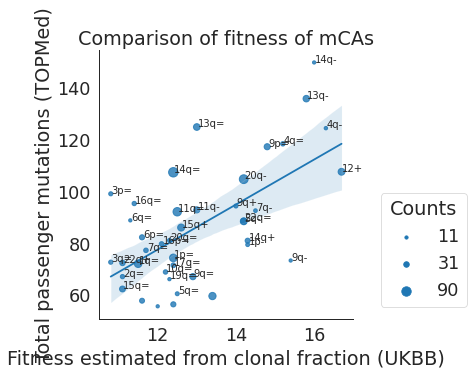

In [129]:
def annotate(data, **kws):
    r, p = pearsonr(data['wb_fitness'], data['tpm'])
    ax = plt.gca()
    ax.text(.05, 0.9, 'Pearson\'s R2={:.2f}'.format(r**2),
            transform=ax.transAxes)
    
    
def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        if point['x']>17 or point['y'] > 60:
            ax.text(point['x']+.02, point['y'], str(point['val']), size=10)

g = sns.lmplot('wb_fitness','tpm', data=fitness_df, scatter_kws={"s": fitness_df['count']})
# g.map_dataframe(annotate)
marker1 = plt.scatter([],[], s=fitness_df['count'].min(), c='C0')
marker2 = plt.scatter([],[], s=fitness_df['count'].mean(), c='C0')
marker3 = plt.scatter([],[], s=fitness_df['count'].max(), c='C0')
legend_markers = [marker1, marker2, marker3]

labels = [
    str(round(fitness_df['count'].min())),
    str(round(fitness_df['count'].mean())),
    str(round(fitness_df['count'].max()))
    ]

legend= plt.legend(handles=legend_markers, labels=labels, title='Counts',
                    frameon=True, bbox_to_anchor=(1.075, 0.5))

plt.xlabel("Fitness estimated from clonal fraction (UKBB)")
plt.ylabel("Total passenger mutations (TOPMed)")
plt.title("Comparison of fitness of mCAs")
label_point(fitness_df['wb_fitness'], fitness_df['tpm'], fitness_df['mCA w arm'], plt.gca())  
plt.show()

In [238]:
def get_text_positions(x_data, y_data, txt_width, txt_height):
    a = zip(y_data, x_data)
    text_positions = y_data.copy()
    for index, (y, x) in enumerate(a):
        local_text_positions = [i for i in a if i[0] > (y - txt_height)
                            and (abs(i[1] - x) < txt_width * 2) and i != (y,x)]
        if local_text_positions:
            sorted_ltp = sorted(local_text_positions)
            if abs(sorted_ltp[0][0] - y) < txt_height: #True == collision
                differ = np.diff(sorted_ltp, axis=0)
                a[index] = (sorted_ltp[-1][0] + txt_height, a[index][1])
                text_positions[index] = sorted_ltp[-1][0] + txt_height
                for k, (j, m) in enumerate(differ):
                    #j is the vertical distance between words
                    if j > txt_height * 1.5: #if True then room to fit a word in
                        a[index] = (sorted_ltp[k][0] + txt_height, a[index][1])
                        text_positions[index] = sorted_ltp[k][0] + txt_height
                        break
    return text_positions


def text_plotter(x_data, y_data, labels, text_positions, axis,txt_width,txt_height):
    for x,y,l,t in zip(x_data, y_data, labels, text_positions):
        axis.text(x - .03, 1.02*t, l,rotation=0, color='black', fontsize=10)
        if y != t:
            axis.arrow(x, t+20,0,y-t, color='black',alpha=0.2, width=txt_width*0.0,
                       head_width=.02, head_length=txt_height*0.5,
                       zorder=0,length_includes_head=True)


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<Figure size 720x720 with 0 Axes>

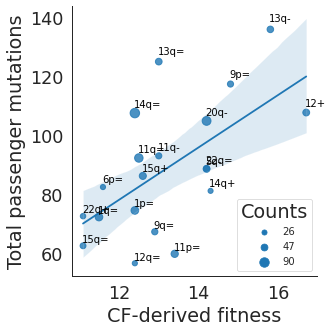

In [287]:
fitness_df = get_mca_pacer_pairs_wbfitness(mca_pacer_nochrx_df_nochip, 'mCA w arm', 25)
fitness_df['wb_fitness'] = fitness_df['mCA w arm'].map(wb_fitness_dict)
fitness_df = fitness_df[~fitness_df['wb_fitness'].isna()]
fitness_df['tpm'] = fitness_df['total_pass_mut']['mean']
fitness_df['age_mean'] = fitness_df['age']['mean']
fitness_df['count'] = fitness_df['age']['count']
fitness_df['cf_mean'] = fitness_df['cf']['mean']

plt.figure(figsize=(10,10))
g = sns.lmplot('wb_fitness','tpm', data=fitness_df, scatter_kws={"s": fitness_df['count']})
# g.map_dataframe(annotate)
marker1 = plt.scatter([],[], s=fitness_df['count'].min(), c='C0')
marker2 = plt.scatter([],[], s=fitness_df['count'].mean(), c='C0')
marker3 = plt.scatter([],[], s=fitness_df['count'].max(), c='C0')
legend_markers = [marker1, marker2, marker3]

labels = [
    str(round(fitness_df['count'].min())),
    str(round(fitness_df['count'].mean())),
    str(round(fitness_df['count'].max()))
    ]

legend= plt.legend(handles=legend_markers, labels=labels, title="Counts",
                    frameon=True, fontsize=10, loc='lower right')

plt.xlabel("CF-derived fitness")
plt.ylabel("Total passenger mutations")
# plt.title("Comparison of fitness of mCAs")
txt_height = 0.08*(plt.ylim()[1] - plt.ylim()[0])
txt_width = 0.06*(plt.xlim()[1] - plt.xlim()[0])
text_positions = get_text_positions(fitness_df['wb_fitness'], fitness_df['tpm'], txt_width, txt_height)
text_plotter(fitness_df['wb_fitness'], fitness_df['tpm'], fitness_df['mCA w arm'], 
             text_positions, g.ax, txt_width, txt_height)
plt.tight_layout()
# label_point(fitness_df['wb_fitness'], fitness_df['tpm'], fitness_df['mCA w arm'], plt.gca())
plt.savefig('fig2c_fitnesscomparison.tif', dpi=300)
plt.show()

In [288]:
!gsutil cp fig2c_fitnesscomparison.tif gs://fc-secure-827e3d9c-02b8-499f-91af-c2142b7d2074/mCA_pacer/figures/fig2c_fitnesscomparison.tif

Copying file://fig2c_fitnesscomparison.tif [Content-Type=image/tiff]...
/ [1 files][  8.6 MiB/  8.6 MiB]                                                
Operation completed over 1 objects/8.6 MiB.                                      


In [131]:
model = smf.glm('wb_fitness~tpm+age_mean+cf_mean', data=fitness_df)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:             wb_fitness   No. Observations:                   20
Model:                            GLM   Df Residuals:                       16
Model Family:                Gaussian   Df Model:                            3
Link Function:               identity   Scale:                          1.4866
Method:                          IRLS   Log-Likelihood:                -30.112
Date:                Fri, 19 Aug 2022   Deviance:                       23.786
Time:                        14:49:59   Pearson chi2:                     23.8
No. Iterations:                     3   Pseudo R-squ. (CS):             0.4885
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.3183      5.273      1.198      0.231      -4.017      16.654
tpm            0.0279      0.016      1.780      0.075      -0.003       0.059
age_mean       0.0567      0.087      0.652      0.515      -0.114       0.227
cf_mean       10.5697      9.122      1.159      0.247      -7.310      28.449
==============================================================================
"""

In [132]:
model = smf.glm('wb_fitness~age_mean', data=fitness_df)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:             wb_fitness   No. Observations:                   20
Model:                            GLM   Df Residuals:                       18
Model Family:                Gaussian   Df Model:                            1
Link Function:               identity   Scale:                          1.9455
Method:                          IRLS   Log-Likelihood:                -33.980
Date:                Fri, 19 Aug 2022   Deviance:                       35.019
Time:                        14:50:01   Pearson chi2:                     35.0
No. Iterations:                     3   Pseudo R-squ. (CS):             0.1904
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.7133      5.672      0.302      0.763      -9.403      12.830
age_mean       0.1753      0.086      2.029      0.042       0.006       0.345
==============================================================================
"""

In [133]:
model = smf.glm('wb_fitness~cf', data=fitness_df)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:             wb_fitness   No. Observations:                   20
Model:                            GLM   Df Residuals:                       11
Model Family:                Gaussian   Df Model:                            8
Link Function:               identity   Scale:                          1.0330
Method:                          IRLS   Log-Likelihood:                -22.725
Date:                Fri, 19 Aug 2022   Deviance:                       11.363
Time:                        14:50:01   Pearson chi2:                     11.4
No. Iterations:                     3   Pseudo R-squ. (CS):             0.8137
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     10.8738      1.372      7.926      0.000       8.185      13.563
cf[0]         -0.0014      0.021     -0.066      0.947      -0.043       0.040
cf[1]       -163.7204    139.433     -1.174      0.240    -437.005     109.564
cf[2]        114.9017     81.278      1.414      0.157     -44.400     274.204
cf[3]        162.2749    105.778      1.534      0.125     -45.046     369.596
cf[4]       -200.9418     86.896     -2.312      0.021    -371.254     -30.630
cf[5]        237.0039     80.154      2.957      0.003      79.904     394.103
cf[6]         23.8879     28.678      0.833      0.405     -32.320      80.095
cf[7]         -8.7320      6.795     -1.285      0.199     -22.049       4.585
==============================================================================
"""

In [134]:
fitness_df = get_mca_pacer_pairs_wbfitness(mca_pacer_nochrx_df_nochip, 'mCA', 25)
fitness_df['tpm'] = fitness_df['total_pass_mut']['mean']
fitness_df['age_mean'] = fitness_df['age']['mean']
fitness_df['count'] = fitness_df['age']['count']

In [135]:
fitness_df.to_csv('PACER_fitness_bymca.csv', header = True, index = False)

In [136]:
! gsutil cp PACER_fitness_bymca.csv gs://fc-secure-827e3d9c-02b8-499f-91af-c2142b7d2074/mCA_pacer/PACER_fitness_bymca.csv 

Copying file://PACER_fitness_bymca.csv [Content-Type=text/csv]...
/ [1 files][  6.5 KiB/  6.5 KiB]                                                
Operation completed over 1 objects/6.5 KiB.                                      


### PACER cov-adj 

In [137]:
def get_mca_pacer_pairs_wbfitness_covadj(df, col, num_filt):
    mcas_pacerscore_summary = df.groupby(col).describe()['pacer_covadj_int_norm']
    mcas_pacerscore_summary_filtered = mcas_pacerscore_summary[mcas_pacerscore_summary['count']>num_filt]
    mcas_pacerscore_summary_filtered = mcas_pacerscore_summary_filtered.sort_values(by=['mean'], ascending = False)
    mcas_pacerscore_summary_filtered = mcas_pacerscore_summary_filtered.reset_index(level=0)
    return mcas_pacerscore_summary_filtered

In [138]:
fitness_df = get_mca_pacer_pairs_wbfitness_covadj(mca_pacer_nochrx_df_nochip, 'mCA w arm', 10)
fitness_df['wb_fitness'] = fitness_df['mCA w arm'].map(wb_fitness_dict)

In [139]:
fitness_df = fitness_df[~fitness_df['wb_fitness'].isna()]

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


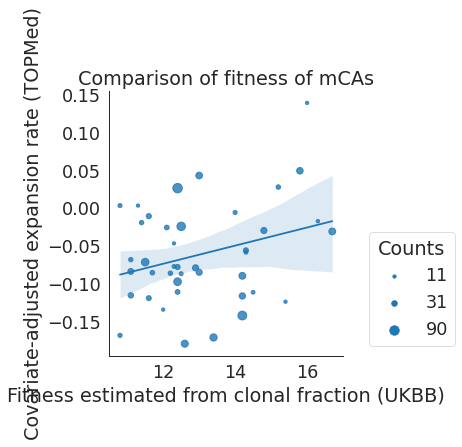

In [140]:
g = sns.lmplot('wb_fitness','mean', data=fitness_df, scatter_kws={"s": fitness_df['count']})
# g.map_dataframe(annotate)
marker1 = plt.scatter([],[], s=fitness_df['count'].min(), c='C0')
marker2 = plt.scatter([],[], s=fitness_df['count'].mean(), c='C0')
marker3 = plt.scatter([],[], s=fitness_df['count'].max(), c='C0')
legend_markers = [marker1, marker2, marker3]

labels = [
    str(round(fitness_df['count'].min())),
    str(round(fitness_df['count'].mean())),
    str(round(fitness_df['count'].max()))
    ]

legend= plt.legend(handles=legend_markers, labels=labels, title='Counts',
                    frameon=True, bbox_to_anchor=(1.075, 0.5))

plt.xlabel("Fitness estimated from clonal fraction (UKBB)")
plt.ylabel("Covariate-adjusted expansion rate (TOPMed)")
plt.title("Comparison of fitness of mCAs")
label_point(fitness_df['wb_fitness'], fitness_df['mean'], fitness_df['mCA w arm'], plt.gca())  
plt.show()

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


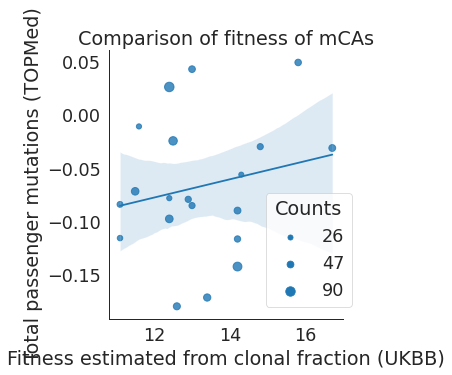

In [141]:
fitness_df = get_mca_pacer_pairs_wbfitness_covadj(mca_pacer_nochrx_df_nochip, 'mCA w arm', 25)
fitness_df['wb_fitness'] = fitness_df['mCA w arm'].map(wb_fitness_dict)
fitness_df = fitness_df[~fitness_df['wb_fitness'].isna()]

g = sns.lmplot('wb_fitness','mean', data=fitness_df, scatter_kws={"s": fitness_df['count']})
# g.map_dataframe(annotate)
marker1 = plt.scatter([],[], s=fitness_df['count'].min(), c='C0')
marker2 = plt.scatter([],[], s=fitness_df['count'].mean(), c='C0')
marker3 = plt.scatter([],[], s=fitness_df['count'].max(), c='C0')
legend_markers = [marker1, marker2, marker3]

labels = [
    str(round(fitness_df['count'].min())),
    str(round(fitness_df['count'].mean())),
    str(round(fitness_df['count'].max()))
    ]

legend= plt.legend(handles=legend_markers, labels=labels, title='Counts',
                    frameon=True, bbox_to_anchor=(1.075, 0.5))

plt.xlabel("Fitness estimated from clonal fraction (UKBB)")
plt.ylabel("Total passenger mutations (TOPMed)")
plt.title("Comparison of fitness of mCAs")
label_point(fitness_df['wb_fitness'], fitness_df['mean'], fitness_df['mCA w arm'], plt.gca())  
plt.show()

## Fold change in total passenger mutations by sex

In [142]:
def get_fold_change_by_sex(input_df):
    mcas = []
    pacer_foldchange_sex_mid = []
    pacer_foldchange_sex_upper = []
    pacer_foldchange_sex_lower = []
    for mca in set(input_df['mCA w arm'].unique()):
        df = input_df[input_df['mCA w arm'] == mca]
        if len(df) > 10 and (len(df.groupby('sex')['total_pass_mut'].describe()['50%']) == 2) and 'U' not in mca:
            #if counts > 10 and data is available for both M and F
            m50, f50 = df.groupby('sex')['total_pass_mut'].describe()['50%']
            m25, f25 = df.groupby('sex')['total_pass_mut'].describe()['25%']
            m75, f75 = df.groupby('sex')['total_pass_mut'].describe()['75%']
            mcas.append(mca)
            pacer_foldchange_sex_mid.append(m50/f50)
            pacer_foldchange_sex_upper.append(m75/f75)
            pacer_foldchange_sex_lower.append(m25/f75)

    pacer_foldchange_sex_df = pd.DataFrame(data=zip(mcas,pacer_foldchange_sex_mid, 
                                                    pacer_foldchange_sex_lower, pacer_foldchange_sex_upper))
    pacer_foldchange_sex_df.sort_values(1, ascending=True, inplace=True)
    return pacer_foldchange_sex_df

def plot_foldchangebysex(df):
    fig = plt.figure(figsize=(10,15))
    ax = fig.add_subplot(111)
    plt.errorbar(df[1], df[0], 
             xerr = [df[2], df[3]], marker='o', mfc='blue',
             ms=10, linestyle='', ecolor='black')  # Stem ends
    plt.grid()
    a = ax.get_xgridlines()
    b = a[2]
    b.set_color('orange')
    b.set_linewidth(3)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=12)
    plt.xlabel("Fold Change (M:F)", fontsize=18)
    plt.ylabel("mCAs", fontsize=18)
    plt.title("Fold Change in Total Passenger Mutations by Sex", fontsize=20)
    plt.show()

In [143]:
topmed_foldchange_fitness_sex = get_fold_change_by_sex(mca_pacer_nochrx_df)
for index, row in topmed_foldchange_fitness_sex.iterrows():
    if row[1] < 1: 
        topmed_foldchange_fitness_sex.loc[index, 1] = -1/row[1]

In [144]:
wb_foldchange_fitness_sex = pd.read_csv('gs://fc-secure-827e3d9c-02b8-499f-91af-c2142b7d2074/mCA_pacer/wb_foldchange_fitness_sex.txt', sep='\t')

In [145]:
topmed_foldchange_fitness_sex = topmed_foldchange_fitness_sex[[0,1]].set_index(0)

In [146]:
wb_foldchange_fitness_sex = wb_foldchange_fitness_sex.set_index('mCA')

In [147]:
combo_fitness_sex = topmed_foldchange_fitness_sex.join(wb_foldchange_fitness_sex)

In [148]:
combo_fitness_sex = combo_fitness_sex[~combo_fitness_sex['Fold Change'].isna()]

In [149]:
combo_fitness_sex['sign'] = combo_fitness_sex[1] - combo_fitness_sex['Fold Change']

In [150]:
wilcoxon(combo_fitness_sex[1], combo_fitness_sex['Fold Change'])

WilcoxonResult(statistic=110.0, pvalue=0.03419689190108084)

### For all pts

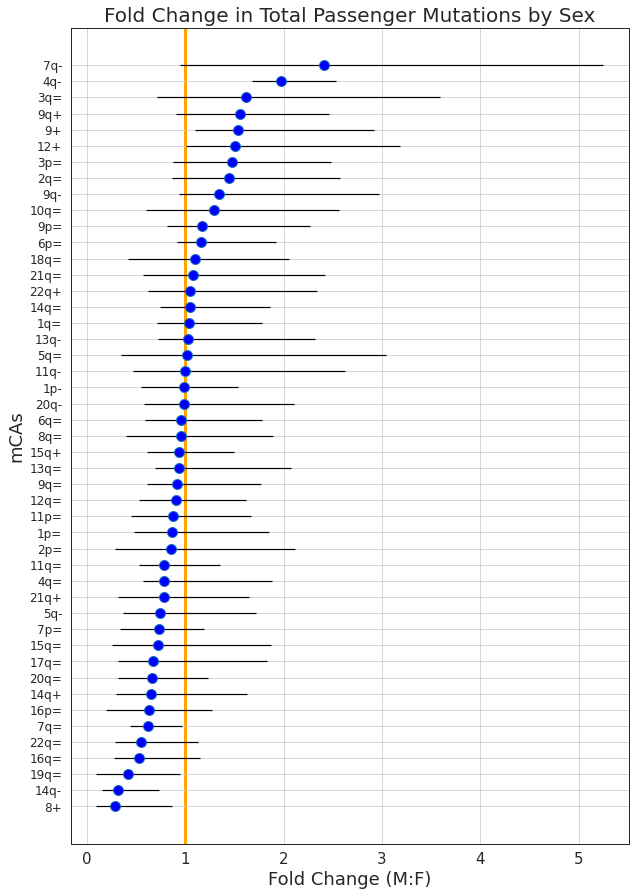

In [151]:
plot_foldchangebysex(get_fold_change_by_sex(mca_pacer_nochrx_df))

### Excluding CHIP pts

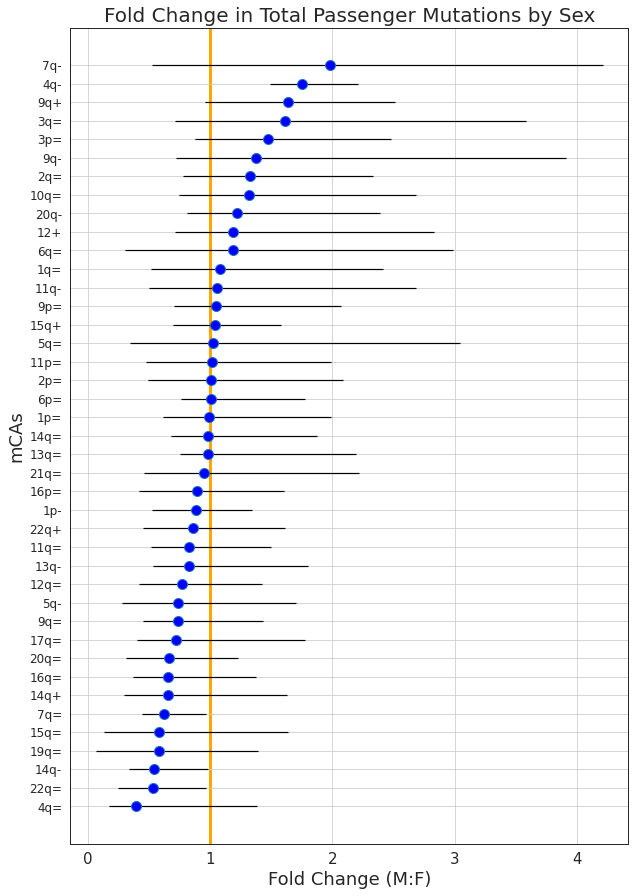

In [152]:
plot_foldchangebysex(get_fold_change_by_sex(mca_pacer_nochrx_df_nochip))

### For only CHIP pts

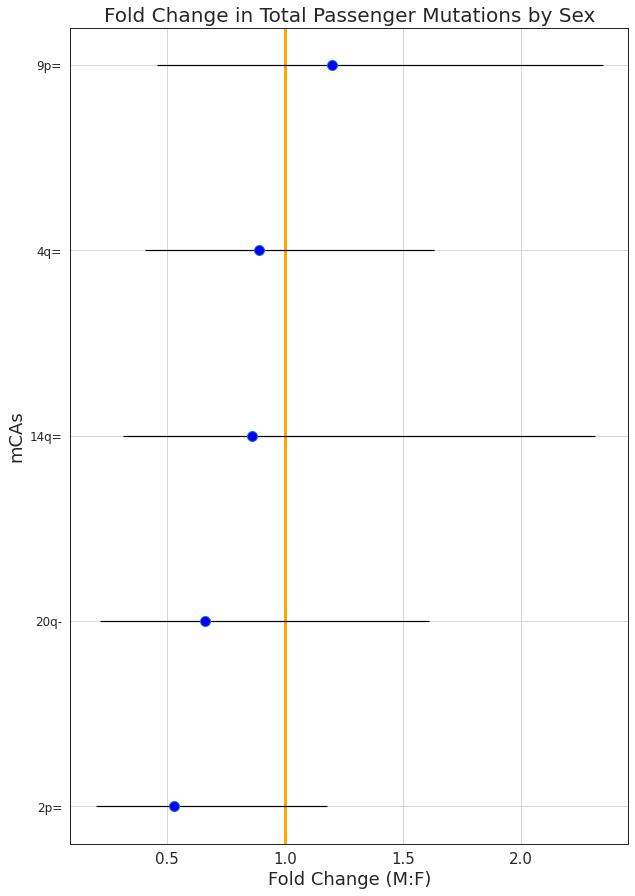

In [153]:
plot_foldchangebysex(get_fold_change_by_sex(mca_pacer_nochrx_df_onlychip))

In [202]:
def dotplot_mCA_pacer(df_mca, df_pacer, filename, errorbars = True):
    df_mca = df_mca.rename(columns={"sample_id": "sample.id"})
    df = pd.merge(df_pacer, df_mca, on='sample.id')
    type_short_dict = pd.Series(df.type_short.values,index=df['mca_short']).to_dict()
    chrom_short_dict = pd.Series(df.chrom_short.values,index=df['mca_short']).to_dict()
    pacer_by_chr = df.groupby('mca_short')['pacer_covadj_int'].describe()
    pacer_by_chr = pacer_by_chr.reset_index(level=0)
    pacer_by_chr['type_short'] = pacer_by_chr['mca_short'].map(type_short_dict)
    pacer_by_chr['chrom_short'] = pacer_by_chr['mca_short'].map(chrom_short_dict)
    pacer_by_chr['foldchange_25%'] = pacer_by_chr['25%']/abs(float(pacer_by_chr.loc[pacer_by_chr['mca_short']=='X-','25%']))
    pacer_by_chr['foldchange_50%'] = pacer_by_chr['50%']/abs(float(pacer_by_chr.loc[pacer_by_chr['mca_short']=='X-','50%']))
    pacer_by_chr['foldchange_75%'] = pacer_by_chr['75%']/abs(float(pacer_by_chr.loc[pacer_by_chr['mca_short']=='X-','75%']))
    pacer_by_chr['foldchange_iqr'] = pacer_by_chr['foldchange_75%'] - pacer_by_chr['foldchange_25%']
    pacer_by_chr = pacer_by_chr[pacer_by_chr['chrom_short']!='X']
    pacer_by_chr['chrom_short'] = pd.to_numeric(pacer_by_chr['chrom_short'])
    pacer_by_chr.sort_values(['type_short', 'chrom_short'], inplace=True)
    fig, ax = plt.subplots(figsize=(40,20))
    
    if errorbars: 
        for index, row in pacer_by_chr.iterrows():
            if (row['type_short'] == '+') and (row['count']>25):
                sc = plt.scatter(x=row['chrom_short'], y=row['foldchange_50%'], s=row['count']*25, color='r',
                            edgecolors='black', label='Gain')
                plt.errorbar(row['chrom_short'], row['foldchange_50%'], yerr=row['foldchange_iqr'], fmt="none", ecolor='r')
            if (row['type_short'] == '-') and (row['count']>25):
                sc = plt.scatter(x=row['chrom_short'], y=row['foldchange_50%'], s=row['count']*25, color = 'b', 
                            edgecolors='black', label = 'Loss')
                plt.errorbar(row['chrom_short'], row['foldchange_50%'], yerr=row['foldchange_iqr'], fmt="none", ecolor='b')
            if (row['type_short'] == '=') and (row['count']>25):
                sc = plt.scatter(x=row['chrom_short'], y=row['foldchange_50%'], s=row['count']*25, color = 'y',
                            edgecolors='black', label = 'CN-LOH')
                plt.errorbar(row['chrom_short'], row['foldchange_50%'], yerr=row['foldchange_iqr'], fmt="none", ecolor='y')

    else:
        for index, row in pacer_by_chr.iterrows():
            if row['type_short'] == '+':
                sc = plt.scatter(x=row['chrom_short'], y=row['foldchange_50%'], s=row['count']*25, color='r',
                            edgecolors='black', label='Gain')
            if row['type_short'] == '-':
                sc = plt.scatter(x=row['chrom_short'], y=row['foldchange_50%'], s=row['count']*25, color = 'b', 
                            edgecolors='black', label = 'Loss')
            if row['type_short'] == '=':
                sc = plt.scatter(x=row['chrom_short'], y=row['foldchange_50%'], s=row['count']*25, color = 'y',
                            edgecolors='black', label = 'CN-LOH')
        plt.yticks(np.arange(round(min(pacer_by_chr['foldchange_50%']),0), round(max(pacer_by_chr['foldchange_50%']),0)+1, 1.0))

    plt.grid(True)
    plt.xlabel('Chr', fontsize=40)
    plt.ylabel('Fold change in clonal expansion rate compared to X-', fontsize=40)
    plt.xticks(pacer_by_chr['chrom_short'].unique(), fontsize=40)
    plt.ylim(-3.5,3.5)
    plt.yticks(fontsize=40)    
    marker_gain = plt.scatter([],[], c='r', edgecolors='black', s=1000)
    marker_loss = plt.scatter([],[], c='b', edgecolors='black', s =1000)
    marker_cnloh = plt.scatter([],[], c='y', edgecolors='black', s=1000)
    legend_markers = [marker_gain, marker_loss, marker_cnloh]
    labels = ['Gain', 'Loss', 'CN-LOH']
    legend1 = plt.legend(handles=legend_markers, labels=labels, fontsize = 30, 
                         frameon=False, title='Copy change', loc = 'upper left',
                        title_fontsize=30, bbox_to_anchor=(1.0, 0.7))
    
    marker1 = plt.scatter([],[], s=pacer_by_chr['count'].min()*25, c='white', edgecolors='black')
    marker2 = plt.scatter([],[], s=pacer_by_chr['count'].mean()*25, c='white', edgecolors='black')
    marker3 = plt.scatter([],[], s=pacer_by_chr['count'].max()*25, c='white', edgecolors='black')
    legend_markers = [marker1, marker2, marker3]

    labels = [
        str(round(pacer_by_chr['count'].min())),
        str(round(pacer_by_chr['count'].mean()+2)),
        str(round(pacer_by_chr['count'].max()-7))
        ]

    legend2= plt.legend(handles=legend_markers, labels=labels,labelspacing = 3, 
                        handlelength = 5, fontsize = 15, 
                        frameon=False, title='Counts', title_fontsize=30, bbox_to_anchor=(1.075, 0.5))
    
    ax.add_artist(legend1)
    ax.add_artist(legend2)
    
    plt.axhline(y=2, color='orange', linestyle='-')
    plt.text(21.5, 2, 'DNMT3A', fontsize=30, rotation=0)
    
    plt.savefig(filename, dpi=300)
    
    plt.show()

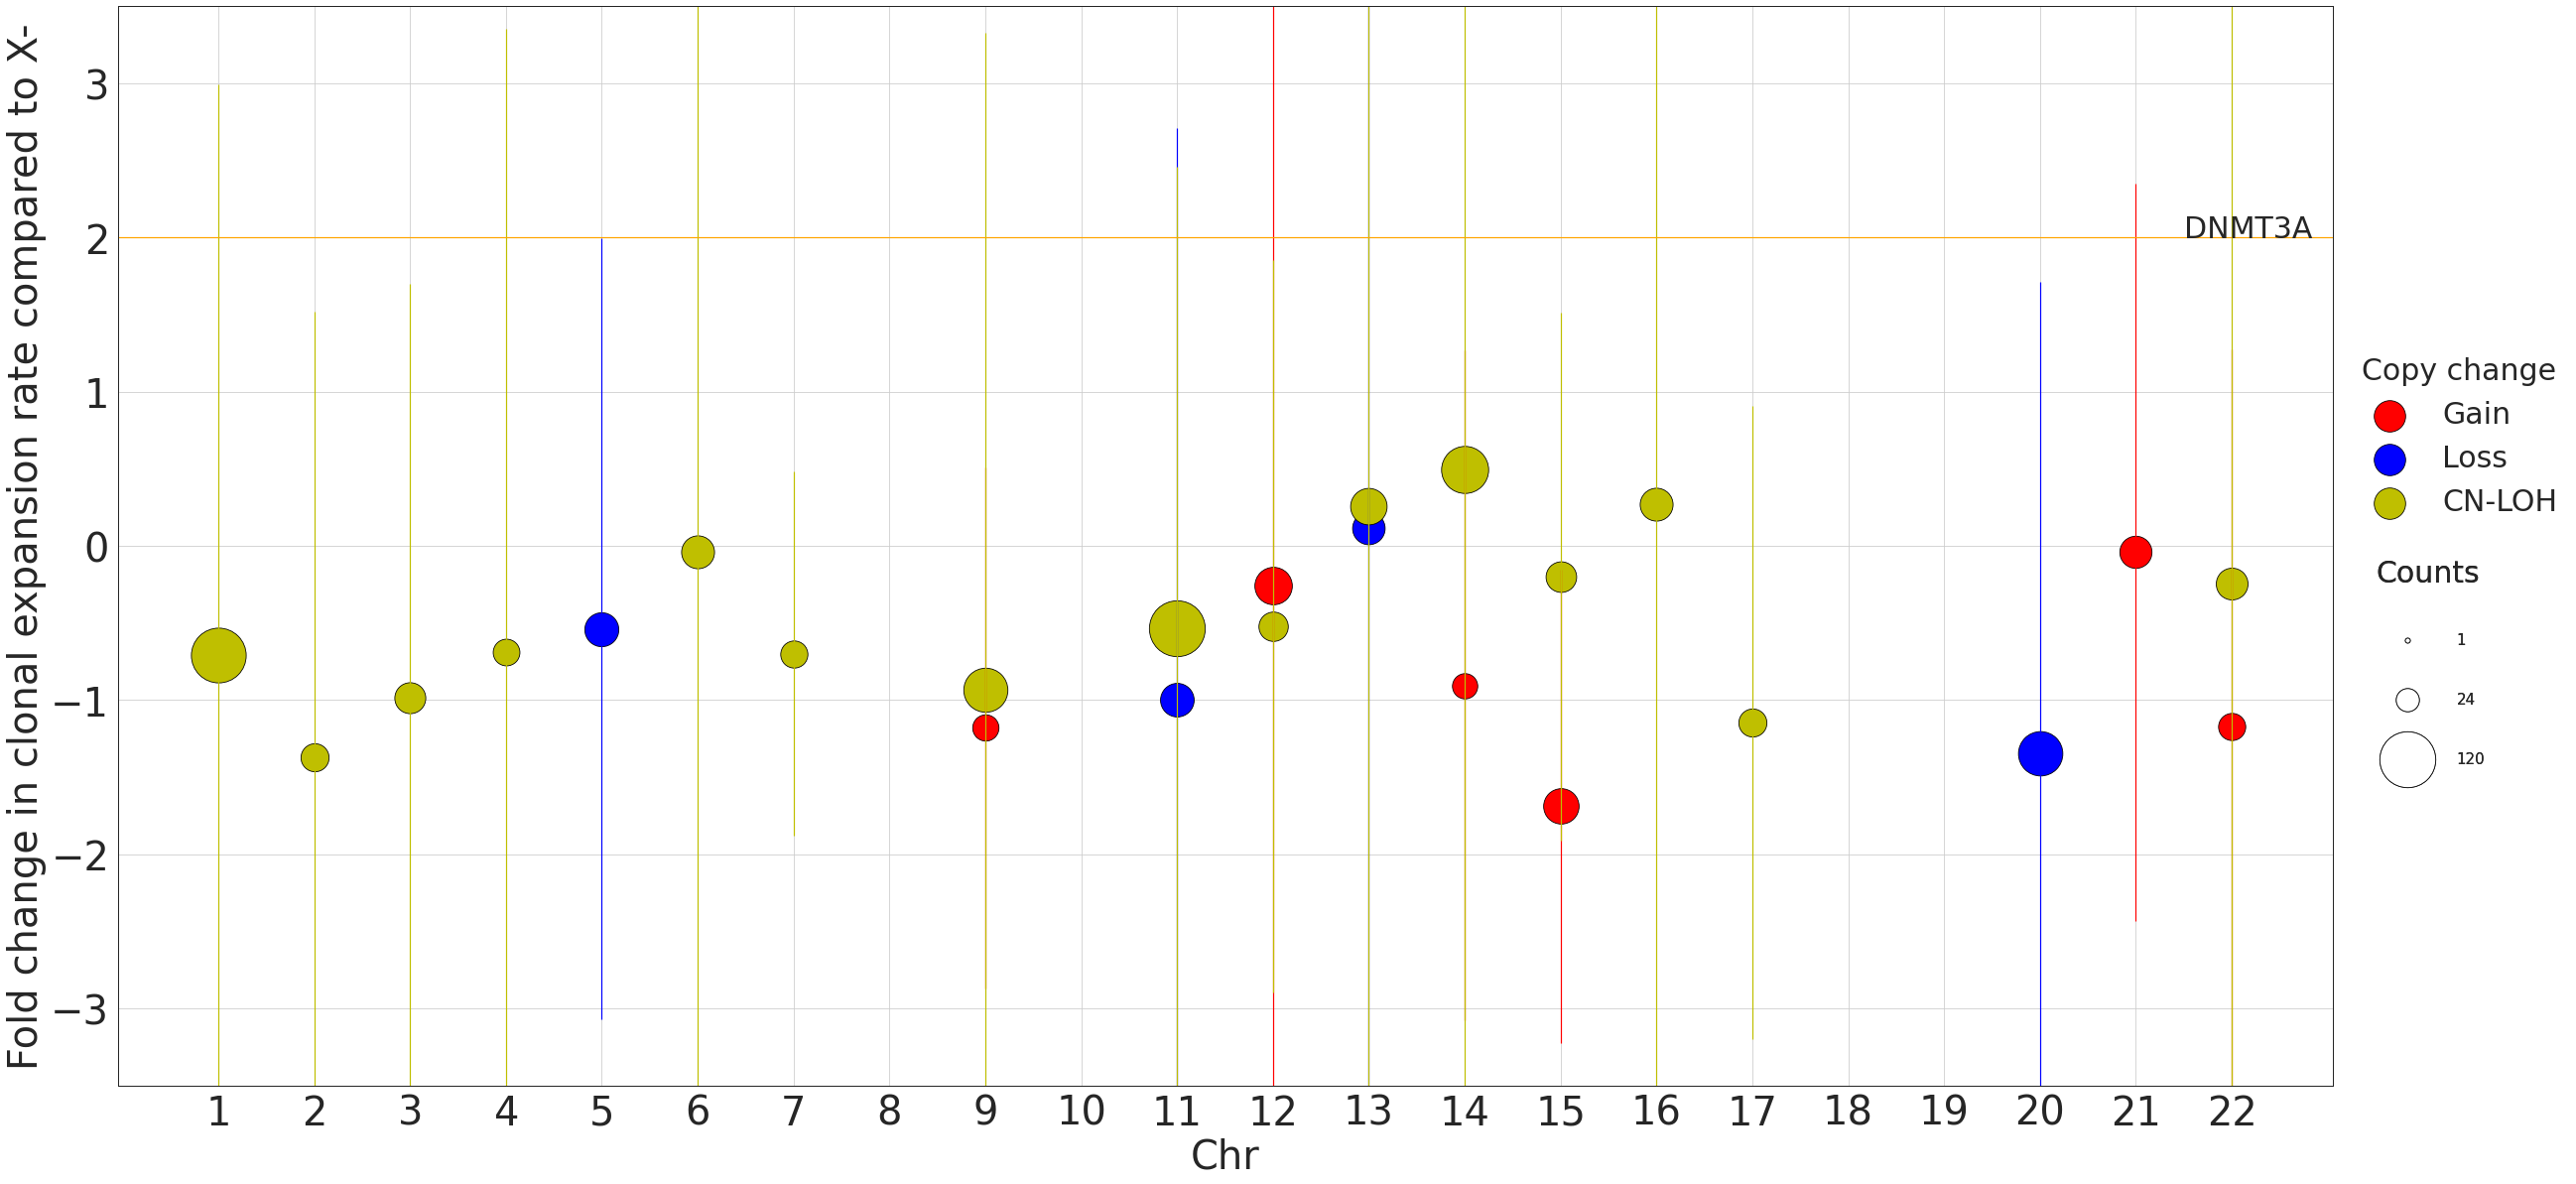

In [203]:
dotplot_mCA_pacer(mocha_df, mca_pacer_df_nochip, 'fig2b_fitnessdotploterrorbars.tif')

In [205]:
! gsutil cp fig2b_fitnessdotploterrorbars.tif gs://fc-secure-827e3d9c-02b8-499f-91af-c2142b7d2074/mCA_pacer/figures/fig2b_fitnessdotploterrorbars.tif

Copying file://fig2b_fitnessdotploterrorbars.tif [Content-Type=image/tiff]...
==> NOTE: You are uploading one or more large file(s), which would run          
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

- [1 files][274.7 MiB/274.7 MiB]                                                
Operation completed over 1 objects/274.7 MiB.                                    


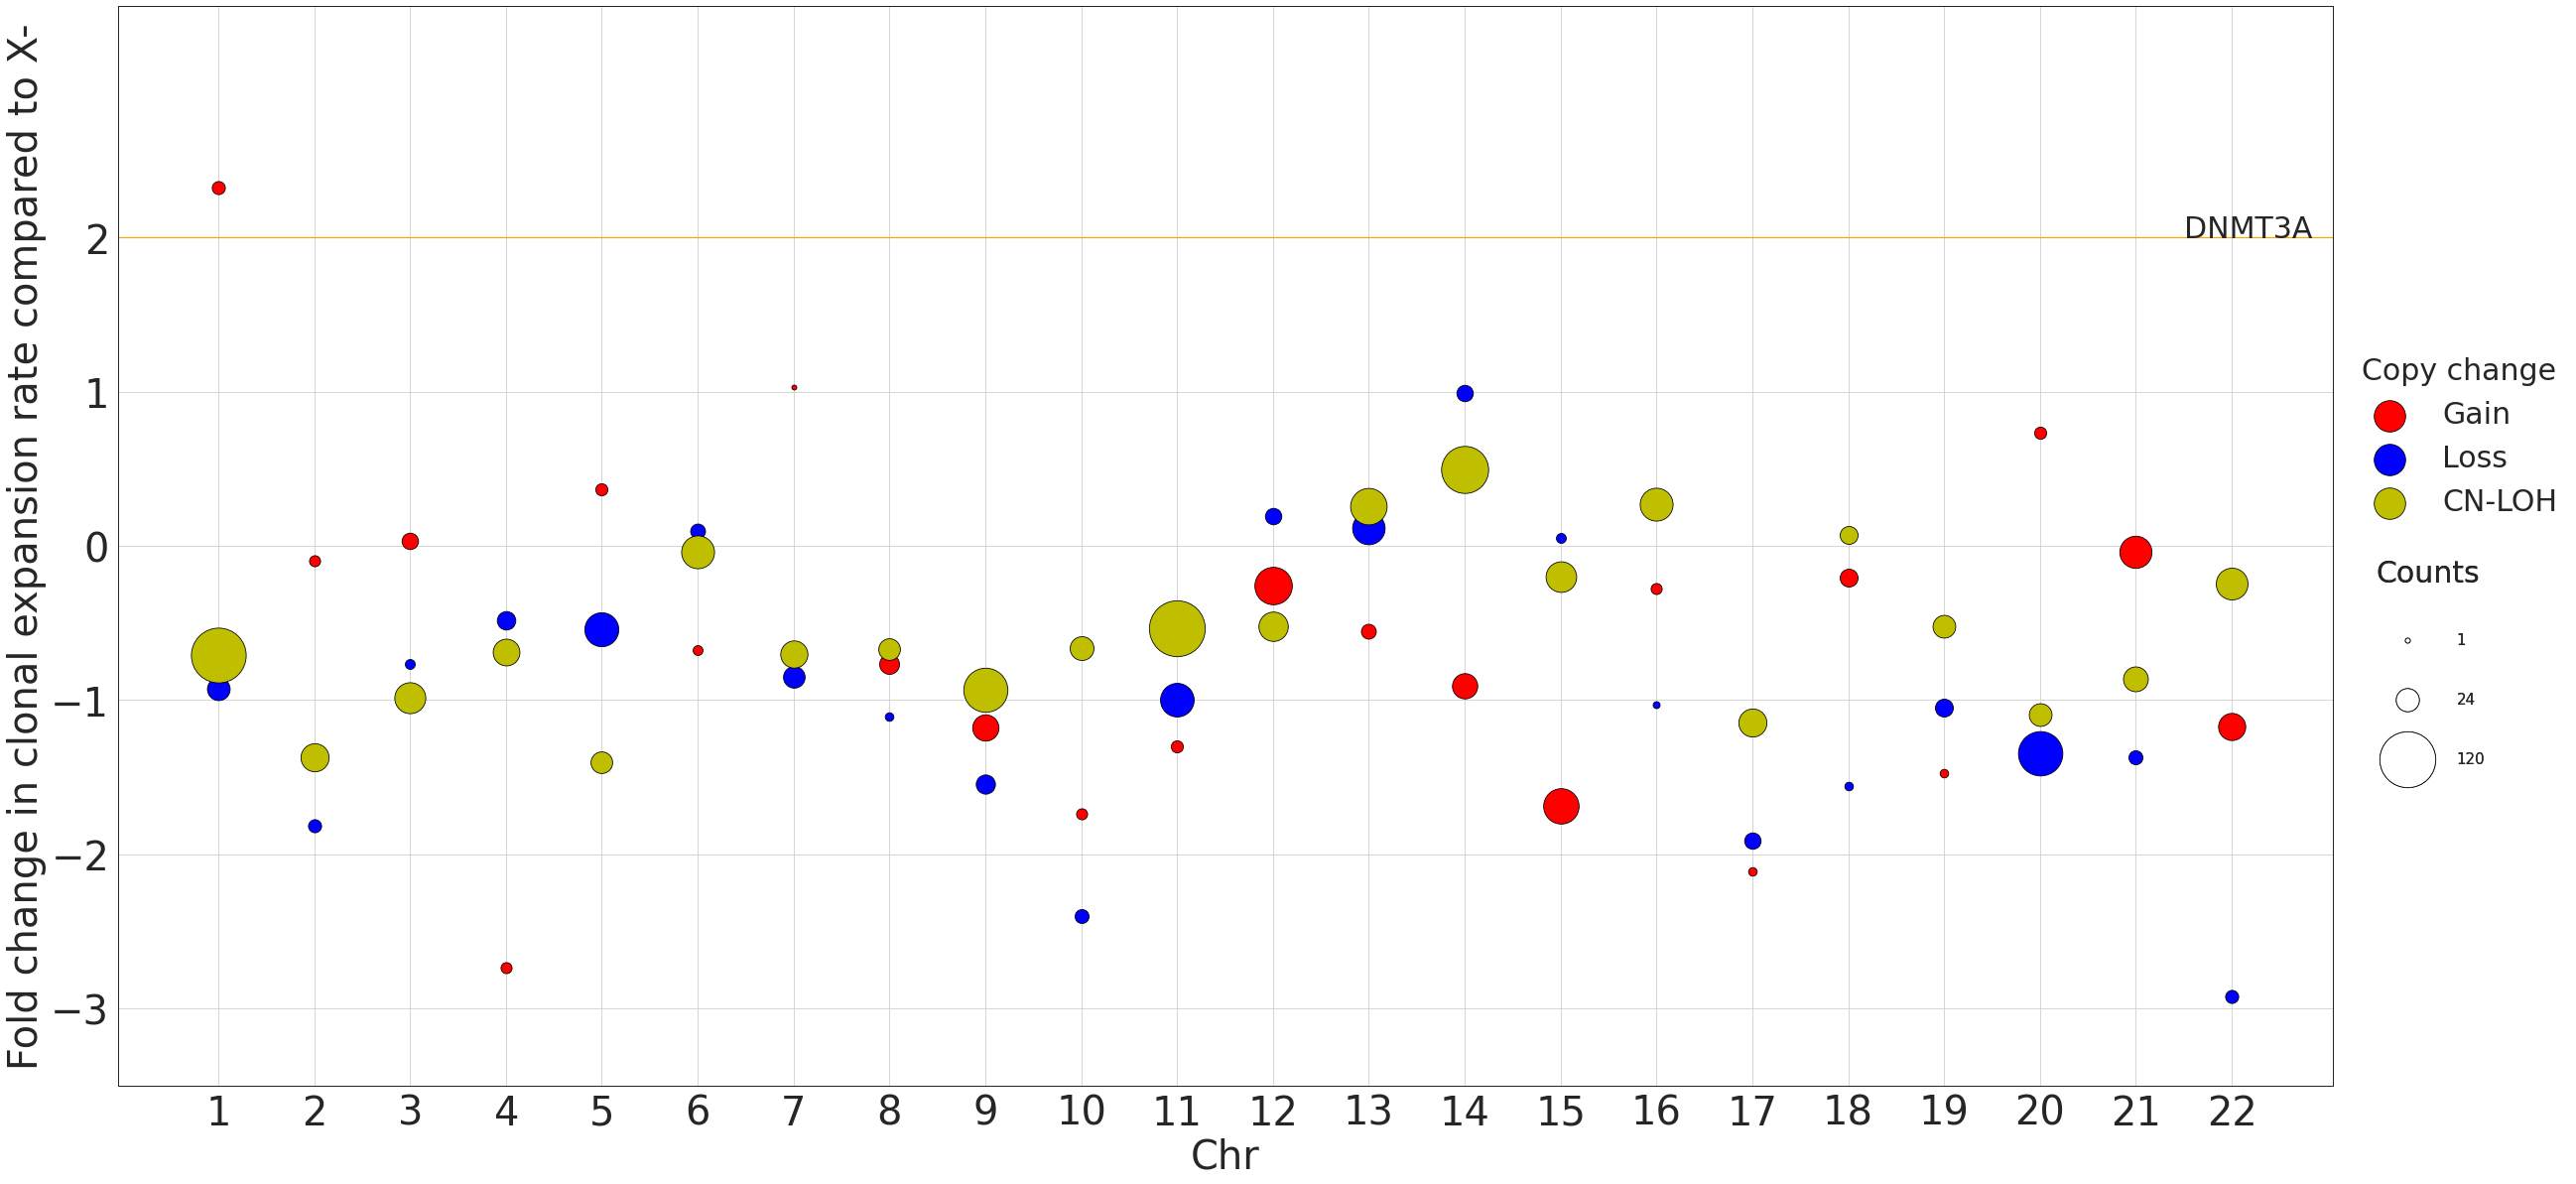

In [204]:
dotplot_mCA_pacer(mocha_df, mca_pacer_df_nochip, 'fig2b_fitnessdotplot.tif', False)

In [207]:
! gsutil cp fig2b_fitnessdotplot.tif gs://fc-secure-827e3d9c-02b8-499f-91af-c2142b7d2074/mCA_pacer/figures/fig2b_fitnessdotplot.tif

Copying file://fig2b_fitnessdotplot.tif [Content-Type=image/tiff]...
==> NOTE: You are uploading one or more large file(s), which would run          
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

/ [1 files][274.7 MiB/274.7 MiB]                                                
Operation completed over 1 objects/274.7 MiB.                                    


# Associations of PACER with clinical phenotypes

In [245]:
demographics = pd.read_csv('gs://fc-b7cd8c47-767b-4eda-b456-736a92f723ac/data/demographics.v3phen.csv')
blood = pd.read_csv('gs://fc-b7cd8c47-767b-4eda-b456-736a92f723ac/data/blood.v3phen.csv')

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3524: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [246]:
annot = pd.read_csv('gs://fc-b7cd8c47-767b-4eda-b456-736a92f723ac/data/freeze8_sample_annot_2019-03-28.txt', sep='\t')
sample_id_dict = pd.Series(annot['sample.id'].values,index=annot['subject_id']).to_dict()

In [247]:
blood['sample.id'] = blood['SUBJECT_ID'].map(sample_id_dict)

In [248]:
blood['sample.id'].isna().sum()

161690

In [249]:
mca_pacer_nochrx_df

sample.id  total_pass_mut  chip_case        age sex  sex_dummy  \
0     NWD379730             933      False  64.000000   F          0   
3     NWD617450             595      False  70.000000   M          1   
4     NWD873133             585      False  67.000000   M          1   
6     NWD344656             531      False  66.000000   F          0   
7     NWD916156             512       True  79.000000   M          1   
...         ...             ...        ...        ...  ..        ...   
6966  NWD205502               8      False  52.000000   F          0   
6968  NWD530980               8      False  32.216290   M          1   
6972  NWD313962               7      False  54.000000   M          1   
6977  NWD125938               6      False  54.313484   F          0   
6983  NWD508878               2      False  66.000000   M          1   

                       mCAs  mCA      cf mCA w arm  Autosomal Autosomal Type  \
0              Loss in chr5   5-  0.3037       5q-  Autosomal           Loss   
3           CN-LOH in chr13  13=  0.0152      13q=  Autosomal         CN-LOH   
4             Loss in chr13  13-  0.2025      13q-  Autosomal           Loss   
6             Gain in chr12  12+  0.2277       12+  Autosomal           Gain   
7             Loss in chr13  13-  0.5801      13q-  Autosomal           Loss   
...                     ...  ...     ...       ...        ...            ...   
6966   Undetermined in chr4   4U  0.0289       4qU  Autosomal   Undetermined   
6968        CN-LOH in chr13  13=  0.0187      13q=  Autosomal         CN-LOH   
6972  Undetermined in chr11  11U  0.0333      11pU  Autosomal   Undetermined   
6977        CN-LOH in chr13  13=  0.0124      13q=  Autosomal         CN-LOH   
6983        CN-LOH in chr10  10=  0.0115      10q=  Autosomal         CN-LOH   

      pacer_covadj_int  pacer_covadj_int_norm  
0           325.302868               1.527959  
3           221.265581               1.039292  
4           203.492851               0.955813  
6           187.915444               0.882645  
7           121.366602               0.570063  
...                ...                    ...  
6966        -60.395225              -0.283678  
6968        -38.580928              -0.181216  
6972       -100.437229              -0.471757  
6977        -62.897156              -0.295430  
6983       -132.618979              -0.622916  

[2122 rows x 14 columns]

In [250]:
mca_pacer_nochrx_bloodcounts_df = mca_pacer_nochrx_df.merge(blood, on="sample.id")

In [251]:
mca_pacer_nochrx_bloodcounts_df.columns

Index(['sample.id', 'total_pass_mut', 'chip_case', 'age', 'sex', 'sex_dummy',
       'mCAs', 'mCA', 'cf', 'mCA w arm', 'Autosomal', 'Autosomal Type',
       'pacer_covadj_int', 'pacer_covadj_int_norm', 'Unnamed: 0', 'SUBJECT_ID',
       'unique_subject_key', 'topmed_abbreviation',
       'age_at_hemoglobin_mcnc_bld_1', 'hemoglobin_mcnc_bld_1',
       'age_at_hematocrit_vfr_bld_1', 'hematocrit_vfr_bld_1',
       'age_at_rbc_ncnc_bld_1', 'rbc_ncnc_bld_1', 'age_at_wbc_ncnc_bld_1',
       'wbc_ncnc_bld_1', 'age_at_basophil_ncnc_bld_1', 'basophil_ncnc_bld_1',
       'age_at_eosinophil_ncnc_bld_1', 'eosinophil_ncnc_bld_1',
       'age_at_neutrophil_ncnc_bld_1', 'neutrophil_ncnc_bld_1',
       'age_at_lymphocyte_ncnc_bld_1', 'lymphocyte_ncnc_bld_1',
       'age_at_monocyte_ncnc_bld_1', 'monocyte_ncnc_bld_1',
       'age_at_platelet_ncnc_bld_1', 'platelet_ncnc_bld_1',
       'age_at_mch_entmass_rbc_1', 'mch_entmass_rbc_1',
       'age_at_mchc_mcnc_rbc_1', 'mchc_mcnc_rbc_1', 'age_at_mcv_entvol_

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


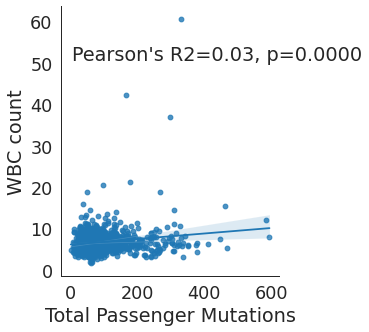

In [252]:
def annotate(data, **kws):
    r, p = pearsonr(data['total_pass_mut'], data['wbc_ncnc_bld_1'])
    ax = plt.gca()
    ax.text(.05, .8, 'Pearson\'s R2={:.2f}, p={:.4f}'.format(r**2, p),
            transform=ax.transAxes)

data = mca_pacer_nochrx_bloodcounts_df[~mca_pacer_nochrx_bloodcounts_df['wbc_ncnc_bld_1'].isna()]
data = data[~data['total_pass_mut'].isna()]
data.to_csv('mca_pacer_nochrx_bloodcounts_df.tsv', header = True, index = False, sep='\t')

g = sns.lmplot('total_pass_mut','wbc_ncnc_bld_1', 
               data=data)
plt.xlabel('Total Passenger Mutations')
plt.ylabel('WBC count')
g.map_dataframe(annotate)
plt.show()


In [253]:
! gsutil cp mca_pacer_nochrx_bloodcounts_df.tsv gs://fc-secure-827e3d9c-02b8-499f-91af-c2142b7d2074/mCA_pacer/mca_pacer_nochrx_bloodcounts_df.tsv

Copying file://mca_pacer_nochrx_bloodcounts_df.tsv [Content-Type=text/tab-separated-values]...
/ [1 files][272.2 KiB/272.2 KiB]                                                
Operation completed over 1 objects/272.2 KiB.                                    


In [254]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [255]:
model = smf.glm('wbc_ncnc_bld_1~age+sex_dummy+chip_case+total_pass_mut', data=data)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:         wbc_ncnc_bld_1   No. Observations:                  987
Model:                            GLM   Df Residuals:                      982
Model Family:                Gaussian   Df Model:                            4
Link Function:               identity   Scale:                          9.3954
Method:                          IRLS   Log-Likelihood:                -2503.5
Date:                Fri, 19 Aug 2022   Deviance:                       9226.3
Time:                        15:40:37   Pearson chi2:                 9.23e+03
No. Iterations:                     3   Pseudo R-squ. (CS):            0.03537
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             7.2159      0.555     13.010      0.000       6.129       8.303
chip_case[T.True]    -0.6232      0.339     -1.841      0.066      -1.287       0.040
age                  -0.0184      0.009     -2.093      0.036      -0.036      -0.001
sex_dummy             0.0582      0.197      0.296      0.767      -0.327       0.444
total_pass_mut        0.0081      0.001      5.853      0.000       0.005       0.011
=====================================================================================
"""

In [256]:
mixed = smf.mixedlm("wbc_ncnc_bld_1 ~ total_pass_mut + age + sex_dummy + chip_case", data, groups = data["mCA"],
                   re_formula = "~total_pass_mut")
mixed_fit = mixed.fit()
print(mixed_fit.summary())

/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)


                Mixed Linear Model Regression Results
Model:               MixedLM    Dependent Variable:    wbc_ncnc_bld_1
No. Observations:    987        Method:                REML          
No. Groups:          84         Scale:                 7.4503        
Min. group size:     1          Log-Likelihood:        -2862.6692    
Max. group size:     63         Converged:             Yes           
Mean group size:     11.8                                            
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                   7.095    0.535 13.263 0.000  6.046  8.143
chip_case[T.True]          -0.288    0.328 -0.876 0.381 -0.931  0.356
total_pass_mut              0.009    0.291  0.033 0.974 -0.561  0.580
age                        -0.019    0.008 -2.246 0.025 -0.036 -0.002
sex_dummy                   0.051   

/opt/conda/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


## Refer to this R notebook for mixed linear models

SNP clip for GWAS results.ipynb
https://app.terra.bio/#workspaces/bicklab-aps/bicklab-pershad/notebooks/launch/SNP%20clip%20for%20GWAS%20results.ipynb?mode=edit

# Fitness of SNPs and mCAs nearby

In [257]:
!gsutil cp gs://fc-secure-827e3d9c-02b8-499f-91af-c2142b7d2074/mCA_pacer/total_pass_mut_bychip_dict.pickle .

Copying gs://fc-secure-827e3d9c-02b8-499f-91af-c2142b7d2074/mCA_pacer/total_pass_mut_bychip_dict.pickle...
/ [1 files][ 25.5 KiB/ 25.5 KiB]                                                
Operation completed over 1 objects/25.5 KiB.                                     


In [258]:
with open('total_pass_mut_bychip_dict.pickle', 'rb') as handle:
    total_pass_mut_bychip_dict = pickle.load(handle)

In [259]:
dnmt3a_list = ['DNMT3A', '2p-', '2p=', '2p+', '2-', '2=', '2+']
tet2_list = ['TET2','4q-', '4q=', '4q+', '4-', '4=', '4+']
jak2_list = ['JAK2', '9p-', '9p=', '9p+', '9-', '9=', '9+']
asxl1_list = ['ASXL1', '20q-', '20q=', '20q+', '20-', '20=', '20+']

In [260]:
print(str(len(mca_pacer_nochrx_df[mca_pacer_nochrx_df['mCA w arm'].isin(dnmt3a_list)])) + " in DNMT3A set")
print(str(len(mca_pacer_nochrx_df[mca_pacer_nochrx_df['mCA w arm'].isin(tet2_list)])) + " in TET2 set")
print(str(len(mca_pacer_nochrx_df[mca_pacer_nochrx_df['mCA w arm'].isin(jak2_list)])) + " in JAK2 set")
print(str(len(mca_pacer_nochrx_df[mca_pacer_nochrx_df['mCA w arm'].isin(asxl1_list)])) + " in ASXL1 set")

29 in DNMT3A set
53 in TET2 set
80 in JAK2 set
115 in ASXL1 set


In [261]:
for element in dnmt3a_list:
    if len(mca_pacer_nochrx_df[mca_pacer_nochrx_df['mCA w arm'] == element]) > 3:
        total_pass_mut_bychip_dict[element] = np.array(mca_pacer_nochrx_df[mca_pacer_nochrx_df['mCA w arm'] == element]['total_pass_mut'])
for element in tet2_list:
    if len(mca_pacer_nochrx_df[mca_pacer_nochrx_df['mCA w arm'] == element]) > 3:
        total_pass_mut_bychip_dict[element] = np.array(mca_pacer_nochrx_df[mca_pacer_nochrx_df['mCA w arm'] == element]['total_pass_mut'])
for element in jak2_list:
    if len(mca_pacer_nochrx_df[mca_pacer_nochrx_df['mCA w arm'] == element]) > 3:
        total_pass_mut_bychip_dict[element] = np.array(mca_pacer_nochrx_df[mca_pacer_nochrx_df['mCA w arm'] == element]['total_pass_mut'])
for element in asxl1_list:
    if len(mca_pacer_nochrx_df[mca_pacer_nochrx_df['mCA w arm'] == element]) > 3:
        total_pass_mut_bychip_dict[element] = np.array(mca_pacer_nochrx_df[mca_pacer_nochrx_df['mCA w arm'] == element]['total_pass_mut'])

In [262]:
mut = []
tot_pass_mut = []

for key, value in total_pass_mut_bychip_dict.items():
    for element in value: 
        mut.append(key)
        tot_pass_mut.append(element)
    
total_pass_mut_bychip_df = pd.DataFrame(zip(mut, tot_pass_mut), columns=['Mutation', 'Total Passenger Mutations'])

In [263]:
def plot_chipvsmca(df, chip_list):
    df = df[df['Mutation'].isin(chip_list)]
    my_order = df.groupby(by=["Mutation"])["Total Passenger Mutations"].describe().sort_values('50%', ascending=False).index
    ax = sns.violinplot(x = "Mutation", y = "Total Passenger Mutations",
                data=df, order = my_order)
    plt.ylim(bottom=0)
    return df.groupby('Mutation').describe()

Total Passenger Mutations                                            \
                             count        mean         std   min   25%   50%   
Mutation                                                                       
2p-                            4.0  136.000000  182.650851  21.0  30.0  58.0   
2p=                           22.0   77.363636   43.879212  27.0  47.5  66.5   
DNMT3A                      2152.0  100.624535   61.481094  12.0  62.0  89.0   

                          
             75%     max  
Mutation                  
2p-       164.00   407.0  
2p=        97.75   205.0  
DNMT3A    126.00  1039.0

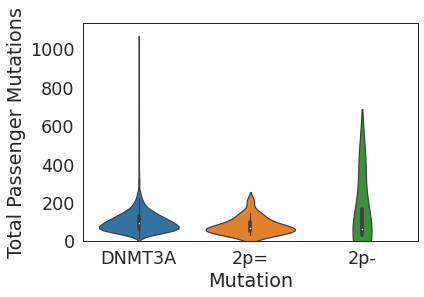

In [264]:
plot_chipvsmca(total_pass_mut_bychip_df, dnmt3a_list)

Total Passenger Mutations                                       \
                             count        mean         std   min    25%   
Mutation                                                                  
4q-                           14.0  130.214286  114.160601  41.0  54.25   
4q=                           32.0  153.437500  115.640415  26.0  48.00   
TET2                         681.0  140.211454  115.967221  14.0  81.00   

                                 
            50%     75%     max  
Mutation                         
4q-        89.5  157.00   465.0  
4q=       138.0  223.25   485.0  
TET2      126.0  175.00  2369.0

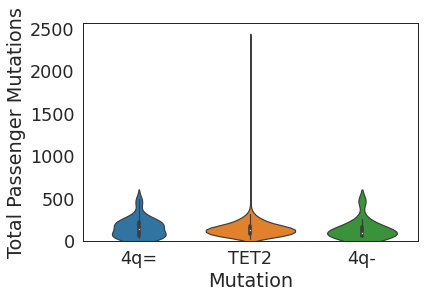

In [265]:
plot_chipvsmca(total_pass_mut_bychip_df, tet2_list)

Total Passenger Mutations                                       \
                             count        mean        std   min     25%   
Mutation                                                                  
9+                            11.0   96.909091  93.140168  22.0   32.00   
9p-                            4.0   68.000000  77.923039  16.0   29.50   
9p=                           60.0  135.500000  83.208234  19.0   61.00   
JAK2                          98.0  162.632653  82.159562  33.0  104.25   

                                
            50%     75%    max  
Mutation                        
9+         56.0  120.00  292.0  
9p-        36.0   74.50  184.0  
9p=       127.5  189.50  353.0  
JAK2      156.0  212.25  426.0

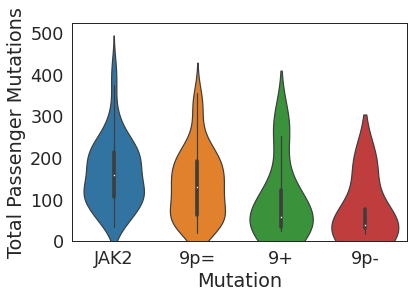

In [266]:
plot_chipvsmca(total_pass_mut_bychip_df, jak2_list)

Total Passenger Mutations                                       \
                             count        mean         std   min    25%   
Mutation                                                                  
20q+                           6.0  139.000000  167.018562  31.0  36.25   
20q-                          93.0  114.806452   77.660249  23.0  54.00   
20q=                          15.0   81.133333   76.421637  24.0  40.50   
ASXL1                        301.0  133.388704   63.089236  18.0  89.00   

                               
            50%    75%    max  
Mutation                       
20q+       89.0  126.0  468.0  
20q-      103.0  141.0  414.0  
20q=       47.0   83.0  310.0  
ASXL1     125.0  165.0  432.0

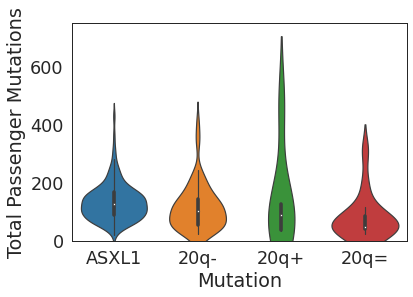

In [267]:
plot_chipvsmca(total_pass_mut_bychip_df, asxl1_list)